In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
import xgboost
from xgboost import XGBRegressor, XGBClassifier

In [4]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import max_num_bins, Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve, KDE_fitter, MLL_test_fast, MLL_test_fsolve


# AUX FUNCTION TO FIND SOLUTIONS

def dx(fn, x, delta=0.001):
    return (fn(x+delta) - fn(x))/delta

def solvecross(fn, value, x=-45, maxtries=1000, maxerr=0.1):
    for tries in range(maxtries):
        err = fn(x) - value
        if abs(err) < maxerr:
            return x
        slope = dx(fn, x)
        x -= err/slope
        if x < -47 or x > -44:
            x = random.uniform(-47, -44) 
    raise ValueError('no solution found')

### DATA

In [5]:
mDM_mDM = [10, 20, 35, 50, 100, 200, 500]

S_cross1045_mDM = [4.714, 85.417, 178.749, 191.536, 139.035, 78.757, 33.257]

print(S_cross1045_mDM)

filefolder = '../../data2024/processed/cs1cs2/'

[4.714, 85.417, 178.749, 191.536, 139.035, 78.757, 33.257]


In [6]:
##############
# PARAMETERS #
##############

tot_B = 634.55+2.26+0.01+0.6+5.34

f_ER = 634.55 / tot_B
f_AC = 2.26 / tot_B
f_CNNS = 0.01 / tot_B
f_RN = 0.6 / tot_B
f_WALL = 5.34 / tot_B

f_ER + f_AC + f_CNNS + f_RN + f_WALL



cross_factor = np.logspace(-47,-43,15) / 1e-45

S_expected_mDM = []
for i in range(len(S_cross1045_mDM)):
    S_expected_mDM.append( [max(1, round(S_cross1045_mDM[i] * fac)) for fac in cross_factor] )


# DISCOVERY: 'discovery', EXCLUSION: 'exclusion'
D_or_E = 'exclusion'

# requested number of pseudo experiments
num_pseudo = 2000

# number of expected background events per ensemble
B_expected = round(tot_B)

print('B_expected: ', B_expected)
print('S_cross1045_mDM: ', S_cross1045_mDM)
print('S_expected_mDM (from cross=1e-47 to 1e-44): ', S_expected_mDM)

B_expected:  643
S_cross1045_mDM:  [4.714, 85.417, 178.749, 191.536, 139.035, 78.757, 33.257]
S_expected_mDM (from cross=1e-47 to 1e-44):  [[1, 1, 1, 1, 1, 1, 2, 5, 9, 18, 34, 66, 126, 244, 471], [1, 2, 3, 6, 12, 23, 44, 85, 165, 318, 615, 1187, 2291, 4424, 8542], [2, 3, 7, 13, 25, 48, 93, 179, 345, 666, 1286, 2484, 4795, 9258, 17875], [2, 4, 7, 14, 27, 51, 99, 192, 370, 714, 1378, 2661, 5138, 9921, 19154], [1, 3, 5, 10, 19, 37, 72, 139, 268, 518, 1001, 1932, 3730, 7201, 13904], [1, 2, 3, 6, 11, 21, 41, 79, 152, 294, 567, 1094, 2113, 4079, 7876], [1, 1, 1, 2, 5, 9, 17, 33, 64, 124, 239, 462, 892, 1723, 3326]]


In [7]:
###############
# BACKGROUNDS # 
###############

B_cs1_ER = np.loadtxt(filefolder + 'ER_cs1.txt')
B_cs2_ER = np.loadtxt(filefolder + 'ER_cs2.txt')

print('B_cs1_ER.shape: ', B_cs1_ER.shape)
print('B_cs2_ER.shape: ', B_cs2_ER.shape)


B_cs1_AC = np.loadtxt(filefolder + 'AC_cs1.txt')
B_cs2_AC = np.loadtxt(filefolder + 'AC_cs2.txt')

print('\nB_cs1_AC.shape: ', B_cs1_AC.shape)
print('B_cs2_AC.shape: ', B_cs2_AC.shape)


B_cs1_CNNS = np.loadtxt(filefolder + 'CNNS_cs1.txt')
B_cs2_CNNS = np.loadtxt(filefolder + 'CNNS_cs2.txt')

print('\nB_cs1_CNNS.shape: ', B_cs1_CNNS.shape)
print('B_cs2_CNNS.shape: ', B_cs2_CNNS.shape)


B_cs1_RN = np.loadtxt(filefolder + 'RN_cs1.txt')
B_cs2_RN = np.loadtxt(filefolder + 'RN_cs2.txt')

print('\nB_cs1_RN.shape: ', B_cs1_RN.shape)
print('B_cs2_RN.shape: ', B_cs2_RN.shape)


B_cs1_WALL = np.loadtxt(filefolder + 'WALL_cs1.txt')
B_cs2_WALL = np.loadtxt(filefolder + 'WALL_cs2.txt')

print('\nB_cs1_WALL.shape: ', B_cs1_WALL.shape)
print('B_cs2_WALL.shape: ', B_cs2_WALL.shape)

B_cs1_ER.shape:  (67300,)
B_cs2_ER.shape:  (67300,)

B_cs1_AC.shape:  (5000,)
B_cs2_AC.shape:  (5000,)

B_cs1_CNNS.shape:  (43,)
B_cs2_CNNS.shape:  (43,)

B_cs1_RN.shape:  (4516,)
B_cs2_RN.shape:  (4516,)

B_cs1_WALL.shape:  (5000,)
B_cs2_WALL.shape:  (5000,)


In [8]:
# cs1 = [3, 70] PE
# cS2 = [50, 8000] PE

B_cs1_ER_aux = [B_cs1_ER[x] for x in range(len(B_cs1_ER)) if (3 < B_cs1_ER[x] < 70 and 50 < B_cs2_ER[x] < 8000)]
B_cs2_ER = [B_cs2_ER[x] for x in range(len(B_cs1_ER)) if (3 < B_cs1_ER[x] < 70 and 50 < B_cs2_ER[x] < 8000)]
B_cs1_ER = B_cs1_ER_aux

B_cs1_AC_aux = [B_cs1_AC[x] for x in range(len(B_cs1_AC)) if (3 < B_cs1_AC[x] < 70 and 50 < B_cs2_AC[x] < 8000)]
B_cs2_AC = [B_cs2_AC[x] for x in range(len(B_cs1_AC)) if (3 < B_cs1_AC[x] < 70 and 50 < B_cs2_AC[x] < 8000)]
B_cs1_AC = B_cs1_AC_aux

B_cs1_CNNS_aux = [B_cs1_CNNS[x] for x in range(len(B_cs1_CNNS)) if (3 < B_cs1_CNNS[x] < 70 and 50 < B_cs2_CNNS[x] < 8000)]
B_cs2_CNNS = [B_cs2_CNNS[x] for x in range(len(B_cs1_CNNS)) if (3 < B_cs1_CNNS[x] < 70 and 50 < B_cs2_CNNS[x] < 8000)]
B_cs1_CNNS = B_cs1_CNNS_aux

B_cs1_RN_aux = [B_cs1_RN[x] for x in range(len(B_cs1_RN)) if (3 < B_cs1_RN[x] < 70 and 50 < B_cs2_RN[x] < 8000)]
B_cs2_RN = [B_cs2_RN[x] for x in range(len(B_cs1_RN)) if (3 < B_cs1_RN[x] < 70 and 50 < B_cs2_RN[x] < 8000)]
B_cs1_RN = B_cs1_RN_aux

B_cs1_WALL_aux = [B_cs1_WALL[x] for x in range(len(B_cs1_WALL)) if (3 < B_cs1_WALL[x] < 70 and 50 < B_cs2_WALL[x] < 8000)]
B_cs2_WALL = [B_cs2_WALL[x] for x in range(len(B_cs1_WALL)) if (3 < B_cs1_WALL[x] < 70 and 50 < B_cs2_WALL[x] < 8000)]
B_cs1_WALL = B_cs1_WALL_aux

## Loop over the masses

## 1. cS1 and cS2

#### Train with all the DM masses


S_cs1.shape:  (34190,)
S_cs2.shape:  (34190,)

S_cs1.shape:  (33873,)
S_cs2.shape:  (33873,)

S_cs1.shape:  (33697,)
S_cs2.shape:  (33697,)

S_cs1.shape:  (35287,)
S_cs2.shape:  (35287,)

S_cs1.shape:  (37757,)
S_cs2.shape:  (37757,)

S_cs1.shape:  (34573,)
S_cs2.shape:  (34573,)

S_cs1.shape:  (35477,)
S_cs2.shape:  (35477,)

S_cs1_all.shape:  (230813,)
S_cs2_all.shape:  (230813,)
 NUM_DAT:  32117 

NUM_DAT_ER:  31709
NUM_DAT_AC:  112
NUM_DAT_CNNS:  1
NUM_DAT_RN:  29
NUM_DAT_WALL:  266

B_cs1cs2.shape:  (32117, 2)

S_cs1cs2.shape:  (32117, 2)


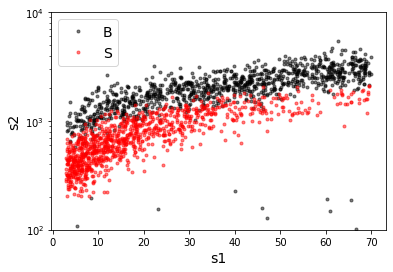

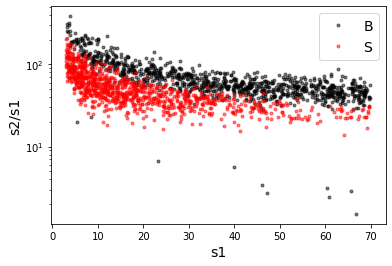

X_mon_B.shape:  (32117, 2)
X_mon_S.shape:  (32117, 2)
X_mon.shape:  (64234, 2)

X_mon_train :  (40948, 2)
y_mon_train :  (40948,)
X_mon_val :  (7227, 2)
y_mon_val :  (7227,)
X_mon_test :  (16059, 2)
y_mon_test :  (16059,)

[0]	validation_0-logloss:0.68520	validation_1-logloss:0.68521
[1]	validation_0-logloss:0.67741	validation_1-logloss:0.67744
[2]	validation_0-logloss:0.66978	validation_1-logloss:0.66982
[3]	validation_0-logloss:0.66229	validation_1-logloss:0.66235
[4]	validation_0-logloss:0.65493	validation_1-logloss:0.65502


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[5]	validation_0-logloss:0.64774	validation_1-logloss:0.64783
[6]	validation_0-logloss:0.64067	validation_1-logloss:0.64078
[7]	validation_0-logloss:0.63372	validation_1-logloss:0.63385
[8]	validation_0-logloss:0.62693	validation_1-logloss:0.62706
[9]	validation_0-logloss:0.62025	validation_1-logloss:0.62039
[10]	validation_0-logloss:0.61369	validation_1-logloss:0.61384
[11]	validation_0-logloss:0.60725	validation_1-logloss:0.60743
[12]	validation_0-logloss:0.60093	validation_1-logloss:0.60111
[13]	validation_0-logloss:0.59471	validation_1-logloss:0.59489
[14]	validation_0-logloss:0.58862	validation_1-logloss:0.58880
[15]	validation_0-logloss:0.58261	validation_1-logloss:0.58279
[16]	validation_0-logloss:0.57671	validation_1-logloss:0.57691
[17]	validation_0-logloss:0.57092	validation_1-logloss:0.57110
[18]	validation_0-logloss:0.56521	validation_1-logloss:0.56541
[19]	validation_0-logloss:0.55962	validation_1-logloss:0.55984
[20]	validation_0-logloss:0.55411	validation_1-logloss:0.554

[135]	validation_0-logloss:0.25082	validation_1-logloss:0.25169
[136]	validation_0-logloss:0.24969	validation_1-logloss:0.25058
[137]	validation_0-logloss:0.24859	validation_1-logloss:0.24949
[138]	validation_0-logloss:0.24748	validation_1-logloss:0.24839
[139]	validation_0-logloss:0.24639	validation_1-logloss:0.24732
[140]	validation_0-logloss:0.24532	validation_1-logloss:0.24627
[141]	validation_0-logloss:0.24425	validation_1-logloss:0.24521
[142]	validation_0-logloss:0.24320	validation_1-logloss:0.24418
[143]	validation_0-logloss:0.24218	validation_1-logloss:0.24316
[144]	validation_0-logloss:0.24116	validation_1-logloss:0.24216
[145]	validation_0-logloss:0.24014	validation_1-logloss:0.24115
[146]	validation_0-logloss:0.23915	validation_1-logloss:0.24017
[147]	validation_0-logloss:0.23816	validation_1-logloss:0.23918
[148]	validation_0-logloss:0.23719	validation_1-logloss:0.23823
[149]	validation_0-logloss:0.23623	validation_1-logloss:0.23729
[150]	validation_0-logloss:0.23527	valid

[264]	validation_0-logloss:0.17495	validation_1-logloss:0.17730
[265]	validation_0-logloss:0.17469	validation_1-logloss:0.17705
[266]	validation_0-logloss:0.17444	validation_1-logloss:0.17679
[267]	validation_0-logloss:0.17419	validation_1-logloss:0.17654
[268]	validation_0-logloss:0.17394	validation_1-logloss:0.17629
[269]	validation_0-logloss:0.17369	validation_1-logloss:0.17605
[270]	validation_0-logloss:0.17345	validation_1-logloss:0.17581
[271]	validation_0-logloss:0.17322	validation_1-logloss:0.17557
[272]	validation_0-logloss:0.17298	validation_1-logloss:0.17534
[273]	validation_0-logloss:0.17275	validation_1-logloss:0.17511
[274]	validation_0-logloss:0.17252	validation_1-logloss:0.17489
[275]	validation_0-logloss:0.17229	validation_1-logloss:0.17467
[276]	validation_0-logloss:0.17207	validation_1-logloss:0.17444
[277]	validation_0-logloss:0.17184	validation_1-logloss:0.17422
[278]	validation_0-logloss:0.17162	validation_1-logloss:0.17401
[279]	validation_0-logloss:0.17141	valid

[393]	validation_0-logloss:0.15749	validation_1-logloss:0.16060
[394]	validation_0-logloss:0.15743	validation_1-logloss:0.16055
[395]	validation_0-logloss:0.15737	validation_1-logloss:0.16050
[396]	validation_0-logloss:0.15731	validation_1-logloss:0.16044
[397]	validation_0-logloss:0.15725	validation_1-logloss:0.16038
[398]	validation_0-logloss:0.15719	validation_1-logloss:0.16032
[399]	validation_0-logloss:0.15712	validation_1-logloss:0.16026
[400]	validation_0-logloss:0.15706	validation_1-logloss:0.16020
[401]	validation_0-logloss:0.15700	validation_1-logloss:0.16014
[402]	validation_0-logloss:0.15694	validation_1-logloss:0.16009
[403]	validation_0-logloss:0.15689	validation_1-logloss:0.16005
[404]	validation_0-logloss:0.15683	validation_1-logloss:0.16001
[405]	validation_0-logloss:0.15678	validation_1-logloss:0.15996
[406]	validation_0-logloss:0.15672	validation_1-logloss:0.15990
[407]	validation_0-logloss:0.15666	validation_1-logloss:0.15986
[408]	validation_0-logloss:0.15661	valid

[522]	validation_0-logloss:0.15259	validation_1-logloss:0.15653
[523]	validation_0-logloss:0.15257	validation_1-logloss:0.15652
[524]	validation_0-logloss:0.15254	validation_1-logloss:0.15650
[525]	validation_0-logloss:0.15252	validation_1-logloss:0.15650
[526]	validation_0-logloss:0.15250	validation_1-logloss:0.15649
[527]	validation_0-logloss:0.15248	validation_1-logloss:0.15647
[528]	validation_0-logloss:0.15246	validation_1-logloss:0.15646
[529]	validation_0-logloss:0.15243	validation_1-logloss:0.15645
[530]	validation_0-logloss:0.15241	validation_1-logloss:0.15643
[531]	validation_0-logloss:0.15239	validation_1-logloss:0.15642
[532]	validation_0-logloss:0.15237	validation_1-logloss:0.15641
[533]	validation_0-logloss:0.15235	validation_1-logloss:0.15640
[534]	validation_0-logloss:0.15233	validation_1-logloss:0.15639
[535]	validation_0-logloss:0.15231	validation_1-logloss:0.15638
[536]	validation_0-logloss:0.15229	validation_1-logloss:0.15636
[537]	validation_0-logloss:0.15227	valid

[651]	validation_0-logloss:0.15058	validation_1-logloss:0.15582
[652]	validation_0-logloss:0.15056	validation_1-logloss:0.15582
[653]	validation_0-logloss:0.15055	validation_1-logloss:0.15582
[654]	validation_0-logloss:0.15054	validation_1-logloss:0.15581
[655]	validation_0-logloss:0.15053	validation_1-logloss:0.15581
[656]	validation_0-logloss:0.15052	validation_1-logloss:0.15580
[657]	validation_0-logloss:0.15051	validation_1-logloss:0.15580
[658]	validation_0-logloss:0.15050	validation_1-logloss:0.15580
[659]	validation_0-logloss:0.15048	validation_1-logloss:0.15580
[660]	validation_0-logloss:0.15047	validation_1-logloss:0.15579
[661]	validation_0-logloss:0.15046	validation_1-logloss:0.15579
[662]	validation_0-logloss:0.15045	validation_1-logloss:0.15579
[663]	validation_0-logloss:0.15044	validation_1-logloss:0.15579
[664]	validation_0-logloss:0.15042	validation_1-logloss:0.15578
[665]	validation_0-logloss:0.15041	validation_1-logloss:0.15578
[666]	validation_0-logloss:0.15040	valid

[780]	validation_0-logloss:0.14930	validation_1-logloss:0.15576
[781]	validation_0-logloss:0.14930	validation_1-logloss:0.15576
[782]	validation_0-logloss:0.14929	validation_1-logloss:0.15576
[783]	validation_0-logloss:0.14928	validation_1-logloss:0.15576
[784]	validation_0-logloss:0.14927	validation_1-logloss:0.15576
[785]	validation_0-logloss:0.14926	validation_1-logloss:0.15576
[786]	validation_0-logloss:0.14926	validation_1-logloss:0.15576
[787]	validation_0-logloss:0.14925	validation_1-logloss:0.15577
[788]	validation_0-logloss:0.14924	validation_1-logloss:0.15577
[789]	validation_0-logloss:0.14924	validation_1-logloss:0.15576
[790]	validation_0-logloss:0.14922	validation_1-logloss:0.15576
[791]	validation_0-logloss:0.14922	validation_1-logloss:0.15577
[792]	validation_0-logloss:0.14921	validation_1-logloss:0.15577
[793]	validation_0-logloss:0.14920	validation_1-logloss:0.15576
[794]	validation_0-logloss:0.14919	validation_1-logloss:0.15576
[795]	validation_0-logloss:0.14918	valid

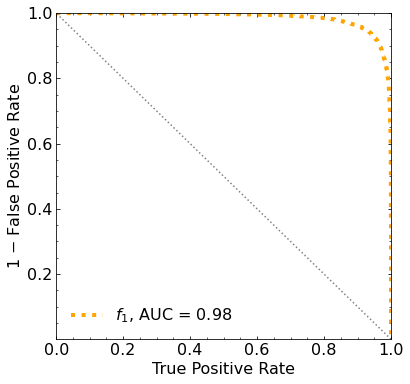

In [215]:

##########
# SIGNAL #
##########

S_cs1_all = np.array([])
S_cs2_all = np.array([])

for m_it in range(len(mDM_mDM)):
    
    mDM = mDM_mDM[m_it]

    S_cs1 = np.loadtxt(filefolder + 'WIMP_' + str(mDM) + 'GeV_cs1.txt')
    S_cs2 = np.loadtxt(filefolder + 'WIMP_' + str(mDM) + 'GeV_cs2.txt')

    print('\nS_cs1.shape: ', S_cs1.shape)
    print('S_cs2.shape: ', S_cs2.shape)

    S_cs1_aux = [S_cs1[x] for x in range(len(S_cs1)) if (3 < S_cs1[x] < 70 and 50 < S_cs2[x] < 8000)]
    S_cs2 = [S_cs2[x] for x in range(len(S_cs1)) if (3 < S_cs1[x] < 70 and 50 < S_cs2[x] < 8000)]
    S_cs1 = S_cs1_aux
    
    
    S_cs1_all = np.concatenate([S_cs1_all.tolist(), S_cs1])
    S_cs2_all = np.concatenate([S_cs2_all.tolist(), S_cs2])
    
print('\nS_cs1_all.shape: ', S_cs1_all.shape)
print('S_cs2_all.shape: ', S_cs2_all.shape)


# set events per classs
NUM_DAT = min(len(B_cs1_ER), len(S_cs1))
print(' NUM_DAT: ', NUM_DAT, '\n')

NUM_DAT_AC = int(NUM_DAT*f_AC)
NUM_DAT_CNNS = max(1, int(NUM_DAT*f_CNNS))
NUM_DAT_RN = int(NUM_DAT*f_RN)
NUM_DAT_WALL = int(NUM_DAT*f_WALL)

NUM_DAT_ER = NUM_DAT - ( NUM_DAT_AC + NUM_DAT_CNNS + NUM_DAT_RN + NUM_DAT_WALL )

print('NUM_DAT_ER: ', NUM_DAT_ER)
print('NUM_DAT_AC: ', NUM_DAT_AC)
print('NUM_DAT_CNNS: ', NUM_DAT_CNNS)
print('NUM_DAT_RN: ', NUM_DAT_RN)
print('NUM_DAT_WALL: ', NUM_DAT_WALL)



# CONCATENATE THE BACKGROUNDS
B_cs1cs2 = np.concatenate([np.stack([B_cs1_ER,B_cs2_ER],axis=1)[:NUM_DAT_ER], np.stack([B_cs1_AC,B_cs2_AC],axis=1)[:NUM_DAT_AC], np.stack([B_cs1_CNNS,B_cs2_CNNS],axis=1)[:NUM_DAT_CNNS], np.stack([B_cs1_RN,B_cs2_RN],axis=1)[:NUM_DAT_RN], np.stack([B_cs1_WALL,B_cs2_WALL],axis=1)[:NUM_DAT_WALL]])

print('\nB_cs1cs2.shape: ', B_cs1cs2.shape)


S_cs1cs2 = np.stack([S_cs1_all,S_cs2_all],axis=1)
np.random.shuffle( S_cs1cs2 )
S_cs1cs2 = S_cs1cs2[:NUM_DAT]


print('\nS_cs1cs2.shape: ', S_cs1cs2.shape)


rnd = 100

B_cs1cs2_plot = shuffle(B_cs1cs2, random_state=rnd)
S_cs1cs2_plot = shuffle(S_cs1cs2, random_state=rnd)

plt.plot(B_cs1cs2_plot[:,0][:1000], B_cs1cs2_plot[:,1][:1000], '.', color='black', alpha=0.5, label='B')
plt.plot(S_cs1cs2_plot[:,0][:1000], S_cs1cs2_plot[:,1][:1000], '.', color='red', alpha=0.5, label='S')
plt.yscale('log')
# plt.xlim([0,100])
plt.ylim([100,10000])
plt.xlabel('s1',fontsize=14)
plt.ylabel('s2',fontsize=14)
plt.legend(fontsize=14)
plt.show()



plt.plot(B_cs1cs2_plot[:,0][:1000], (B_cs1cs2_plot[:,1] / B_cs1cs2_plot[:,0])[:1000], '.', color='black', alpha=0.5, label='B')
plt.plot(S_cs1cs2_plot[:,0][:1000], (S_cs1cs2_plot[:,1] / S_cs1cs2_plot[:,0])[:1000], '.', color='red', alpha=0.5, label='S')
plt.yscale('log')
# plt.xlim([0,100])
# plt.ylim([100,10000])
plt.xlabel('s1',fontsize=14)
plt.ylabel('s2/s1',fontsize=14)
plt.legend(fontsize=14)
plt.show()


############
# DATASETS #
############

# concatenate the data
X_mon_B = B_cs1cs2
X_mon_S = S_cs1cs2

# X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))
# X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))
print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)

# del B_ppeakS1
# del B_ppeakS2
# del B_pbot
# del B_ptop

# del S_ppeakS1
# del S_ppeakS2
# del S_pbot
# del S_ptop

X_mon = np.concatenate([X_mon_B, X_mon_S])

# X_mon = np.concatenate([np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(S_pbot,(len(S_pbot),1))])

print('X_mon.shape: ', X_mon.shape)
# del X_mon_B
# del X_mon_S


# labels
y_mon = np.concatenate([np.zeros(NUM_DAT),np.ones(NUM_DAT)])


# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')



###########
# XGBOOST #
###########

# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=2500,
    learning_rate=0.01,
    reg_lambda=0.01,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



#########################

mDM =  10 GeV


S_cs1.shape:  (34190,)
S_cs2.shape:  (34190,)
 NUM_DAT:  31606 

NUM_DAT_ER:  31203
NUM_DAT_AC:  111
NUM_DAT_CNNS:  1
NUM_DAT_RN:  29
NUM_DAT_WALL:  262

B_cs1cs2.shape:  (31606, 2)

S_cs1cs2.shape:  (31606, 2)


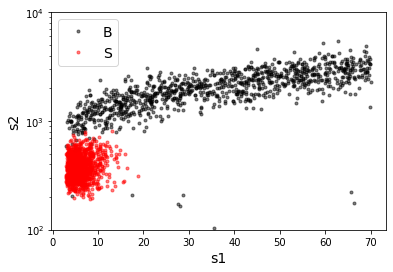

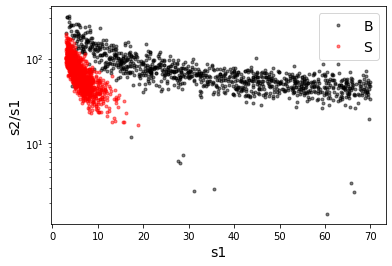

X_mon_B.shape:  (31606, 2)
X_mon_S.shape:  (31606, 2)
X_mon.shape:  (63212, 2)

X_mon_train :  (40297, 2)
y_mon_train :  (40297,)
X_mon_val :  (7112, 2)
y_mon_val :  (7112,)
X_mon_test :  (15803, 2)
y_mon_test :  (15803,)

Classification score:


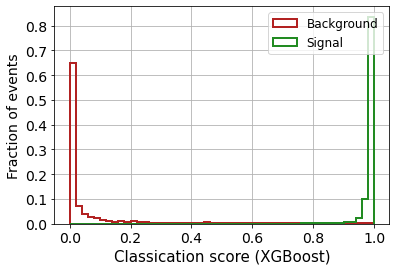


 ROC-AUC =  0.9977447762853633
At least 5 B events per bin, range = [[0, 1]]:
# bins:  13 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
max number of bins allowed:  13
range of our data:  [[0, 1]]
number of bins we are going to use:  10
B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.34


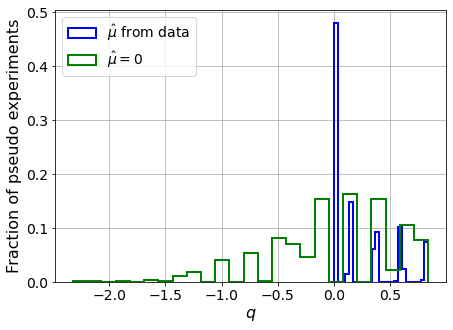

muhat mean:  0.49674404683145806
Z_bins:  0.36679383259149834
std Z_bins:  0.36834922719438085
Z_bins mu=0:  0.36679383259149834
std Z_bins mu=0:  0.7440532708886815

--------

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.356


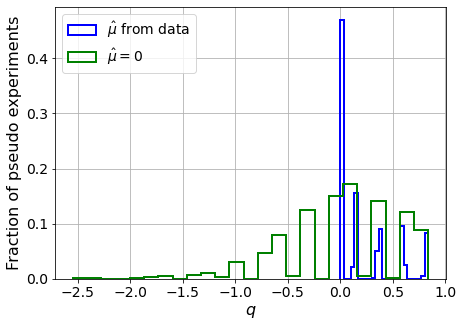

muhat mean:  0.41027621771927936
Z_bins:  0.3701975010086441
std Z_bins:  0.37187748859466224
Z_bins mu=0:  0.3701975010086441
std Z_bins mu=0:  0.7263622143073719

--------

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.339


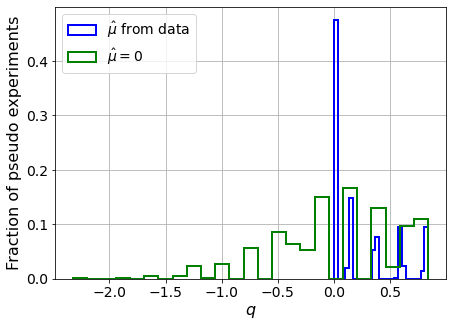

muhat mean:  0.4026799458096638
Z_bins:  0.3687653907975399
std Z_bins:  0.38931874385133997
Z_bins mu=0:  0.3687653907975399
std Z_bins mu=0:  0.7462459473448073

--------

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3775


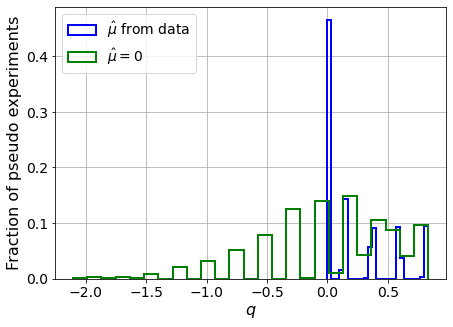

muhat mean:  0.3843431369163137
Z_bins:  0.3729039141782611
std Z_bins:  0.37758598846288716
Z_bins mu=0:  0.3729039141782611
std Z_bins mu=0:  0.7360049359577606

--------

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.372


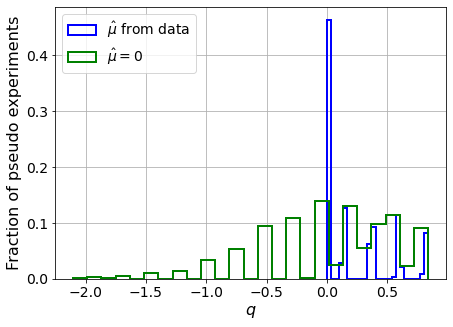

muhat mean:  0.39383315159195437
Z_bins:  0.3711042258775481
std Z_bins:  0.3769317188624383
Z_bins mu=0:  0.3711042258775481
std Z_bins mu=0:  0.7409025387626026

--------

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3495


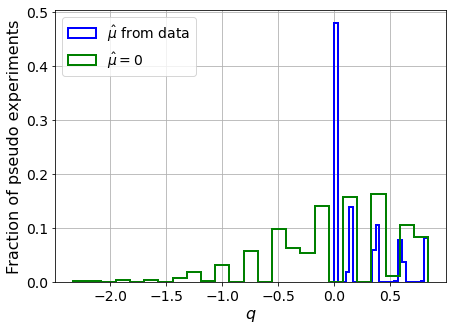

muhat mean:  0.5047609333675412
Z_bins:  0.3659190408550408
std Z_bins:  0.3725353137901287
Z_bins mu=0:  0.3659190408550408
std Z_bins mu=0:  0.7514665319230779

--------

B_expected:  643
S_expected:  2

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.358


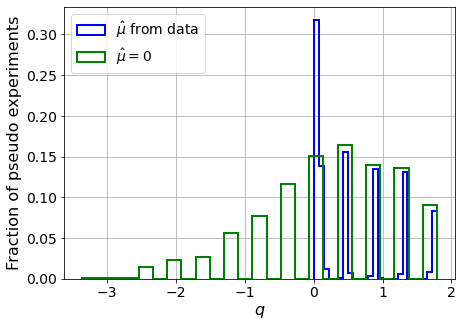

muhat mean:  0.19698348649698488
Z_bins:  0.6750016751078314
std Z_bins:  0.44099775210714715
Z_bins mu=0:  0.6750016751078314
std Z_bins mu=0:  0.7629865145202146

--------

B_expected:  643
S_expected:  5

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3685


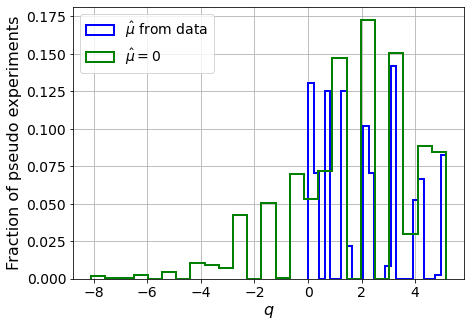

muhat mean:  0.09773670355966661
Z_bins:  1.4829669646425312
std Z_bins:  0.5306948139003048
Z_bins mu=0:  1.4829669646425312
std Z_bins mu=0:  0.7755271388512889

--------

B_expected:  643
S_expected:  9

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3615


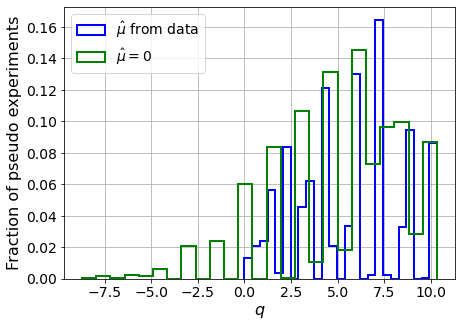

muhat mean:  0.039329520415469235
Z_bins:  2.411837022016205
std Z_bins:  0.5731063509644759
Z_bins mu=0:  2.411837022016205
std Z_bins mu=0:  0.7184822349374015

--------

B_expected:  643
S_expected:  18

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3635


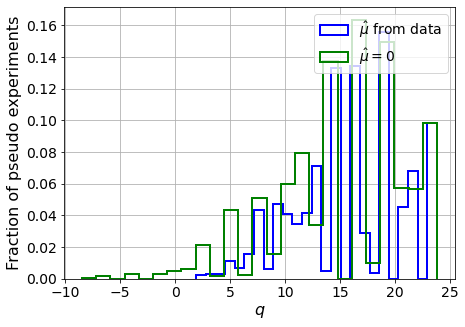

muhat mean:  0.026165034058315252
Z_bins:  4.066200287963498
std Z_bins:  0.6065667599777246
Z_bins mu=0:  4.066200287963498
std Z_bins mu=0:  0.7107623540276725

--------

B_expected:  643
S_expected:  34

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3735


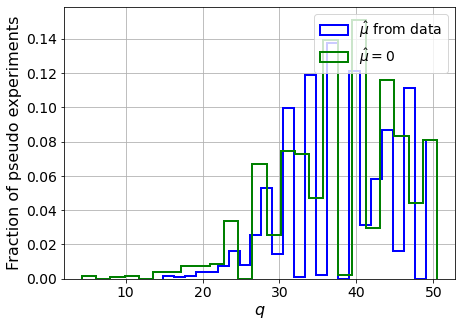

muhat mean:  0.016510039823960838
Z_bins:  6.294443620139711
std Z_bins:  0.5688982226574995
Z_bins mu=0:  6.294443620139711
std Z_bins mu=0:  0.6331516783647204

--------

B_expected:  643
S_expected:  66

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.356


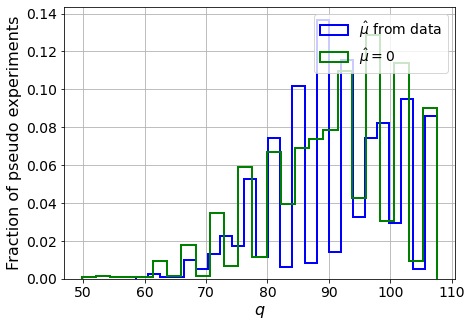

muhat mean:  0.006564284502428468
Z_bins:  9.636980738965608
std Z_bins:  0.5114471199522286
Z_bins mu=0:  9.636980738965608
std Z_bins mu=0:  0.5508012495754481

--------

B_expected:  643
S_expected:  126

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.353


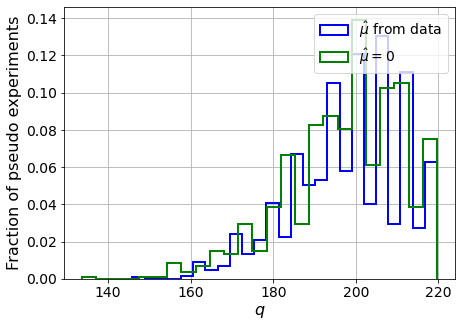

muhat mean:  0.003482824139236451
Z_bins:  14.13625855034695
std Z_bins:  0.4600406809363943
Z_bins mu=0:  14.13625855034695
std Z_bins mu=0:  0.49067116352162726

--------

B_expected:  643
S_expected:  244

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.365


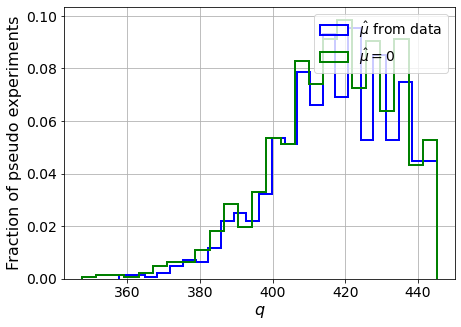

muhat mean:  0.0018351813486572888
Z_bins:  20.46030028865343
std Z_bins:  0.3937292167073972
Z_bins mu=0:  20.45951718383477
std Z_bins mu=0:  0.4140727316630924

--------

B_expected:  643
S_expected:  471

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3495


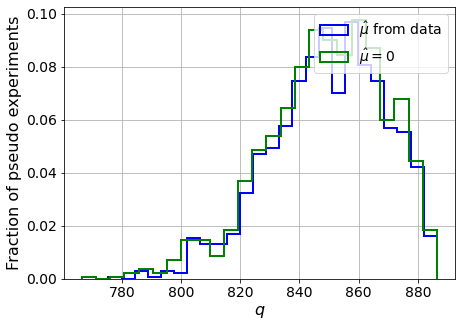

muhat mean:  0.0011794601326851788
Z_bins:  29.163885389469712
std Z_bins:  0.32972288395971366
Z_bins mu=0:  29.163885389469712
std Z_bins mu=0:  0.3436647360128376

--------


 FINAL RESULT:

[[0.36679383259149834, 0.36834922719438085, 0.49674404683145806, 0.36679383259149834, 0.7440532708886815], [0.3701975010086441, 0.37187748859466224, 0.41027621771927936, 0.3701975010086441, 0.7263622143073719], [0.3687653907975399, 0.38931874385133997, 0.4026799458096638, 0.3687653907975399, 0.7462459473448073], [0.3729039141782611, 0.37758598846288716, 0.3843431369163137, 0.3729039141782611, 0.7360049359577606], [0.3711042258775481, 0.3769317188624383, 0.39383315159195437, 0.3711042258775481, 0.7409025387626026], [0.3659190408550408, 0.3725353137901287, 0.5047609333675412, 0.3659190408550408, 0.7514665319230779], [0.6750016751078314, 0.44099775210714715, 0.19698348649698488, 0.6750016751078314, 0.7629865145202146], [1.4829669646425312, 0.5306948139003048, 0.09773670355966661, 1.4829669646425312

/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [        -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf 344.87278328 306.36774651 266.66855583 216.84002299
 160.04103923 100.88101273  37.94711357 -26.60994566 -95.8602819 ]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:990: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [        -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
    

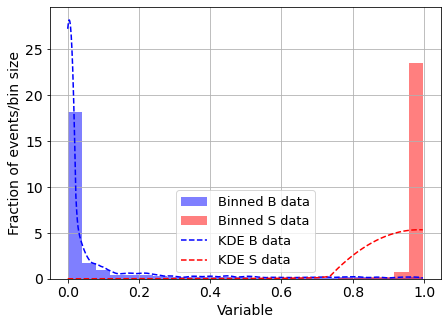

KDE Kernel:  epanechnikov
Background bandwidth:  0.022117541055781564
Signal bandwidth:  0.257351270001691
This may take a while...
1 done
2 done
B_expected:  643
S_expected:  1



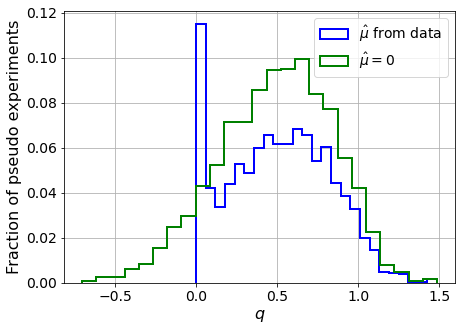

muhat mean:  -5.513019047702529
Z_bins:  0.7161860024819859
std Z_bins:  0.2215159610580691
Z_bins mu=0:  0.7161860024819859
std Z_bins mu=0:  0.2435154747323204

--------

B_expected:  643
S_expected:  1



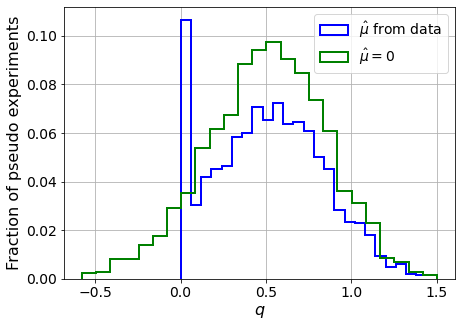

muhat mean:  -5.866336495745985
Z_bins:  0.721078381633282
std Z_bins:  0.22185500663205712
Z_bins mu=0:  0.721078381633282
std Z_bins mu=0:  0.24076794224869436

--------

B_expected:  643
S_expected:  1



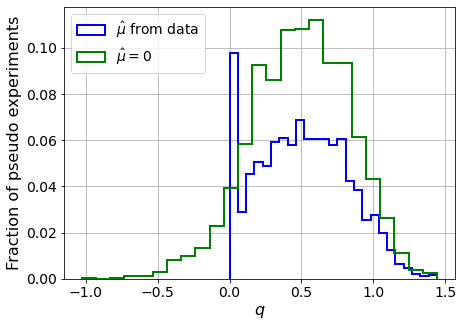

muhat mean:  -5.579469632953493
Z_bins:  0.7085584404008032
std Z_bins:  0.22085628672580507
Z_bins mu=0:  0.7085584404008032
std Z_bins mu=0:  0.24184998768231866

--------

B_expected:  643
S_expected:  1



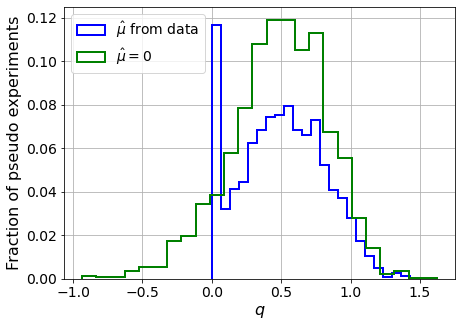

muhat mean:  -5.487659932365168
Z_bins:  0.7104518681030397
std Z_bins:  0.21834354272107193
Z_bins mu=0:  0.7104518681030397
std Z_bins mu=0:  0.24714039493030504

--------

B_expected:  643
S_expected:  1



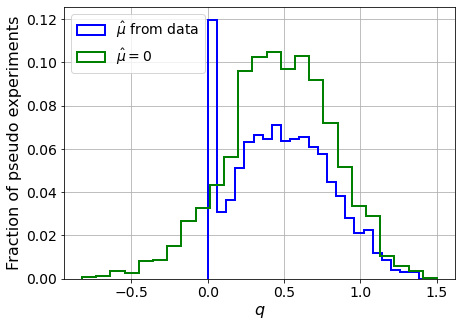

muhat mean:  -5.292924203817598
Z_bins:  0.6906014059345823
std Z_bins:  0.22671608128490087
Z_bins mu=0:  0.6906014059345823
std Z_bins mu=0:  0.2529441808387728

--------

B_expected:  643
S_expected:  1



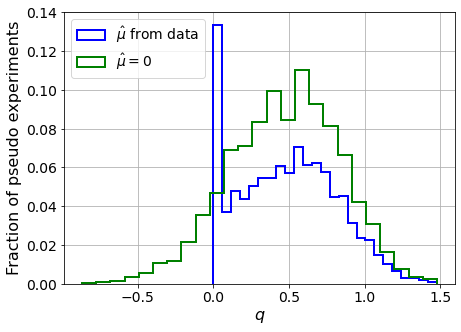

muhat mean:  -5.295614005262314
Z_bins:  0.7035826261087579
std Z_bins:  0.23181167096986033
Z_bins mu=0:  0.7035826261087579
std Z_bins mu=0:  0.2576420804148199

--------

B_expected:  643
S_expected:  2



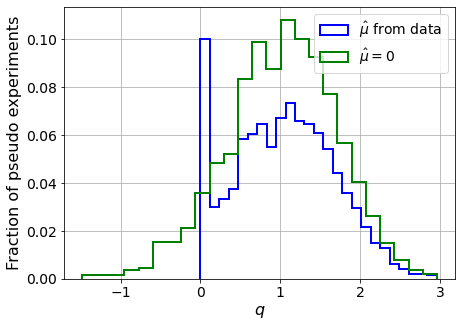

muhat mean:  -2.6756333966475485
Z_bins:  1.0265216120940979
std Z_bins:  0.3066811987974268
Z_bins mu=0:  1.0265216120940979
std Z_bins mu=0:  0.3348571686558246

--------

B_expected:  643
S_expected:  5



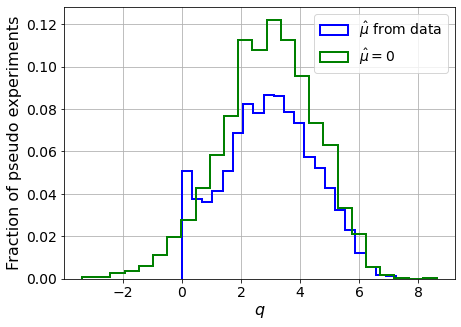

muhat mean:  -1.0588112730964212
Z_bins:  1.7295443591035204
std Z_bins:  0.4401194367627151
Z_bins mu=0:  1.7295443591035204
std Z_bins mu=0:  0.46914152959287814

--------

B_expected:  643
S_expected:  9



/home/andres/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


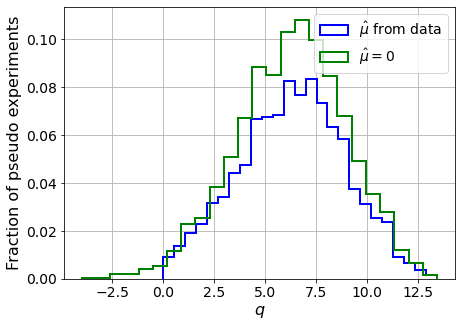

muhat mean:  -0.6138789614377217
Z_bins:  2.530844231020627
std Z_bins:  0.5115400552525271
Z_bins mu=0:  2.530844231020627
std Z_bins mu=0:  0.5265673205906258

--------

B_expected:  643
S_expected:  18



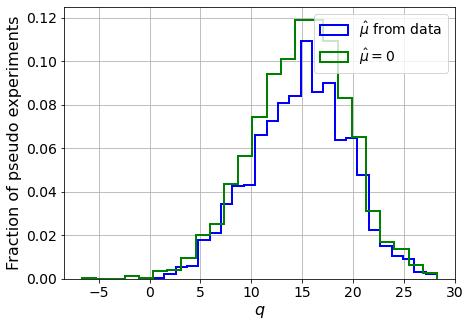

muhat mean:  -0.29022795968914056
Z_bins:  3.8902655993869217
std Z_bins:  0.5974621010630532
Z_bins mu=0:  3.8902655993869217
std Z_bins mu=0:  0.612297439456396

--------

B_expected:  643
S_expected:  34



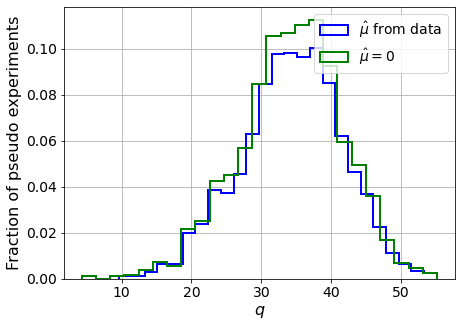

muhat mean:  -0.15716533581121042
Z_bins:  5.887385343826484
std Z_bins:  0.6185810486733955
Z_bins mu=0:  5.887385343826484
std Z_bins mu=0:  0.628753050062213

--------

B_expected:  643
S_expected:  66



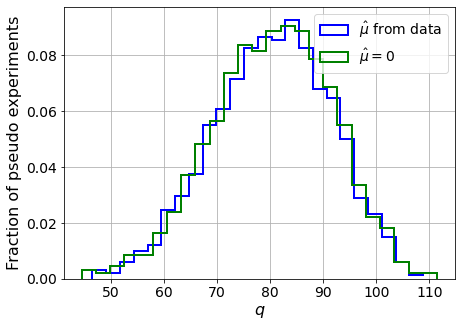

muhat mean:  -0.08390872086290331
Z_bins:  8.994300111869013
std Z_bins:  0.6161741435974475
Z_bins mu=0:  8.994300111869013
std Z_bins mu=0:  0.6212747641213374

--------

B_expected:  643
S_expected:  126



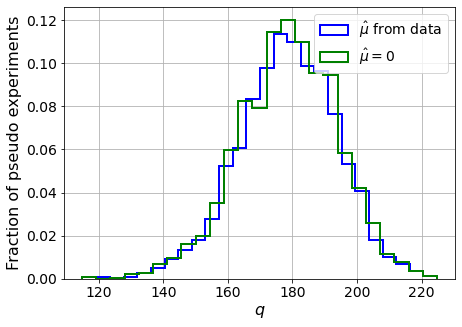

muhat mean:  -0.04427338860338981
Z_bins:  13.381893385887068
std Z_bins:  0.5692687634961628
Z_bins mu=0:  13.381893385887068
std Z_bins mu=0:  0.5730039744048591

--------

B_expected:  643
S_expected:  244



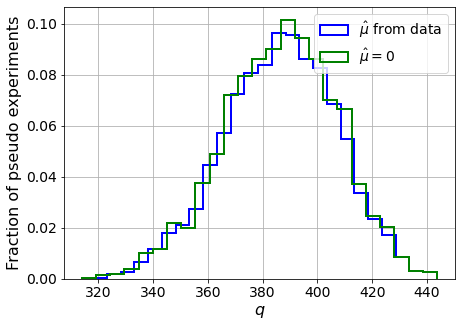

muhat mean:  -0.021825418927864472
Z_bins:  19.681003402785965
std Z_bins:  0.522155427220953
Z_bins mu=0:  19.681003402785965
std Z_bins mu=0:  0.5247280457581155

--------

B_expected:  643
S_expected:  471



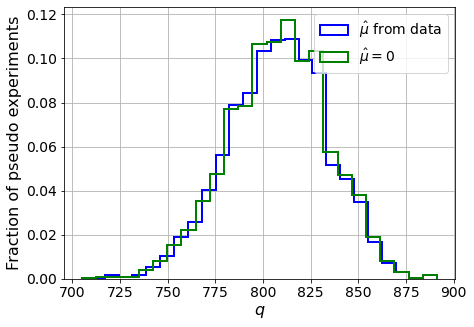

muhat mean:  -0.011372766379886446
Z_bins:  28.440195574367003
std Z_bins:  0.4569387005844092
Z_bins mu=0:  28.440195574367003
std Z_bins mu=0:  0.4586884892249633

--------


 FINAL RESULT:

[[0.7161860024819859, 0.2215159610580691, -5.513019047702529, 0.7161860024819859, 0.2435154747323204], [0.721078381633282, 0.22185500663205712, -5.866336495745985, 0.721078381633282, 0.24076794224869436], [0.7085584404008032, 0.22085628672580507, -5.579469632953493, 0.7085584404008032, 0.24184998768231866], [0.7104518681030397, 0.21834354272107193, -5.487659932365168, 0.7104518681030397, 0.24714039493030504], [0.6906014059345823, 0.22671608128490087, -5.292924203817598, 0.6906014059345823, 0.2529441808387728], [0.7035826261087579, 0.23181167096986033, -5.295614005262314, 0.7035826261087579, 0.2576420804148199], [1.0265216120940979, 0.3066811987974268, -2.6756333966475485, 1.0265216120940979, 0.3348571686558246], [1.7295443591035204, 0.4401194367627151, -1.0588112730964212, 1.7295443591035204, 0.4

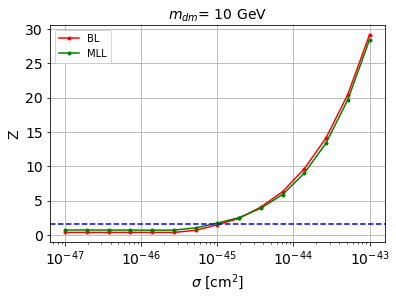


cross_BL_164:  1.1176409942332989e-45
cross_BL_164_up:  7.763952084315532e-46
cross_BL_164_down:  1.665947990567396e-45

cross_MLL_164:  1e-45
cross_MLL_164_up:  6.70805808467225e-46
cross_MLL_164_down:  1.371620855888689e-45

#########################


#########################

mDM =  20 GeV


S_cs1.shape:  (33873,)
S_cs2.shape:  (33873,)
 NUM_DAT:  33001 

NUM_DAT_ER:  32580
NUM_DAT_AC:  116
NUM_DAT_CNNS:  1
NUM_DAT_RN:  30
NUM_DAT_WALL:  274

B_cs1cs2.shape:  (33001, 2)

S_cs1cs2.shape:  (33001, 2)


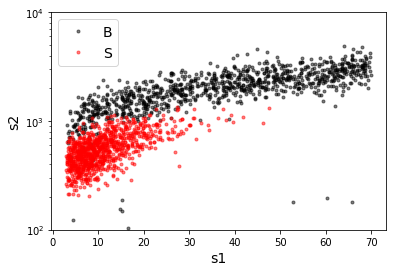

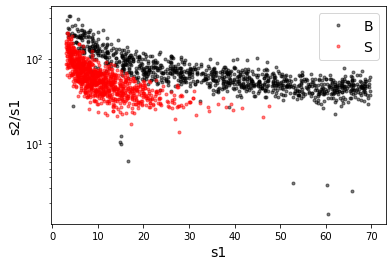

X_mon_B.shape:  (33001, 2)
X_mon_S.shape:  (33001, 2)
X_mon.shape:  (66002, 2)

X_mon_train :  (42075, 2)
y_mon_train :  (42075,)
X_mon_val :  (7426, 2)
y_mon_val :  (7426,)
X_mon_test :  (16501, 2)
y_mon_test :  (16501,)

Classification score:


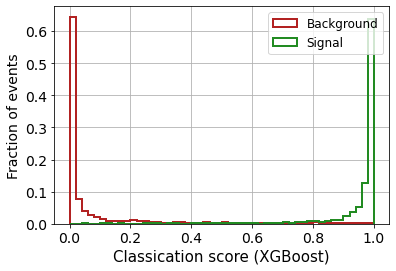


 ROC-AUC =  0.9921819696298598
At least 5 B events per bin, range = [[0, 1]]:
# bins:  14 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
max number of bins allowed:  14
range of our data:  [[0, 1]]
number of bins we are going to use:  10
B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3275


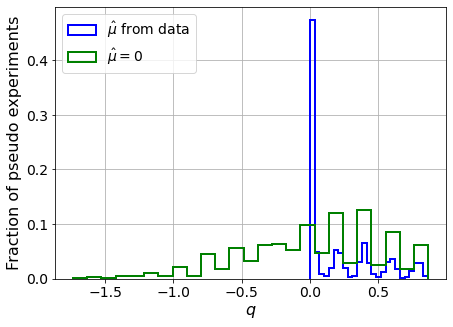

muhat mean:  0.4183110601390369
Z_bins:  0.2169860640665531
std Z_bins:  0.603436517438415
Z_bins mu=0:  0.20361486219484257
std Z_bins mu=0:  1.248662888365894

--------

B_expected:  643
S_expected:  2

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3285


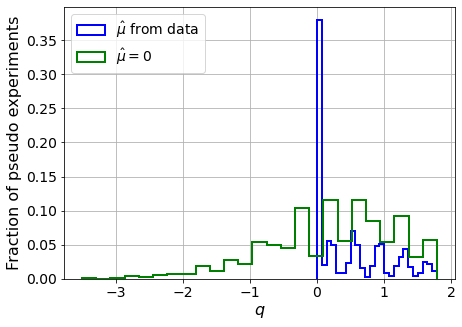

muhat mean:  0.1572518343740459
Z_bins:  0.5241521018630092
std Z_bins:  0.5180145805519412
Z_bins mu=0:  0.5222723417799048
std Z_bins mu=0:  0.8984028715285597

--------

B_expected:  643
S_expected:  3

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.313


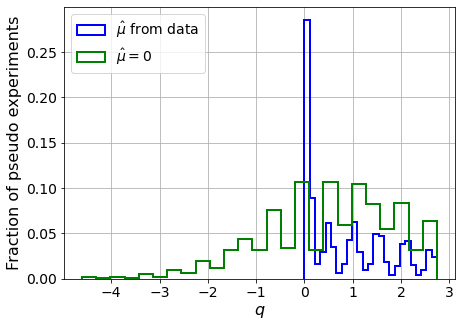

muhat mean:  0.11547819076948576
Z_bins:  0.7681320230977216
std Z_bins:  0.55122457996444
Z_bins mu=0:  0.7657880645806338
std Z_bins mu=0:  0.8770813398450165

--------

B_expected:  643
S_expected:  6

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3265


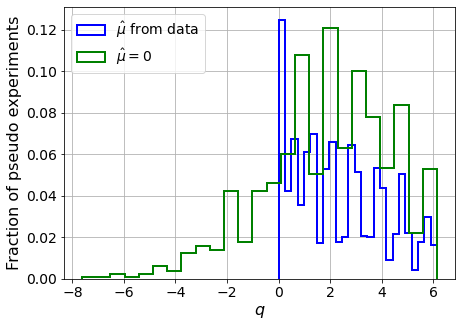

muhat mean:  0.0797068728575142
Z_bins:  1.4366134652129068
std Z_bins:  0.6049021278643607
Z_bins mu=0:  1.4334084085560759
std Z_bins mu=0:  0.8429522034225041

--------

B_expected:  643
S_expected:  12

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.332


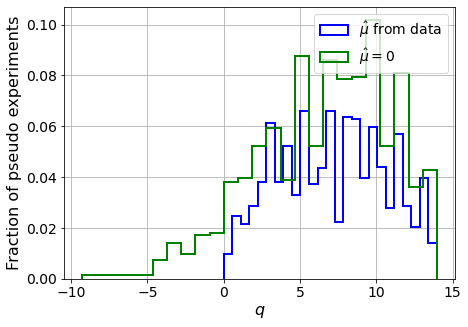

muhat mean:  0.041815877565392
Z_bins:  2.657631288861697
std Z_bins:  0.6569473120906307
Z_bins mu=0:  2.6565989444483673
std Z_bins mu=0:  0.8122195882063988

--------

B_expected:  643
S_expected:  23

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3335


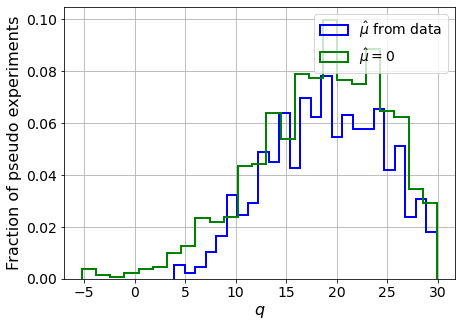

muhat mean:  0.025038487429581136
Z_bins:  4.369385264715543
std Z_bins:  0.6346358153994955
Z_bins mu=0:  4.368288244119656
std Z_bins mu=0:  0.7323309654655994

--------

B_expected:  643
S_expected:  44

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.327


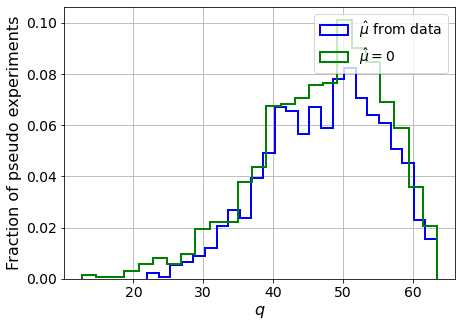

muhat mean:  0.009929736078896335
Z_bins:  6.94842051551705
std Z_bins:  0.5876012895317816
Z_bins mu=0:  6.948235443100489
std Z_bins mu=0:  0.6474279390638761

--------

B_expected:  643
S_expected:  85

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.321


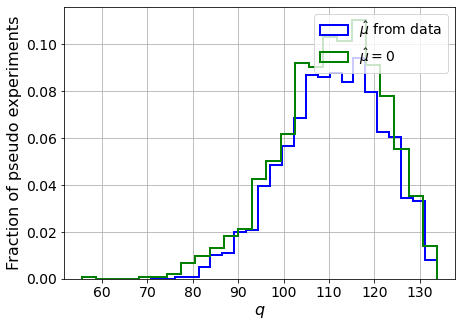

muhat mean:  0.0037795104913886206
Z_bins:  10.55869012941919
std Z_bins:  0.5096693151536245
Z_bins mu=0:  10.558508620752278
std Z_bins mu=0:  0.5432069040764559

--------

B_expected:  643
S_expected:  165

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.32


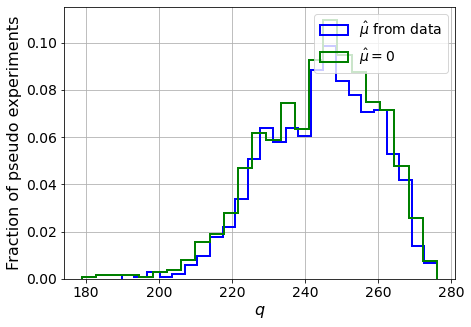

muhat mean:  0.002868201938410505
Z_bins:  15.67417768191943
std Z_bins:  0.47375678216629225
Z_bins mu=0:  15.673088447250725
std Z_bins mu=0:  0.4992717511372269

--------

B_expected:  643
S_expected:  318

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3185


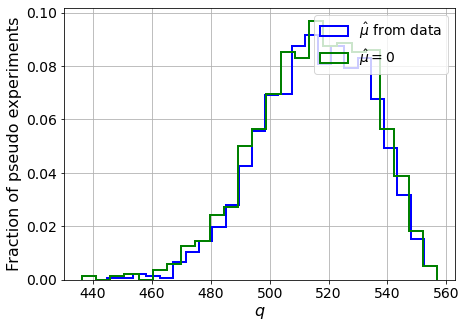

muhat mean:  0.0012592652567647894
Z_bins:  22.72494406992696
std Z_bins:  0.4080207671192241
Z_bins mu=0:  22.723169879988145
std Z_bins mu=0:  0.4239701351537054

--------

B_expected:  643
S_expected:  615

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.321


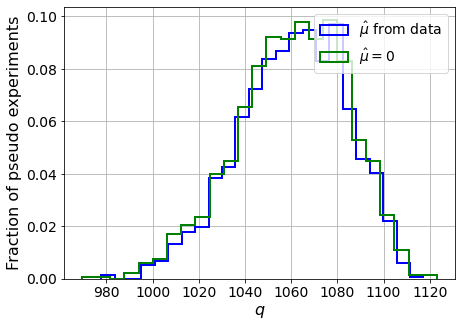

muhat mean:  0.0007232924661669634
Z_bins:  32.59627664941477
std Z_bins:  0.3542581225558364
Z_bins mu=0:  32.59448606027094
std Z_bins mu=0:  0.36458638276798383

--------

B_expected:  643
S_expected:  1187

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3215


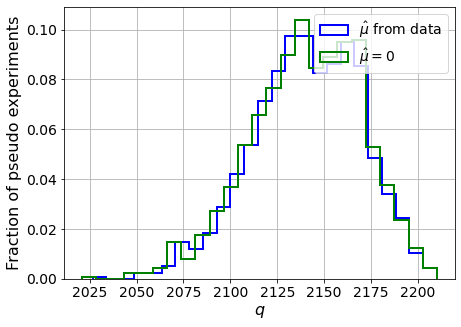

muhat mean:  0.0003893297837577947
Z_bins:  46.27663085243913
std Z_bins:  0.31016689011366616
Z_bins mu=0:  46.273100638484316
std Z_bins mu=0:  0.31773581952103114

--------

B_expected:  643
S_expected:  2291

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3395


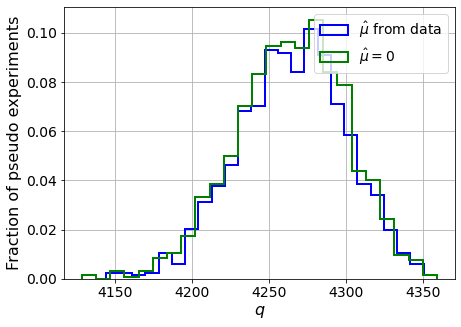

muhat mean:  0.00012620914131755576
Z_bins:  65.31515488362881
std Z_bins:  0.26844450261472497
Z_bins mu=0:  65.31388320018459
std Z_bins mu=0:  0.27317085639718125

--------

B_expected:  643
S_expected:  4424

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3365


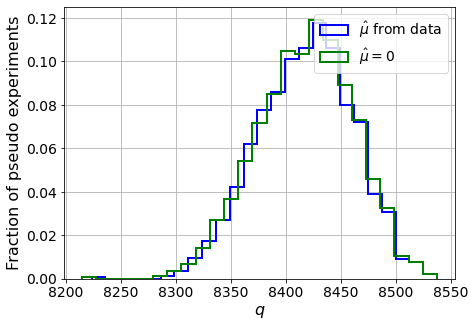

muhat mean:  0.00011426016481841207
Z_bins:  91.76234730254629
std Z_bins:  0.2347392870778544
Z_bins mu=0:  91.76224018885694
std Z_bins mu=0:  0.23826754451648613

--------

B_expected:  643
S_expected:  8542

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3265


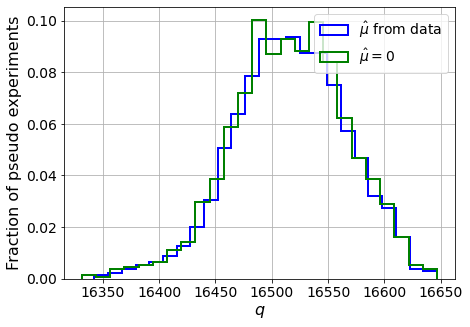

muhat mean:  4.519345519638329e-05
Z_bins:  128.5193852086895
std Z_bins:  0.19426137485832604
Z_bins mu=0:  128.51790923037365
std Z_bins mu=0:  0.19645899375599946

--------


 FINAL RESULT:

[[0.2169860640665531, 0.603436517438415, 0.4183110601390369, 0.20361486219484257, 1.248662888365894], [0.5241521018630092, 0.5180145805519412, 0.1572518343740459, 0.5222723417799048, 0.8984028715285597], [0.7681320230977216, 0.55122457996444, 0.11547819076948576, 0.7657880645806338, 0.8770813398450165], [1.4366134652129068, 0.6049021278643607, 0.0797068728575142, 1.4334084085560759, 0.8429522034225041], [2.657631288861697, 0.6569473120906307, 0.041815877565392, 2.6565989444483673, 0.8122195882063988], [4.369385264715543, 0.6346358153994955, 0.025038487429581136, 4.368288244119656, 0.7323309654655994], [6.94842051551705, 0.5876012895317816, 0.009929736078896335, 6.948235443100489, 0.6474279390638761], [10.55869012941919, 0.5096693151536245, 0.0037795104913886206, 10.558508620752278, 0.54320690407

/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [        -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf 327.50531538 284.65667611 233.74456415
 175.74328437 113.46637223  44.98077499 -22.58706811 -94.22967677]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:990: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [        -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf 383.77493943 337.02910634 283.77498469
 220

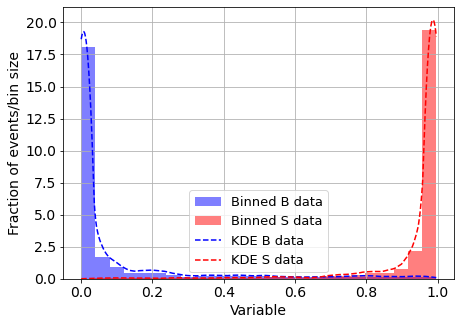

KDE Kernel:  epanechnikov
Background bandwidth:  0.03613222756796251
Signal bandwidth:  0.03613222756796251
This may take a while...
1 done
2 done
B_expected:  643
S_expected:  1



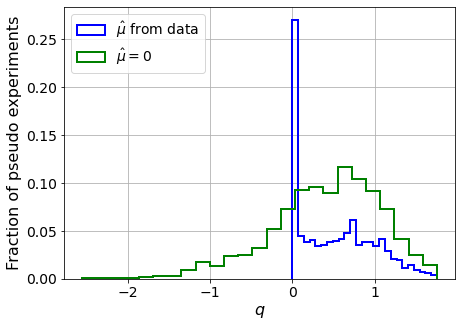

muhat mean:  -4.982554301992687
Z_bins:  0.6960834573319511
std Z_bins:  0.33295206247650416
Z_bins mu=0:  0.6960834573319511
std Z_bins mu=0:  0.4752858625209834

--------

B_expected:  643
S_expected:  2



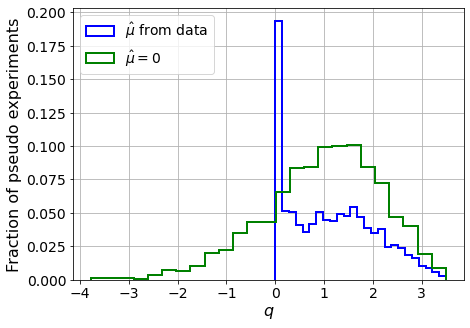

muhat mean:  -2.5369535650336013
Z_bins:  1.0445203494090964
std Z_bins:  0.4314851618878852
Z_bins mu=0:  1.0445203494090964
std Z_bins mu=0:  0.5666946992264243

--------

B_expected:  643
S_expected:  3



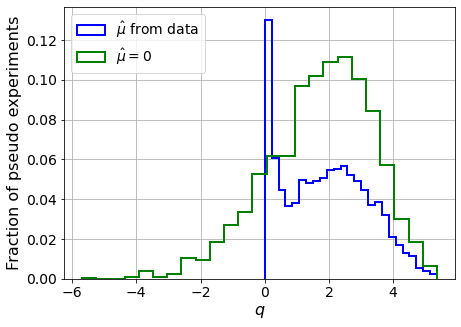

muhat mean:  -1.5179832258347963
Z_bins:  1.378537110313603
std Z_bins:  0.47648859263337057
Z_bins mu=0:  1.378537110313603
std Z_bins mu=0:  0.5936562867276606

--------

B_expected:  643
S_expected:  6



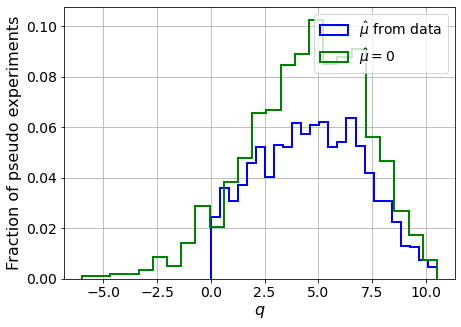

muhat mean:  -0.986576740611362
Z_bins:  2.166863885411496
std Z_bins:  0.5545154173030119
Z_bins mu=0:  2.166863885411496
std Z_bins mu=0:  0.63043145671121

--------

B_expected:  643
S_expected:  12



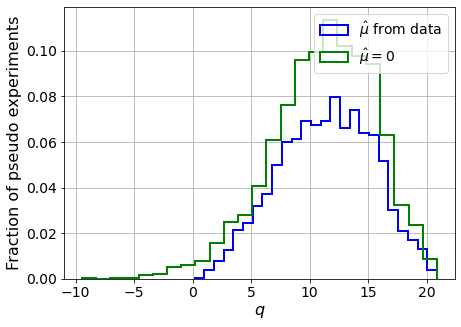

muhat mean:  -0.4161738363061436
Z_bins:  3.4104436415860913
std Z_bins:  0.5899981629456259
Z_bins mu=0:  3.4104436415860913
std Z_bins mu=0:  0.648318771155373

--------

B_expected:  643
S_expected:  23



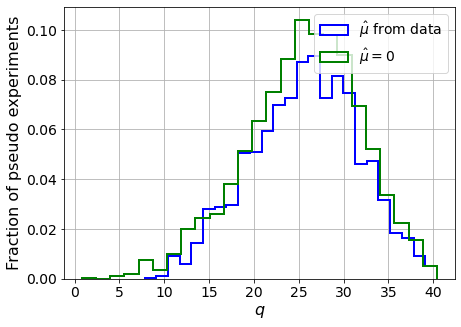

muhat mean:  -0.2225931069139695
Z_bins:  5.089173616534311
std Z_bins:  0.5871549818739092
Z_bins mu=0:  5.089173616534311
std Z_bins mu=0:  0.6248621987692438

--------

B_expected:  643
S_expected:  44



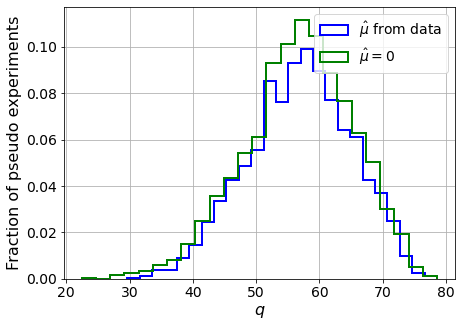

muhat mean:  -0.1027384935219305
Z_bins:  7.568122549026269
std Z_bins:  0.5413252832437742
Z_bins mu=0:  7.568122549026269
std Z_bins mu=0:  0.5648116834651631

--------

B_expected:  643
S_expected:  85



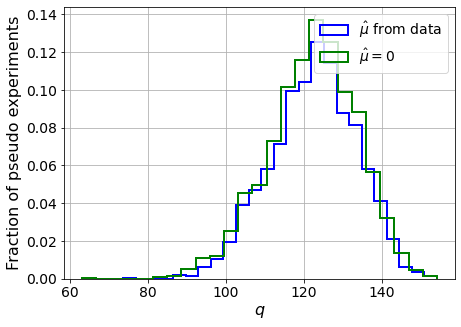

muhat mean:  -0.0661924145366805
Z_bins:  11.085683671813316
std Z_bins:  0.49777341439647194
Z_bins mu=0:  11.085683671813316
std Z_bins mu=0:  0.5138874720423032

--------

B_expected:  643
S_expected:  165



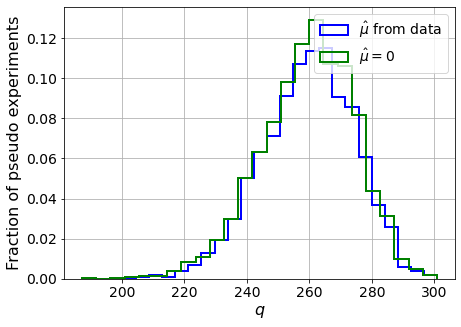

muhat mean:  -0.03748147508082381
Z_bins:  16.14643260519936
std Z_bins:  0.4577179457748751
Z_bins mu=0:  16.14643260519936
std Z_bins mu=0:  0.46961383956137775

--------

B_expected:  643
S_expected:  318



/home/andres/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


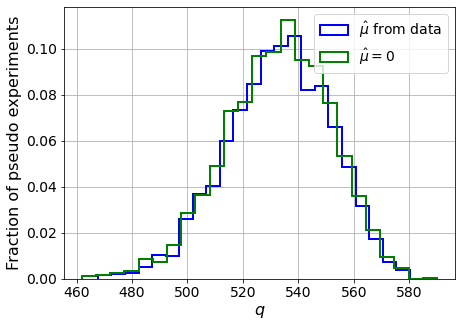

muhat mean:  -0.012868327214774886
Z_bins:  23.102700929262753
std Z_bins:  0.4059548695869348
Z_bins mu=0:  23.102700929262753
std Z_bins mu=0:  0.41294425077047187

--------

B_expected:  643
S_expected:  615



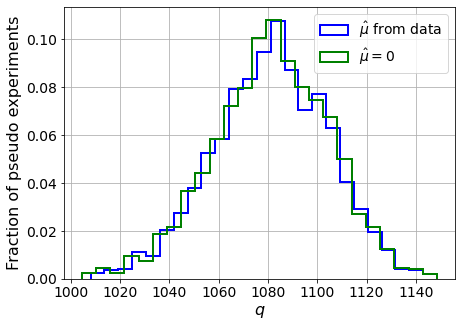

muhat mean:  -0.007397399754253082
Z_bins:  32.88868205085684
std Z_bins:  0.3541712215029164
Z_bins mu=0:  32.88757003691166
std Z_bins mu=0:  0.35866363011628727

--------

B_expected:  643
S_expected:  1187



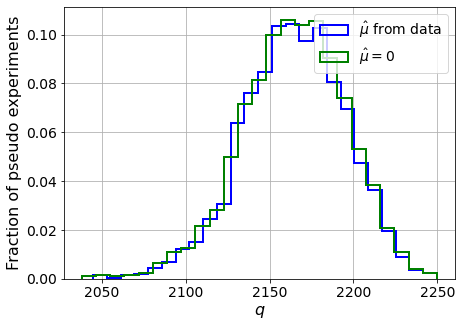

muhat mean:  -0.003797504866273755
Z_bins:  46.533685477635366
std Z_bins:  0.32992329691064864
Z_bins mu=0:  46.533155998934674
std Z_bins mu=0:  0.33351512818712364

--------

B_expected:  643
S_expected:  2291



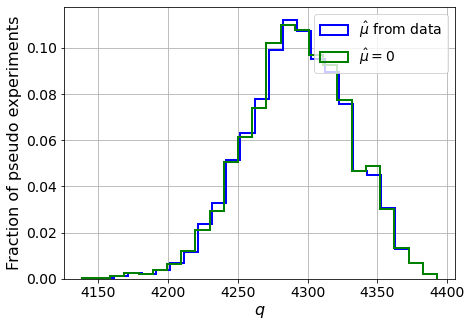

muhat mean:  -0.0018452069849720937
Z_bins:  65.52251409876172
std Z_bins:  0.28366483191068625
Z_bins mu=0:  65.52219030821841
std Z_bins mu=0:  0.2859472472546147

--------

B_expected:  643
S_expected:  4424



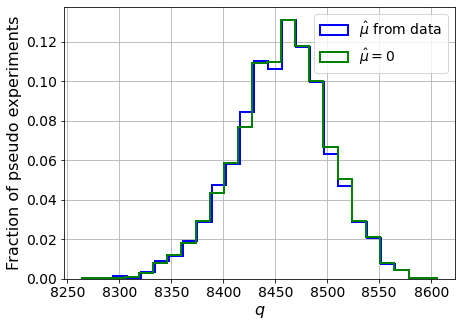

muhat mean:  -0.0011734395990722914
Z_bins:  91.96976760649966
std Z_bins:  0.24734358036975798
Z_bins mu=0:  91.9694553883103
std Z_bins mu=0:  0.24850427005895798

--------

B_expected:  643
S_expected:  8542



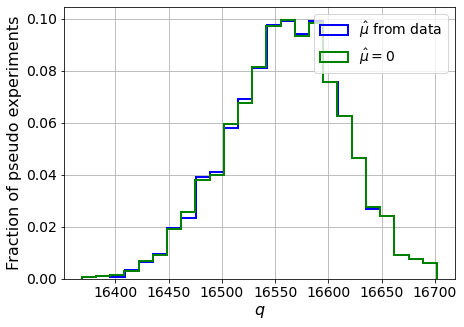

muhat mean:  -0.0005875453744695185
Z_bins:  128.69281163818874
std Z_bins:  0.2089254443786732
Z_bins mu=0:  128.69217474248288
std Z_bins mu=0:  0.20981119921416605

--------


 FINAL RESULT:

[[0.6960834573319511, 0.33295206247650416, -4.982554301992687, 0.6960834573319511, 0.4752858625209834], [1.0445203494090964, 0.4314851618878852, -2.5369535650336013, 1.0445203494090964, 0.5666946992264243], [1.378537110313603, 0.47648859263337057, -1.5179832258347963, 1.378537110313603, 0.5936562867276606], [2.166863885411496, 0.5545154173030119, -0.986576740611362, 2.166863885411496, 0.63043145671121], [3.4104436415860913, 0.5899981629456259, -0.4161738363061436, 3.4104436415860913, 0.648318771155373], [5.089173616534311, 0.5871549818739092, -0.2225931069139695, 5.089173616534311, 0.6248621987692438], [7.568122549026269, 0.5413252832437742, -0.1027384935219305, 7.568122549026269, 0.5648116834651631], [11.085683671813316, 0.49777341439647194, -0.0661924145366805, 11.085683671813316, 0.513887472

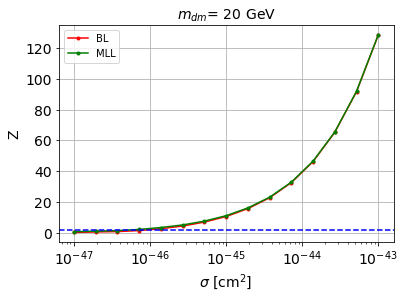


cross_BL_164:  8.030353418633125e-47
cross_BL_164_up:  4.99214987683996e-47
cross_BL_164_down:  1.1342286643969094e-46

cross_MLL_164:  4.636506814143082e-47
cross_MLL_164_up:  2.5664757620599847e-47
cross_MLL_164_down:  7.30604645624313e-47

#########################


#########################

mDM =  35 GeV


S_cs1.shape:  (33697,)
S_cs2.shape:  (33697,)
 NUM_DAT:  33084 

NUM_DAT_ER:  32663
NUM_DAT_AC:  116
NUM_DAT_CNNS:  1
NUM_DAT_RN:  30
NUM_DAT_WALL:  274

B_cs1cs2.shape:  (33084, 2)

S_cs1cs2.shape:  (33084, 2)


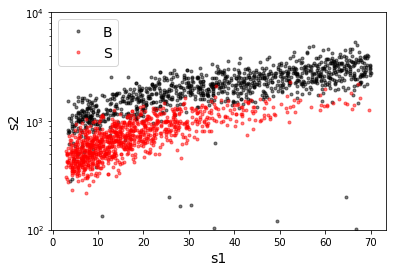

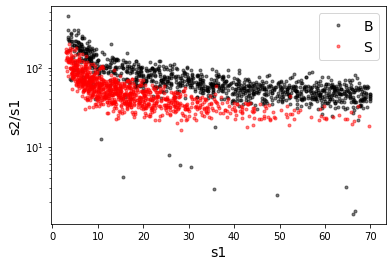

X_mon_B.shape:  (33084, 2)
X_mon_S.shape:  (33084, 2)
X_mon.shape:  (66168, 2)

X_mon_train :  (42182, 2)
y_mon_train :  (42182,)
X_mon_val :  (7444, 2)
y_mon_val :  (7444,)
X_mon_test :  (16542, 2)
y_mon_test :  (16542,)

Classification score:


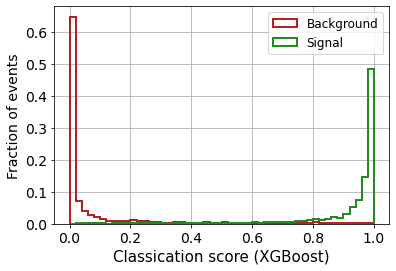


 ROC-AUC =  0.9857734047768516
At least 5 B events per bin, range = [[0, 1]]:
# bins:  14 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
max number of bins allowed:  14
range of our data:  [[0, 1]]
number of bins we are going to use:  10
B_expected:  643
S_expected:  2

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3175


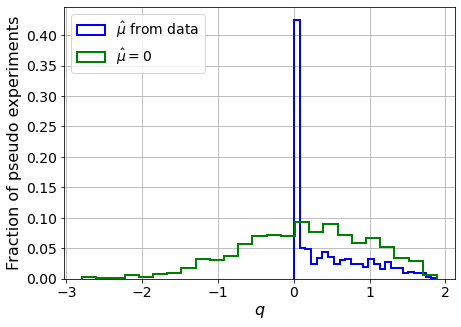

muhat mean:  0.2014031071783413
Z_bins:  0.4310019599481515
std Z_bins:  0.5752279078002746
Z_bins mu=0:  0.4280356003962078
std Z_bins mu=0:  0.9812970103387696

--------

B_expected:  643
S_expected:  3

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3135


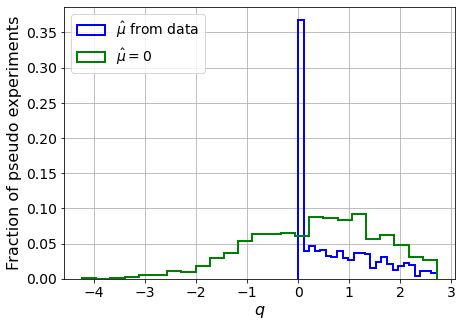

muhat mean:  0.16342548191765502
Z_bins:  0.676440506307857
std Z_bins:  0.5618377026693154
Z_bins mu=0:  0.6760332606381212
std Z_bins mu=0:  0.9135221110054532

--------

B_expected:  643
S_expected:  7

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3055


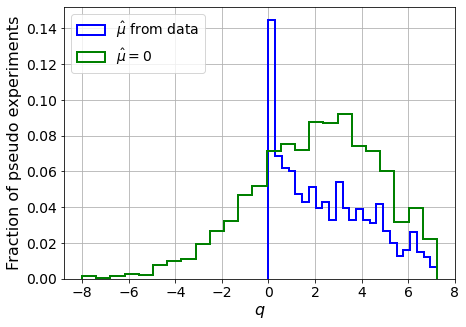

muhat mean:  0.06793984222292773
Z_bins:  1.4831115112796673
std Z_bins:  0.6597317853364913
Z_bins mu=0:  1.4814590649071213
std Z_bins mu=0:  0.9057880698483997

--------

B_expected:  643
S_expected:  13

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.2975


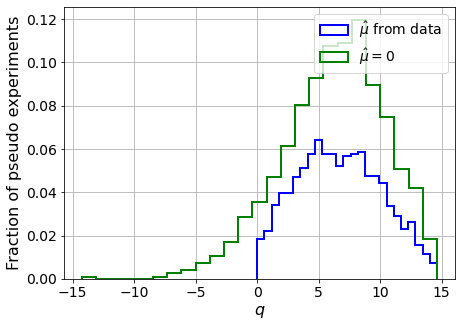

muhat mean:  0.029956195712137663
Z_bins:  2.5650909805779163
std Z_bins:  0.6611706909936006
Z_bins mu=0:  2.5644961310657592
std Z_bins mu=0:  0.8100135191176261

--------

B_expected:  643
S_expected:  25

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.289


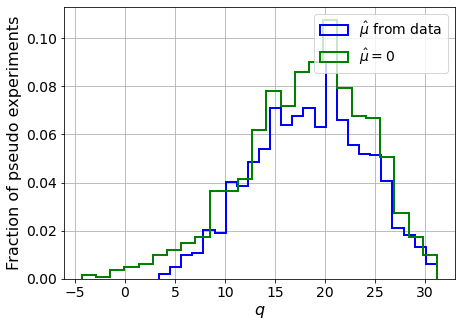

muhat mean:  0.008414054445683643
Z_bins:  4.314713716036954
std Z_bins:  0.6392249057159625
Z_bins mu=0:  4.314617831935559
std Z_bins mu=0:  0.7215292885297686

--------

B_expected:  643
S_expected:  48

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3025


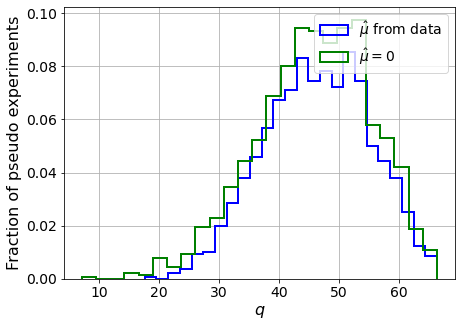

muhat mean:  0.00639521735950087
Z_bins:  6.8198849668120705
std Z_bins:  0.6402011380040284
Z_bins mu=0:  6.819212283190242
std Z_bins mu=0:  0.6962179752282652

--------

B_expected:  643
S_expected:  93

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.2905


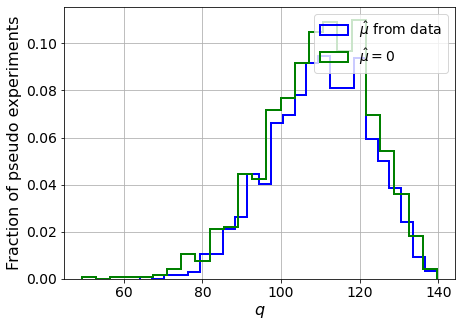

muhat mean:  0.004034060863639138
Z_bins:  10.519397128168597
std Z_bins:  0.5884831403005395
Z_bins mu=0:  10.518827711784413
std Z_bins mu=0:  0.6283066140994805

--------

B_expected:  643
S_expected:  179

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3265


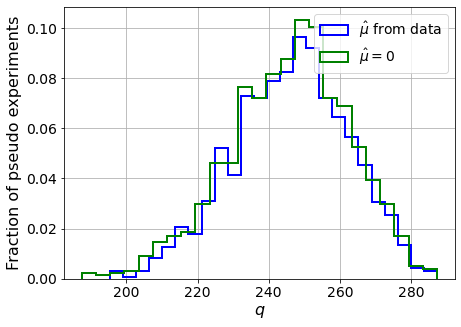

muhat mean:  0.0019165439593533359
Z_bins:  15.717179540368992
std Z_bins:  0.5124642806341225
Z_bins mu=0:  15.717179540368992
std Z_bins mu=0:  0.5347737026865403

--------

B_expected:  643
S_expected:  345

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.302


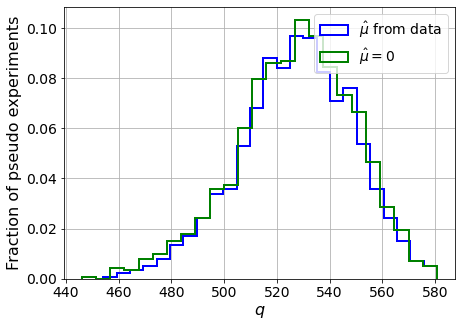

muhat mean:  0.0012366764737034108
Z_bins:  22.99274610770061
std Z_bins:  0.4667847569350424
Z_bins mu=0:  22.990446149642548
std Z_bins mu=0:  0.4841607713098658

--------

B_expected:  643
S_expected:  666

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.315


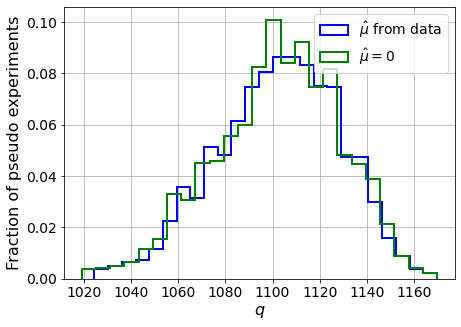

muhat mean:  0.0006132698898256578
Z_bins:  33.220051496232756
std Z_bins:  0.3905621372069915
Z_bins mu=0:  33.2183204172273
std Z_bins mu=0:  0.40074484673444183

--------

B_expected:  643
S_expected:  1286

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3155


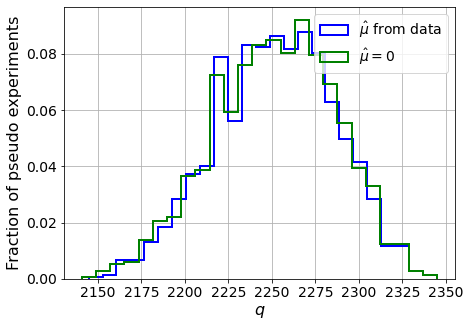

muhat mean:  0.00040749540551617876
Z_bins:  47.47101646021262
std Z_bins:  0.36190039409348934
Z_bins mu=0:  47.468723052566844
std Z_bins mu=0:  0.36909429569841296

--------

B_expected:  643
S_expected:  2484

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.307


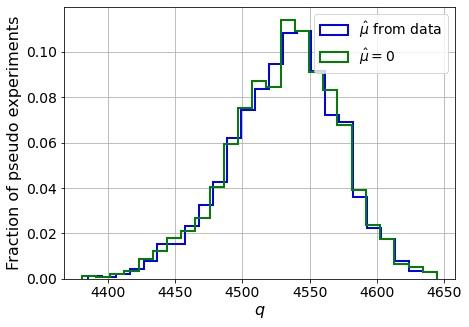

muhat mean:  0.00011771795538186318
Z_bins:  67.33873968071913
std Z_bins:  0.30101036747712706
Z_bins mu=0:  67.33780412970961
std Z_bins mu=0:  0.3053633062295629

--------

B_expected:  643
S_expected:  4795

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3225


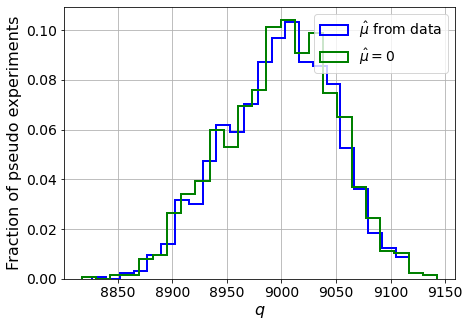

muhat mean:  0.00010303694291819385
Z_bins:  94.87702234842665
std Z_bins:  0.26574385704292464
Z_bins mu=0:  94.87405468761582
std Z_bins mu=0:  0.26897359294817363

--------

B_expected:  643
S_expected:  9258

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.308


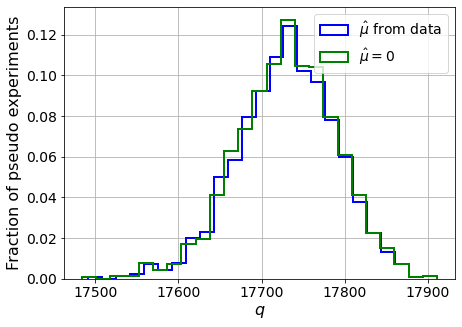

muhat mean:  4.590297507455041e-05
Z_bins:  133.16144399754143
std Z_bins:  0.22318254845237304
Z_bins mu=0:  133.16066763418576
std Z_bins mu=0:  0.22525630489740728

--------

B_expected:  643
S_expected:  17875

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3035


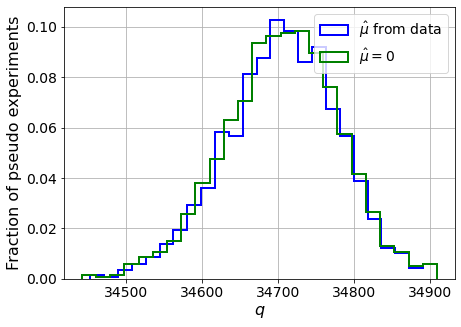

muhat mean:  2.1587771846666274e-05
Z_bins:  186.29979889721645
std Z_bins:  0.20003150601689296
Z_bins mu=0:  186.29814241063977
std Z_bins mu=0:  0.20135343212029477

--------


 FINAL RESULT:

[[0.4310019599481515, 0.5752279078002746, 0.2014031071783413, 0.4280356003962078, 0.9812970103387696], [0.676440506307857, 0.5618377026693154, 0.16342548191765502, 0.6760332606381212, 0.9135221110054532], [1.4831115112796673, 0.6597317853364913, 0.06793984222292773, 1.4814590649071213, 0.9057880698483997], [2.5650909805779163, 0.6611706909936006, 0.029956195712137663, 2.5644961310657592, 0.8100135191176261], [4.314713716036954, 0.6392249057159625, 0.008414054445683643, 4.314617831935559, 0.7215292885297686], [6.8198849668120705, 0.6402011380040284, 0.00639521735950087, 6.819212283190242, 0.6962179752282652], [10.519397128168597, 0.5884831403005395, 0.004034060863639138, 10.518827711784413, 0.6283066140994805], [15.717179540368992, 0.5124642806341225, 0.0019165439593533359, 15.717179540368992, 

/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [        -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf 367.86279997 328.04079314 283.89882408 231.9455771
 173.40541787 112.20688212  45.13443112 -25.36320285 -95.53061078]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:990: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [        -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf 269.40806869 227.89154104
 175.

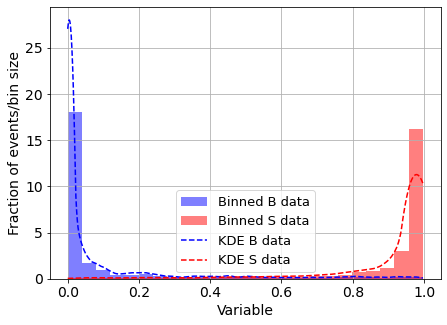

KDE Kernel:  epanechnikov
Background bandwidth:  0.022117541055781564
Signal bandwidth:  0.059027261020128646
This may take a while...
1 done
2 done
B_expected:  643
S_expected:  2



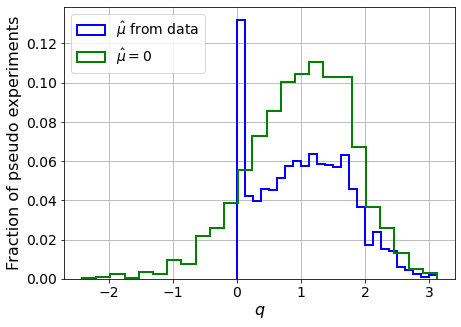

muhat mean:  -2.119884565553683
Z_bins:  1.0279838962880994
std Z_bins:  0.33835405881155184
Z_bins mu=0:  1.0279838962880994
std Z_bins mu=0:  0.39172905158473975

--------

B_expected:  643
S_expected:  3



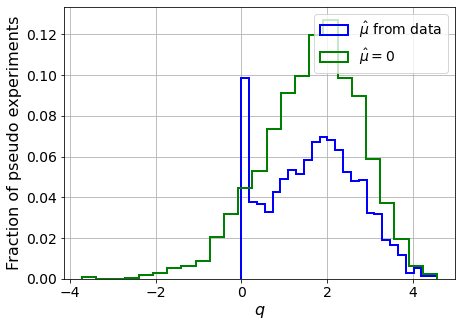

muhat mean:  -1.4642379528238567
Z_bins:  1.3201856887645287
std Z_bins:  0.38649714139891583
Z_bins mu=0:  1.3201856887645287
std Z_bins mu=0:  0.4365946478582129

--------

B_expected:  643
S_expected:  7



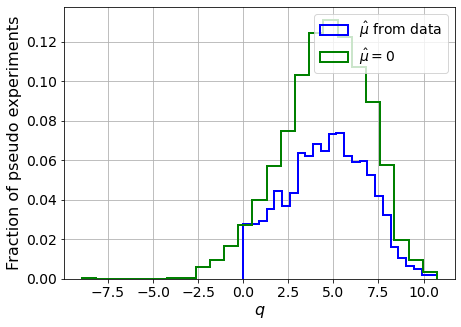

muhat mean:  -0.6462200162301743
Z_bins:  2.1723948738778085
std Z_bins:  0.5114436595220194
Z_bins mu=0:  2.1723948738778085
std Z_bins mu=0:  0.5512565335046732

--------

B_expected:  643
S_expected:  13



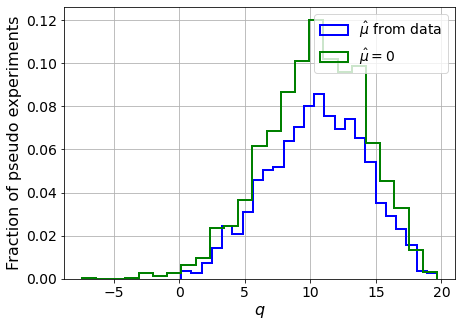

muhat mean:  -0.3333031351999945
Z_bins:  3.252771222489674
std Z_bins:  0.564999391396099
Z_bins mu=0:  3.252771222489674
std Z_bins mu=0:  0.5906565263992392

--------

B_expected:  643
S_expected:  25



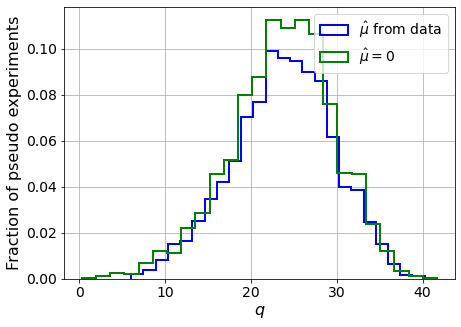

muhat mean:  -0.17648638555871504
Z_bins:  4.901399668787834
std Z_bins:  0.5948849741629972
Z_bins mu=0:  4.901399668787834
std Z_bins mu=0:  0.6148457899390753

--------

B_expected:  643
S_expected:  48



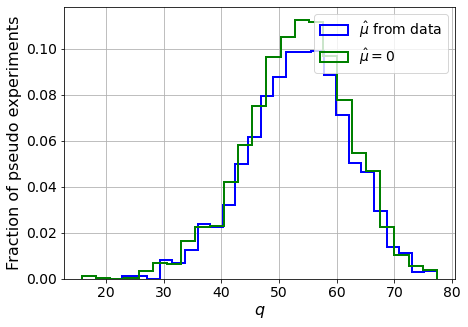

muhat mean:  -0.0847680357020817
Z_bins:  7.330230486978622
std Z_bins:  0.5958775289189917
Z_bins mu=0:  7.330230486978622
std Z_bins mu=0:  0.6103400313496348

--------

B_expected:  643
S_expected:  93



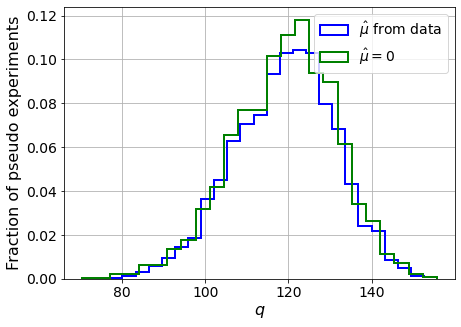

muhat mean:  -0.04243988213240052
Z_bins:  10.939399492710915
std Z_bins:  0.5557047173865531
Z_bins mu=0:  10.939399492710915
std Z_bins mu=0:  0.5653494345350097

--------

B_expected:  643
S_expected:  179



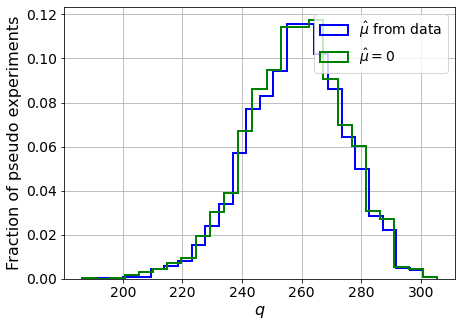

muhat mean:  -0.022654270809235974
Z_bins:  16.08824605182003
std Z_bins:  0.5080121949228008
Z_bins mu=0:  16.08824605182003
std Z_bins mu=0:  0.5134123675038617

--------

B_expected:  643
S_expected:  345



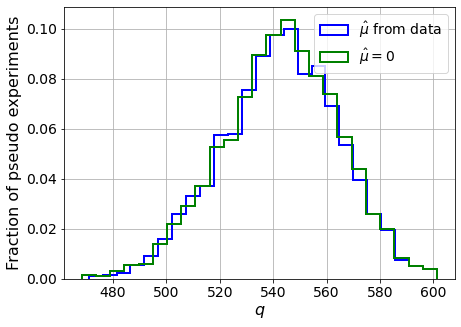

muhat mean:  -0.011203003754657867
Z_bins:  23.31419895334767
std Z_bins:  0.46403155736829954
Z_bins mu=0:  23.31419895334767
std Z_bins mu=0:  0.4673044225159008

--------

B_expected:  643
S_expected:  666



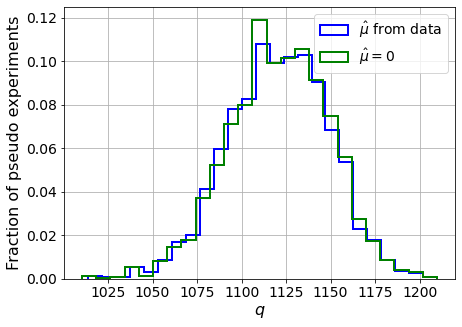

muhat mean:  -0.007234428373773439
Z_bins:  33.48391736042496
std Z_bins:  0.42231655020731834
Z_bins mu=0:  33.48368584784178
std Z_bins mu=0:  0.42455308089931987

--------

B_expected:  643
S_expected:  1286



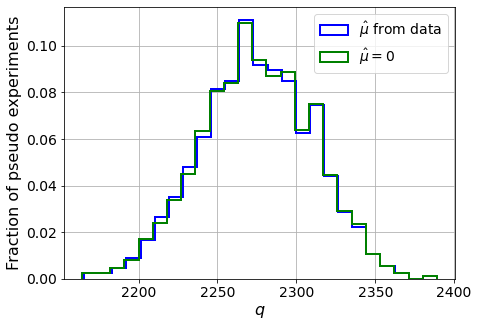

muhat mean:  -0.0034836407831911665
Z_bins:  47.69028578031138
std Z_bins:  0.368780565029357
Z_bins mu=0:  47.69028578031138
std Z_bins mu=0:  0.37002388209555825

--------

B_expected:  643
S_expected:  2484



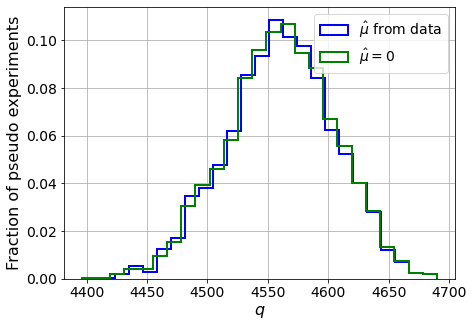

muhat mean:  -0.0017363631710827414
Z_bins:  67.53715105673729
std Z_bins:  0.3309755188497391
Z_bins mu=0:  67.53715105673729
std Z_bins mu=0:  0.33193647097741436

--------

B_expected:  643
S_expected:  4795



/home/andres/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


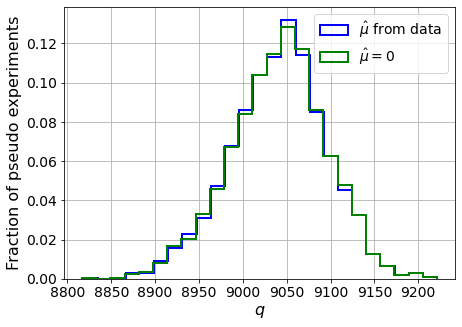

muhat mean:  -0.000807117042582664
Z_bins:  95.09556659556173
std Z_bins:  0.288659638557538
Z_bins mu=0:  95.09556659556173
std Z_bins mu=0:  0.2893448602447554

--------

B_expected:  643
S_expected:  9258



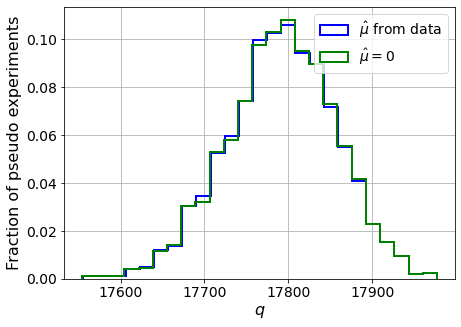

muhat mean:  -0.0004860586090886177
Z_bins:  133.39128782790632
std Z_bins:  0.24259174697562785
Z_bins mu=0:  133.39111168893015
std Z_bins mu=0:  0.24304703511377615

--------

B_expected:  643
S_expected:  17875



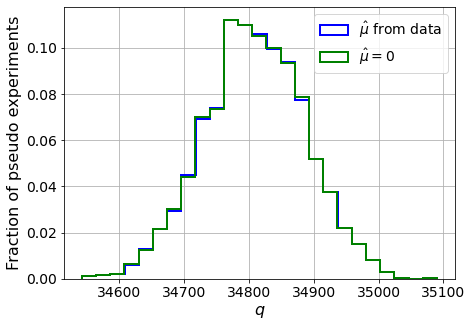

muhat mean:  -0.00024948013326132825
Z_bins:  186.56975916538934
std Z_bins:  0.2083944581237508
Z_bins mu=0:  186.56975916538934
std Z_bins mu=0:  0.20873946998165716

--------


 FINAL RESULT:

[[1.0279838962880994, 0.33835405881155184, -2.119884565553683, 1.0279838962880994, 0.39172905158473975], [1.3201856887645287, 0.38649714139891583, -1.4642379528238567, 1.3201856887645287, 0.4365946478582129], [2.1723948738778085, 0.5114436595220194, -0.6462200162301743, 2.1723948738778085, 0.5512565335046732], [3.252771222489674, 0.564999391396099, -0.3333031351999945, 3.252771222489674, 0.5906565263992392], [4.901399668787834, 0.5948849741629972, -0.17648638555871504, 4.901399668787834, 0.6148457899390753], [7.330230486978622, 0.5958775289189917, -0.0847680357020817, 7.330230486978622, 0.6103400313496348], [10.939399492710915, 0.5557047173865531, -0.04243988213240052, 10.939399492710915, 0.5653494345350097], [16.08824605182003, 0.5080121949228008, -0.022654270809235974, 16.08824605182003, 0.5

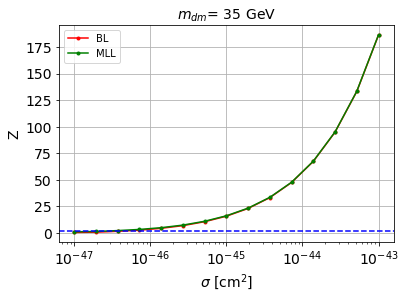


cross_BL_164:  4.100695577859679e-47
cross_BL_164_up:  2.7467616097410144e-47
cross_BL_164_down:  6.128548166976857e-47

cross_MLL_164:  2.471361178718406e-47
cross_MLL_164_up:  1.8459359951248977e-47
cross_MLL_164_down:  3.677891104702873e-47

#########################


#########################

mDM =  50 GeV


S_cs1.shape:  (35287,)
S_cs2.shape:  (35287,)
 NUM_DAT:  34105 

NUM_DAT_ER:  33671
NUM_DAT_AC:  119
NUM_DAT_CNNS:  1
NUM_DAT_RN:  31
NUM_DAT_WALL:  283

B_cs1cs2.shape:  (34105, 2)

S_cs1cs2.shape:  (34105, 2)


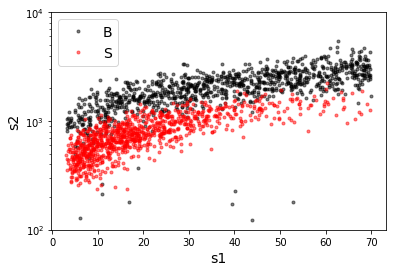

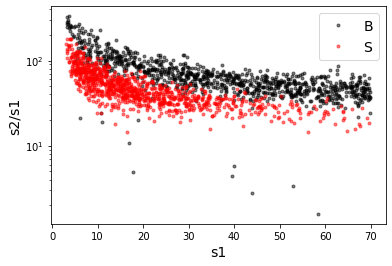

X_mon_B.shape:  (34105, 2)
X_mon_S.shape:  (34105, 2)
X_mon.shape:  (68210, 2)

X_mon_train :  (43483, 2)
y_mon_train :  (43483,)
X_mon_val :  (7674, 2)
y_mon_val :  (7674,)
X_mon_test :  (17053, 2)
y_mon_test :  (17053,)

Classification score:


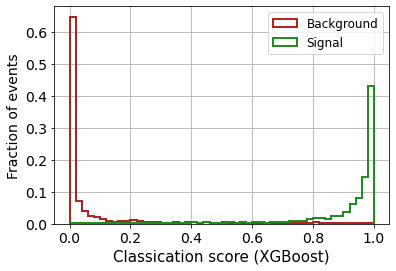


 ROC-AUC =  0.9827543528589057
At least 5 B events per bin, range = [[0, 1]]:
# bins:  14 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
max number of bins allowed:  14
range of our data:  [[0, 1]]
number of bins we are going to use:  10
B_expected:  643
S_expected:  2

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.282


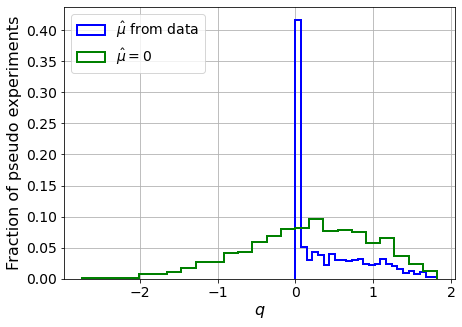

muhat mean:  0.11725749864762734
Z_bins:  0.4696259173877284
std Z_bins:  0.5153041629156249
Z_bins mu=0:  0.4696259173877284
std Z_bins mu=0:  0.8674715298065692

--------

B_expected:  643
S_expected:  4

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.262


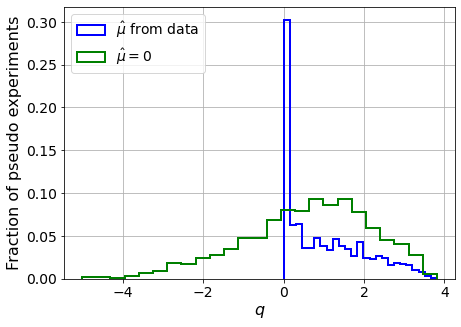

muhat mean:  0.12076182653581359
Z_bins:  0.873674710275225
std Z_bins:  0.5699421728826879
Z_bins mu=0:  0.8736256322217667
std Z_bins mu=0:  0.91031149870672

--------

B_expected:  643
S_expected:  7

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.296


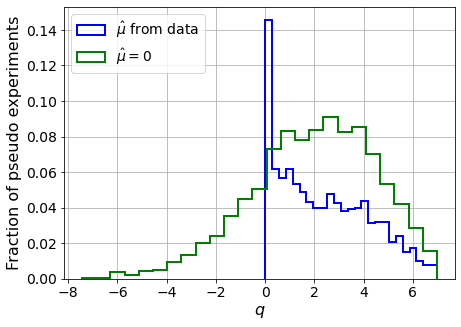

muhat mean:  0.03637685321897276
Z_bins:  1.4705753158118855
std Z_bins:  0.6281578794768753
Z_bins mu=0:  1.4705753158118855
std Z_bins mu=0:  0.8517778654469024

--------

B_expected:  643
S_expected:  14

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.284


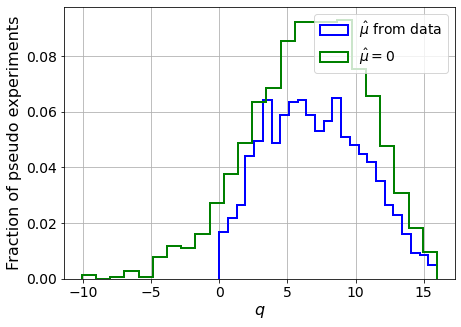

muhat mean:  0.02237705472888128
Z_bins:  2.6272296748048682
std Z_bins:  0.6755700231194343
Z_bins mu=0:  2.627212750789901
std Z_bins mu=0:  0.8118279266131528

--------

B_expected:  643
S_expected:  27

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.294


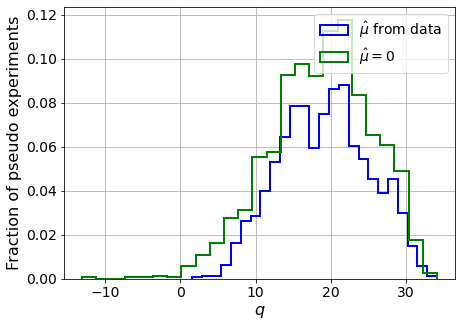

muhat mean:  0.014095512034050923
Z_bins:  4.3774912965883725
std Z_bins:  0.6790848028049868
Z_bins mu=0:  4.37515430035958
std Z_bins mu=0:  0.7675955287758247

--------

B_expected:  643
S_expected:  51

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.273


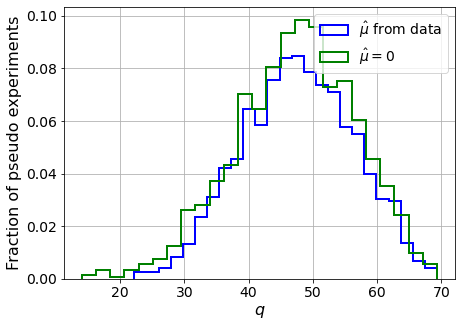

muhat mean:  0.006951567981518263
Z_bins:  6.912746155015442
std Z_bins:  0.627568523794613
Z_bins mu=0:  6.912119953031463
std Z_bins mu=0:  0.6787872259410898

--------

B_expected:  643
S_expected:  99

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.2755


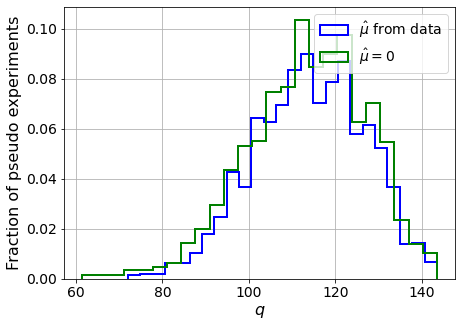

muhat mean:  0.005715560670645572
Z_bins:  10.68591385600315
std Z_bins:  0.5973343580586499
Z_bins mu=0:  10.684633412546
std Z_bins mu=0:  0.6374517788897381

--------

B_expected:  643
S_expected:  192

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.283


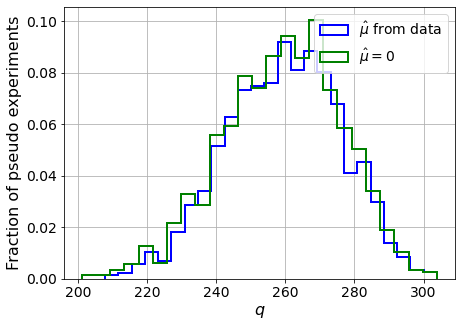

muhat mean:  0.0022584085974299093
Z_bins:  16.121043510453315
std Z_bins:  0.5114152829019256
Z_bins mu=0:  16.120700137216666
std Z_bins mu=0:  0.5323767971478927

--------

B_expected:  643
S_expected:  370

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.278


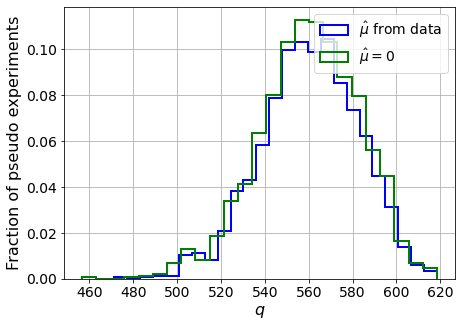

muhat mean:  0.0007982273877195773
Z_bins:  23.683774327351415
std Z_bins:  0.4692715150429902
Z_bins mu=0:  23.682889238995887
std Z_bins mu=0:  0.48569757042220274

--------

B_expected:  643
S_expected:  714

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.2865


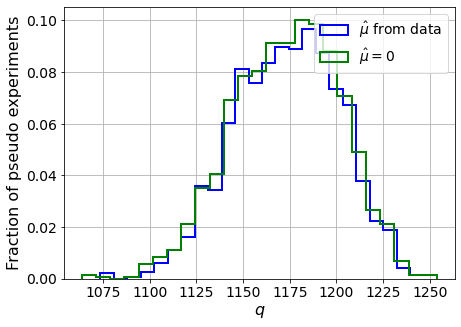

muhat mean:  0.0004842724457455814
Z_bins:  34.27146964071395
std Z_bins:  0.4097679244832462
Z_bins mu=0:  34.269139827818194
std Z_bins mu=0:  0.41947583780541436

--------

B_expected:  643
S_expected:  1378

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.293


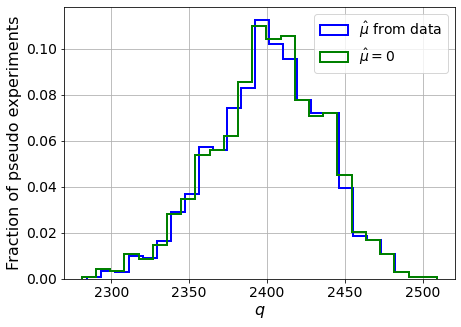

muhat mean:  0.00011907514677828978
Z_bins:  49.013977412003726
std Z_bins:  0.3601266359818121
Z_bins mu=0:  49.013615804072124
std Z_bins mu=0:  0.36632223526915675

--------

B_expected:  643
S_expected:  2661

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.293


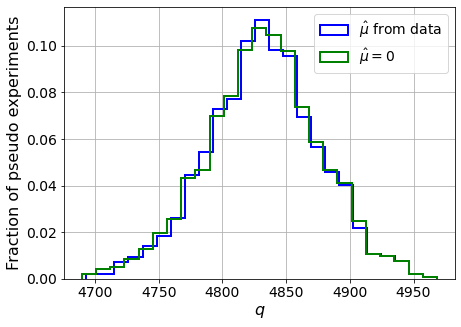

muhat mean:  0.00016148515363498085
Z_bins:  69.51530048604727
std Z_bins:  0.3166764067663113
Z_bins mu=0:  69.51446858167675
std Z_bins mu=0:  0.3208849284869114

--------

B_expected:  643
S_expected:  5138

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.305


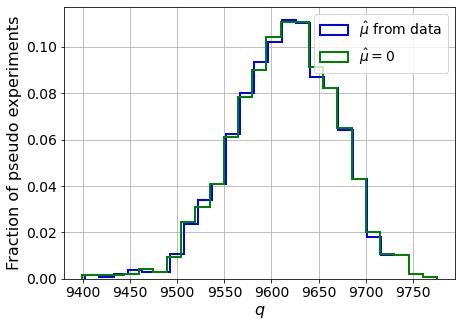

muhat mean:  8.22515437216304e-05
Z_bins:  98.06067983656709
std Z_bins:  0.2754188238915383
Z_bins mu=0:  98.05983849338091
std Z_bins mu=0:  0.2784350053862689

--------

B_expected:  643
S_expected:  9921

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.293


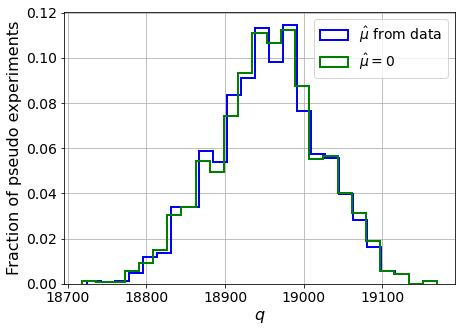

muhat mean:  2.5065598891611428e-05
Z_bins:  137.6805111992902
std Z_bins:  0.24542250922460931
Z_bins mu=0:  137.67976222880205
std Z_bins mu=0:  0.24728426874630938

--------

B_expected:  643
S_expected:  19154

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.2695


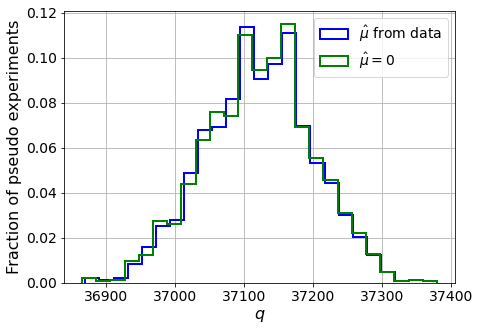

muhat mean:  1.8008600681583512e-05
Z_bins:  192.67633924192944
std Z_bins:  0.20236899111867424
Z_bins mu=0:  192.67532219195442
std Z_bins mu=0:  0.20358460443424367

--------


 FINAL RESULT:

[[0.4696259173877284, 0.5153041629156249, 0.11725749864762734, 0.4696259173877284, 0.8674715298065692], [0.873674710275225, 0.5699421728826879, 0.12076182653581359, 0.8736256322217667, 0.91031149870672], [1.4705753158118855, 0.6281578794768753, 0.03637685321897276, 1.4705753158118855, 0.8517778654469024], [2.6272296748048682, 0.6755700231194343, 0.02237705472888128, 2.627212750789901, 0.8118279266131528], [4.3774912965883725, 0.6790848028049868, 0.014095512034050923, 4.37515430035958, 0.7675955287758247], [6.912746155015442, 0.627568523794613, 0.006951567981518263, 6.912119953031463, 0.6787872259410898], [10.68591385600315, 0.5973343580586499, 0.005715560670645572, 10.684633412546, 0.6374517788897381], [16.121043510453315, 0.5114152829019256, 0.0022584085974299093, 16.120700137216666, 0.532376

/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [        -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf 313.67040054 269.1227569  218.40229508
 162.09008752 101.81553166  37.767429   -29.68530899 -97.49004586]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:990: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [        -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf 246.08574438 208.71899446
 162

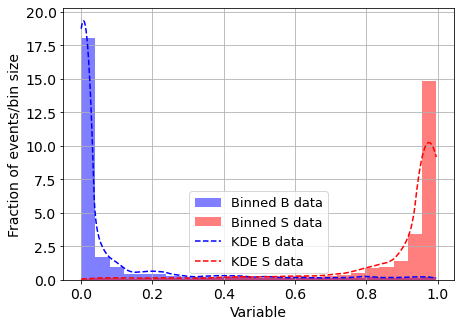

KDE Kernel:  epanechnikov
Background bandwidth:  0.03613222756796251
Signal bandwidth:  0.059027261020128646
This may take a while...
1 done
2 done
B_expected:  643
S_expected:  2



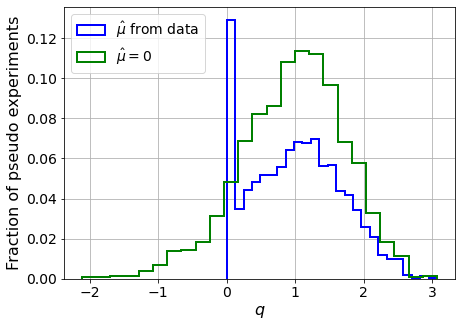

muhat mean:  -2.180062644858115
Z_bins:  1.0090451913307212
std Z_bins:  0.32705007150438875
Z_bins mu=0:  1.0090451913307212
std Z_bins mu=0:  0.37640836461770516

--------

B_expected:  643
S_expected:  4



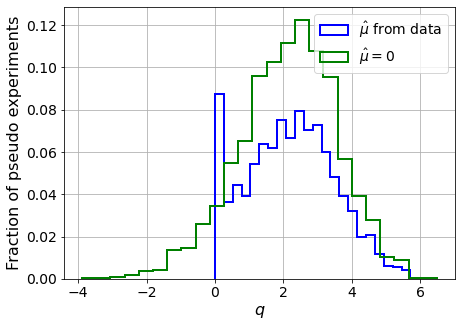

muhat mean:  -1.1644665790252393
Z_bins:  1.4851108780167483
std Z_bins:  0.4352065610302905
Z_bins mu=0:  1.4851108780167483
std Z_bins mu=0:  0.48278736816064344

--------

B_expected:  643
S_expected:  7



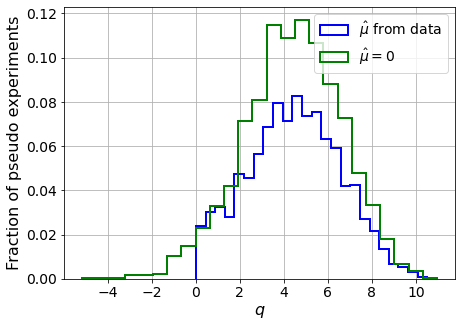

muhat mean:  -0.6434844270503599
Z_bins:  2.113117733193416
std Z_bins:  0.4995646364301174
Z_bins mu=0:  2.113117733193416
std Z_bins mu=0:  0.5289055831070494

--------

B_expected:  643
S_expected:  14



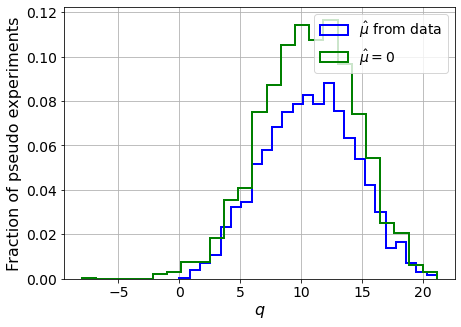

muhat mean:  -0.3266598102494587
Z_bins:  3.2726171143427885
std Z_bins:  0.5722804656285291
Z_bins mu=0:  3.2726171143427885
std Z_bins mu=0:  0.5909087055802787

--------

B_expected:  643
S_expected:  27



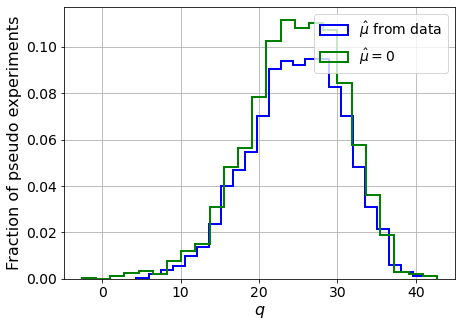

muhat mean:  -0.16836389363811582
Z_bins:  5.0075563355815405
std Z_bins:  0.6003824019290579
Z_bins mu=0:  5.0075563355815405
std Z_bins mu=0:  0.6194643170004523

--------

B_expected:  643
S_expected:  51



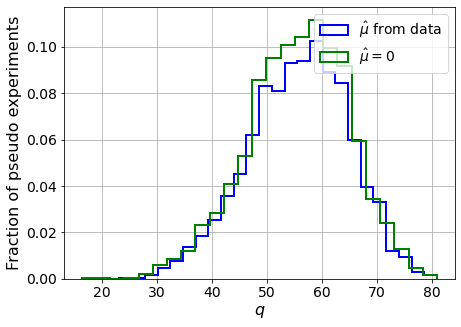

muhat mean:  -0.09424422268274685
Z_bins:  7.495456669144286
std Z_bins:  0.6050381885888672
Z_bins mu=0:  7.495456669144286
std Z_bins mu=0:  0.6163876066508799

--------

B_expected:  643
S_expected:  99



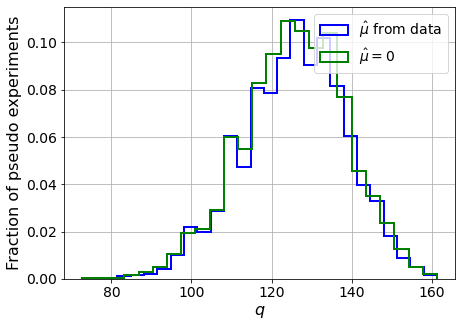

muhat mean:  -0.04563105957293067
Z_bins:  11.223335246591825
std Z_bins:  0.5726525750367469
Z_bins mu=0:  11.223335246591825
std Z_bins mu=0:  0.5795274363087519

--------

B_expected:  643
S_expected:  192



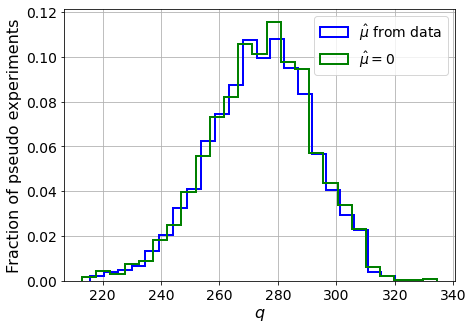

muhat mean:  -0.026068360941532184
Z_bins:  16.581916622137168
std Z_bins:  0.5334094263485774
Z_bins mu=0:  16.581916622137168
std Z_bins mu=0:  0.538006942633883

--------

B_expected:  643
S_expected:  370



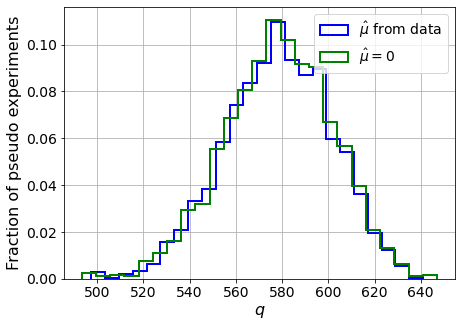

muhat mean:  -0.012902190844041393
Z_bins:  24.05997578061525
std Z_bins:  0.4815821245711787
Z_bins mu=0:  24.05997578061525
std Z_bins mu=0:  0.48467866262927506

--------

B_expected:  643
S_expected:  714



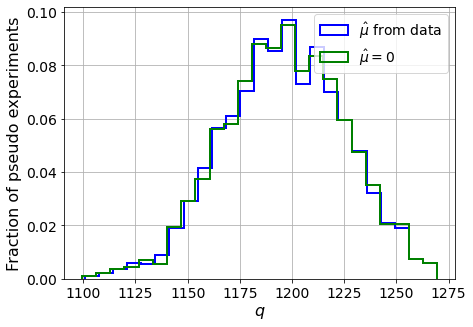

muhat mean:  -0.006139315676426369
Z_bins:  34.586698521442806
std Z_bins:  0.416243274460245
Z_bins mu=0:  34.586698521442806
std Z_bins mu=0:  0.4177832652692808

--------

B_expected:  643
S_expected:  1378



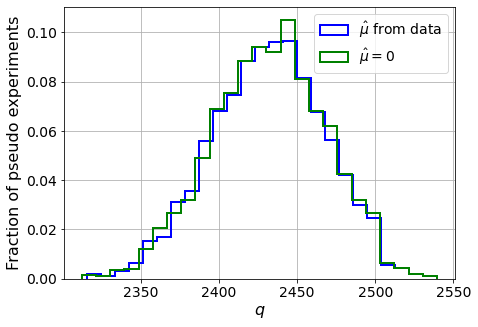

muhat mean:  -0.0031548884607585357
Z_bins:  49.32324640336555
std Z_bins:  0.3658306540390992
Z_bins mu=0:  49.32324640336555
std Z_bins mu=0:  0.3670894568057992

--------

B_expected:  643
S_expected:  2661



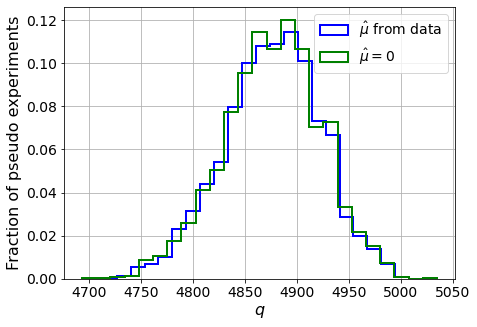

muhat mean:  -0.0016512557581439336
Z_bins:  69.84660778267748
std Z_bins:  0.33712578034571383
Z_bins mu=0:  69.84660778267748
std Z_bins mu=0:  0.338038766023557

--------

B_expected:  643
S_expected:  5138



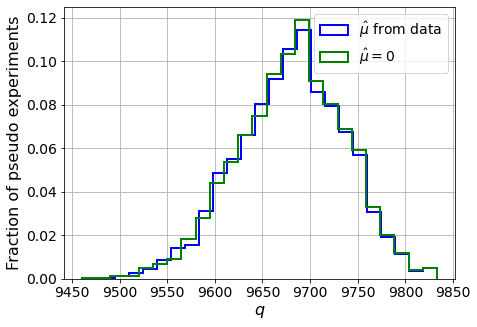

muhat mean:  -0.0009141037663078837
Z_bins:  98.40315297185757
std Z_bins:  0.28782470973615615
Z_bins mu=0:  98.40315297185757
std Z_bins mu=0:  0.2884375817747398

--------

B_expected:  643
S_expected:  9921



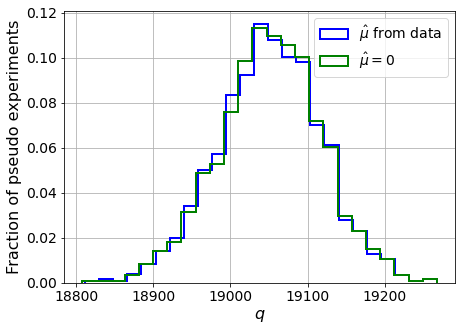

muhat mean:  -0.00043666839960655523
Z_bins:  138.02779052238137
std Z_bins:  0.2414877820517121
Z_bins mu=0:  138.0275658451003
std Z_bins mu=0:  0.24193389218614642

--------

B_expected:  643
S_expected:  19154



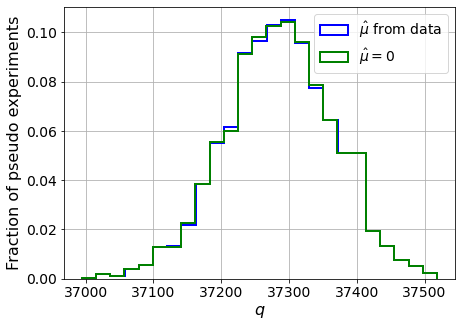

muhat mean:  -0.00023682439049735394
Z_bins:  193.09631788262894
std Z_bins:  0.20869544576049748
Z_bins mu=0:  193.09631788262894
std Z_bins mu=0:  0.20892604487823827

--------


 FINAL RESULT:

[[1.0090451913307212, 0.32705007150438875, -2.180062644858115, 1.0090451913307212, 0.37640836461770516], [1.4851108780167483, 0.4352065610302905, -1.1644665790252393, 1.4851108780167483, 0.48278736816064344], [2.113117733193416, 0.4995646364301174, -0.6434844270503599, 2.113117733193416, 0.5289055831070494], [3.2726171143427885, 0.5722804656285291, -0.3266598102494587, 3.2726171143427885, 0.5909087055802787], [5.0075563355815405, 0.6003824019290579, -0.16836389363811582, 5.0075563355815405, 0.6194643170004523], [7.495456669144286, 0.6050381885888672, -0.09424422268274685, 7.495456669144286, 0.6163876066508799], [11.223335246591825, 0.5726525750367469, -0.04563105957293067, 11.223335246591825, 0.5795274363087519], [16.581916622137168, 0.5334094263485774, -0.026068360941532184, 16.5819166221371

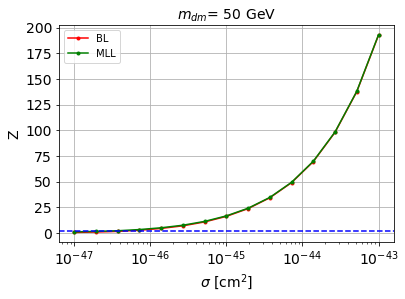


cross_BL_164:  4.1046817887235696e-47
cross_BL_164_up:  2.351594183827524e-47
cross_BL_164_down:  5.982280588355771e-47

cross_MLL_164:  2.270814845976436e-47
cross_MLL_164_up:  1.4792353862159966e-47
cross_MLL_164_down:  3.787751119928501e-47

#########################


#########################

mDM =  100 GeV


S_cs1.shape:  (37757,)
S_cs2.shape:  (37757,)
 NUM_DAT:  35163 

NUM_DAT_ER:  34715
NUM_DAT_AC:  123
NUM_DAT_CNNS:  1
NUM_DAT_RN:  32
NUM_DAT_WALL:  292

B_cs1cs2.shape:  (35163, 2)

S_cs1cs2.shape:  (35163, 2)


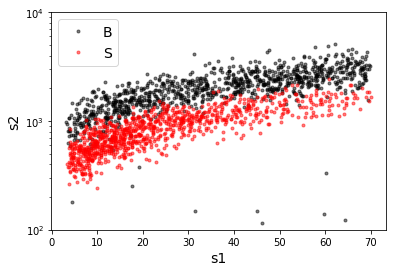

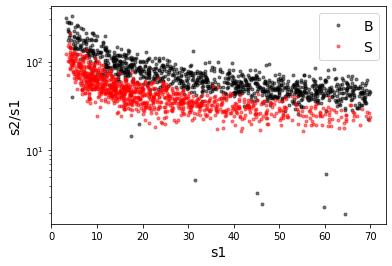

X_mon_B.shape:  (35163, 2)
X_mon_S.shape:  (35163, 2)
X_mon.shape:  (70326, 2)

X_mon_train :  (44832, 2)
y_mon_train :  (44832,)
X_mon_val :  (7912, 2)
y_mon_val :  (7912,)
X_mon_test :  (17582, 2)
y_mon_test :  (17582,)

Classification score:


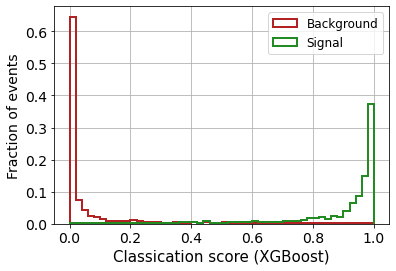


 ROC-AUC =  0.9805927203024729
At least 5 B events per bin, range = [[0, 1]]:
# bins:  14 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
max number of bins allowed:  14
range of our data:  [[0, 1]]
number of bins we are going to use:  10
B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.335


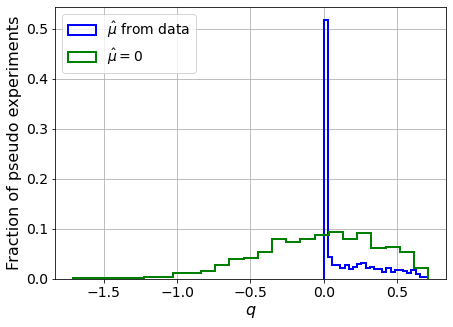

muhat mean:  0.8220129242120148
Z_bins:  0.13718658264404004
std Z_bins:  0.7066566972214371
Z_bins mu=0:  0.0790343602283238
std Z_bins mu=0:  2.5654144454434085

--------

B_expected:  643
S_expected:  3

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.338


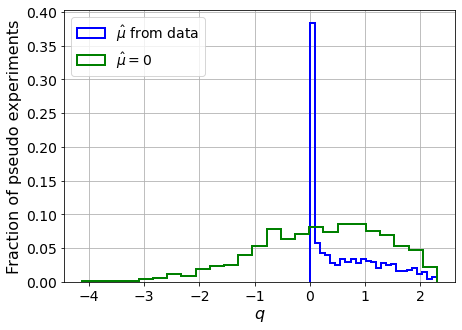

muhat mean:  0.29592576436335766
Z_bins:  0.5539380719392328
std Z_bins:  0.5882849378822501
Z_bins mu=0:  0.5316677903430462
std Z_bins mu=0:  1.0731856588445756

--------

B_expected:  643
S_expected:  5

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3565


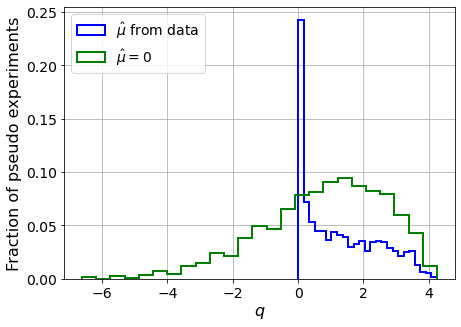

muhat mean:  0.17947489014920726
Z_bins:  1.0205324521151582
std Z_bins:  0.5692894927852874
Z_bins mu=0:  1.0115746197078126
std Z_bins mu=0:  0.9194776371362049

--------

B_expected:  643
S_expected:  10

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.328


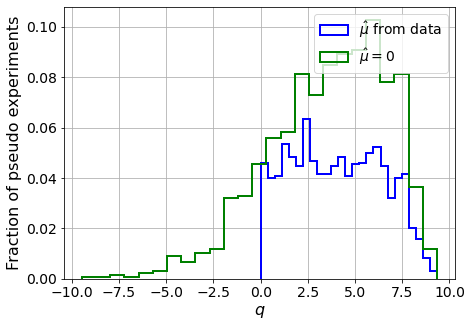

muhat mean:  0.06986626597062559
Z_bins:  2.0010776626990836
std Z_bins:  0.5920648194654098
Z_bins mu=0:  2.0008196727602097
std Z_bins mu=0:  0.7803613797048636

--------

B_expected:  643
S_expected:  19

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.329


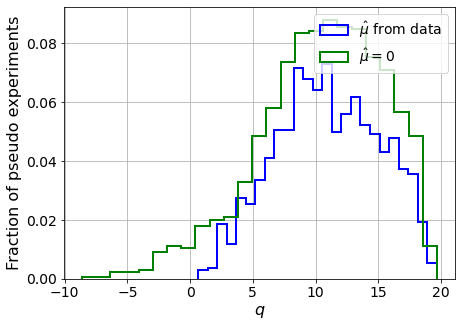

muhat mean:  0.04717682774836877
Z_bins:  3.297411577342312
std Z_bins:  0.6227325420332394
Z_bins mu=0:  3.2905057517132623
std Z_bins mu=0:  0.7518769602646845

--------

B_expected:  643
S_expected:  37

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.336


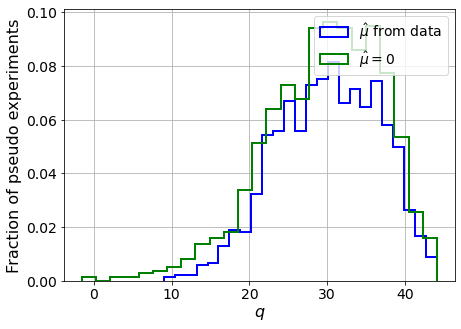

muhat mean:  0.020526973805914454
Z_bins:  5.509626274203501
std Z_bins:  0.5954738828735946
Z_bins mu=0:  5.508239091474605
std Z_bins mu=0:  0.6714295291741562

--------

B_expected:  643
S_expected:  72

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3405


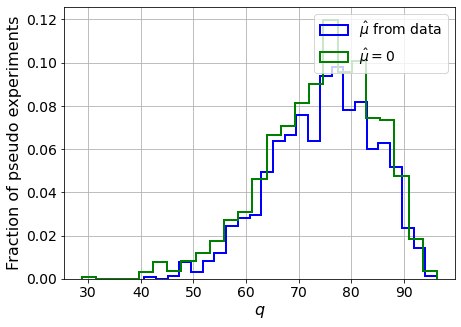

muhat mean:  0.010326839181587862
Z_bins:  8.70025756985737
std Z_bins:  0.5513605267178942
Z_bins mu=0:  8.700000500444704
std Z_bins mu=0:  0.5984993528657591

--------

B_expected:  643
S_expected:  139

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3345


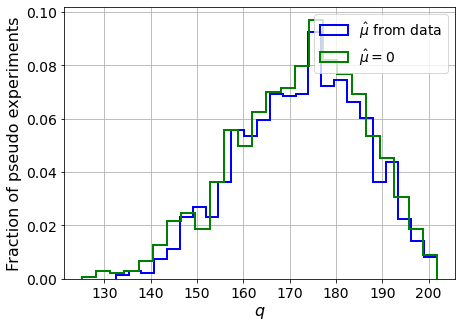

muhat mean:  0.005853605014610504
Z_bins:  13.17924720385303
std Z_bins:  0.5025758576317498
Z_bins mu=0:  13.176992562907957
std Z_bins mu=0:  0.5303520504341155

--------

B_expected:  643
S_expected:  268

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3425


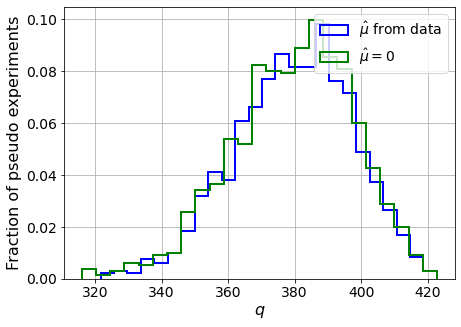

muhat mean:  0.0027070680148760795
Z_bins:  19.517518358556575
std Z_bins:  0.450427060016597
Z_bins mu=0:  19.516744117974625
std Z_bins mu=0:  0.468366057850005

--------

B_expected:  643
S_expected:  518

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.36


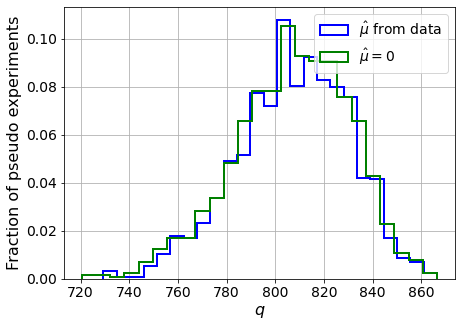

muhat mean:  0.0016739988944704728
Z_bins:  28.437024952877085
std Z_bins:  0.40327234652316457
Z_bins mu=0:  28.430451901212287
std Z_bins mu=0:  0.4161709429302149

--------

B_expected:  643
S_expected:  1001

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3415


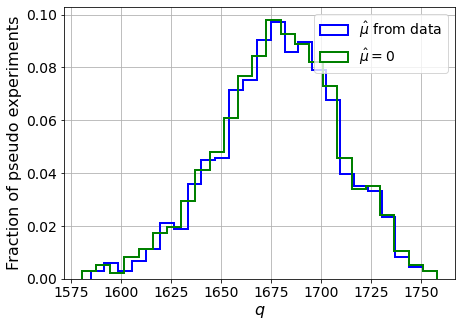

muhat mean:  0.0007200147347485415
Z_bins:  40.9828294623599
std Z_bins:  0.3682348333366625
Z_bins mu=0:  40.980776328639266
std Z_bins mu=0:  0.37595020051686673

--------

B_expected:  643
S_expected:  1932

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.339


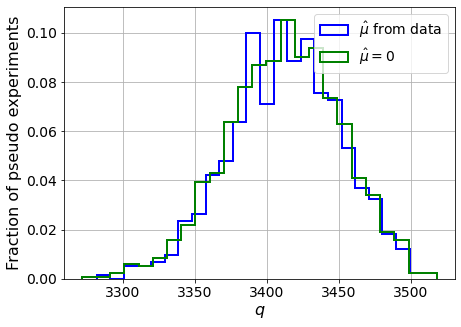

muhat mean:  0.0003911242538524513
Z_bins:  58.423378445002655
std Z_bins:  0.3312201323251618
Z_bins mu=0:  58.42028674001112
std Z_bins mu=0:  0.3363282409796759

--------

B_expected:  643
S_expected:  3730

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.344


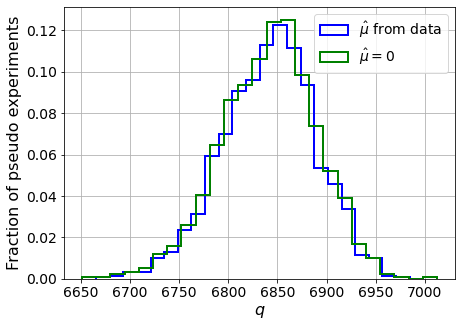

muhat mean:  0.00018626227015448383
Z_bins:  82.72964106506937
std Z_bins:  0.2889819976126914
Z_bins mu=0:  82.72781048952628
std Z_bins mu=0:  0.29247907028992465

--------

B_expected:  643
S_expected:  7201

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.327


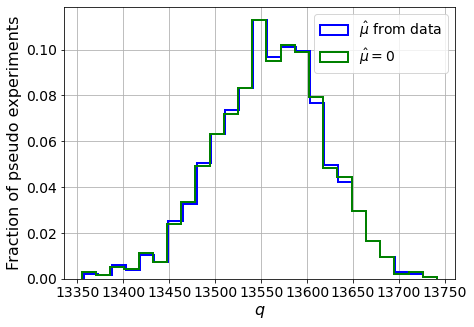

muhat mean:  0.0001348457424708197
Z_bins:  116.45061039127572
std Z_bins:  0.25356042910678184
Z_bins mu=0:  116.4480351737327
std Z_bins mu=0:  0.25591717242097795

--------

B_expected:  643
S_expected:  13904

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3425


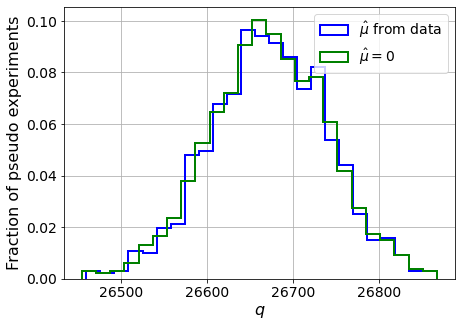

muhat mean:  4.634094653853772e-05
Z_bins:  163.31634241269327
std Z_bins:  0.20769126675873914
Z_bins mu=0:  163.3147333044312
std Z_bins mu=0:  0.2089813954767821

--------


 FINAL RESULT:

[[0.13718658264404004, 0.7066566972214371, 0.8220129242120148, 0.0790343602283238, 2.5654144454434085], [0.5539380719392328, 0.5882849378822501, 0.29592576436335766, 0.5316677903430462, 1.0731856588445756], [1.0205324521151582, 0.5692894927852874, 0.17947489014920726, 1.0115746197078126, 0.9194776371362049], [2.0010776626990836, 0.5920648194654098, 0.06986626597062559, 2.0008196727602097, 0.7803613797048636], [3.297411577342312, 0.6227325420332394, 0.04717682774836877, 3.2905057517132623, 0.7518769602646845], [5.509626274203501, 0.5954738828735946, 0.020526973805914454, 5.508239091474605, 0.6714295291741562], [8.70025756985737, 0.5513605267178942, 0.010326839181587862, 8.700000500444704, 0.5984993528657591], [13.17924720385303, 0.5025758576317498, 0.005853605014610504, 13.176992562907957, 0.53035

/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [        -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf 377.34588091 334.20870036 285.17906218 234.41841184
 177.97723629 116.15114162  50.30620053 -20.93501717 -93.75492702]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:990: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [        -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf 264.4383438  248.075794   221.47460516 188.28840921
 142

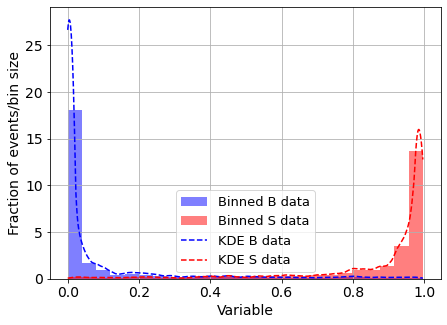

KDE Kernel:  epanechnikov
Background bandwidth:  0.022117541055781564
Signal bandwidth:  0.022117541055781564
This may take a while...
1 done
2 done
B_expected:  643
S_expected:  1



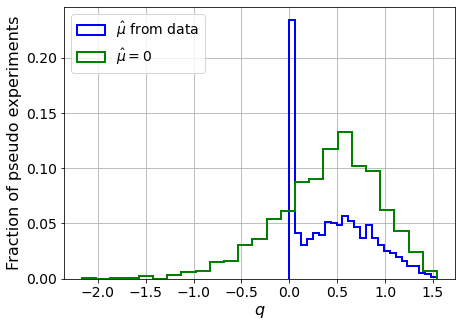

muhat mean:  -5.279587786168176
Z_bins:  0.6786270741639031
std Z_bins:  0.2877900162762906
Z_bins mu=0:  0.6786270741639031
std Z_bins mu=0:  0.3888481849700284

--------

B_expected:  643
S_expected:  3



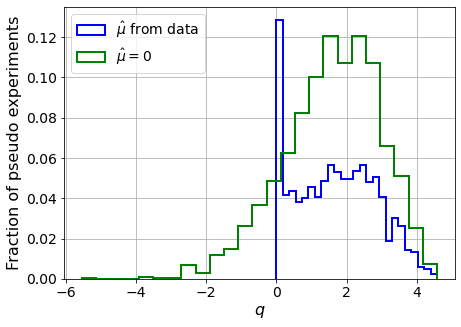

muhat mean:  -1.7794214096687817
Z_bins:  1.301745456244848
std Z_bins:  0.4377985885355872
Z_bins mu=0:  1.301745456244848
std Z_bins mu=0:  0.5283544055579845

--------

B_expected:  643
S_expected:  5



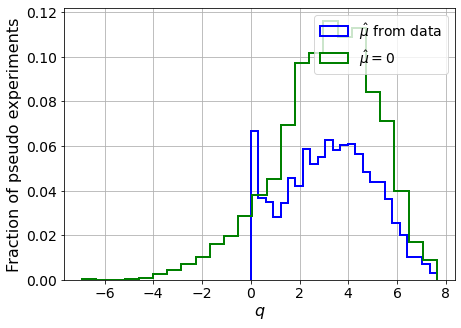

muhat mean:  -1.087298028820411
Z_bins:  1.802993913151334
std Z_bins:  0.4990053600079538
Z_bins mu=0:  1.802993913151334
std Z_bins mu=0:  0.5804289901656595

--------

B_expected:  643
S_expected:  10



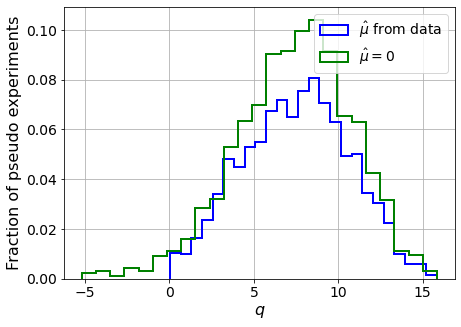

muhat mean:  -0.5599795312308533
Z_bins:  2.760009647435948
std Z_bins:  0.5669759946692726
Z_bins mu=0:  2.760009647435948
std Z_bins mu=0:  0.6174598796348392

--------

B_expected:  643
S_expected:  19



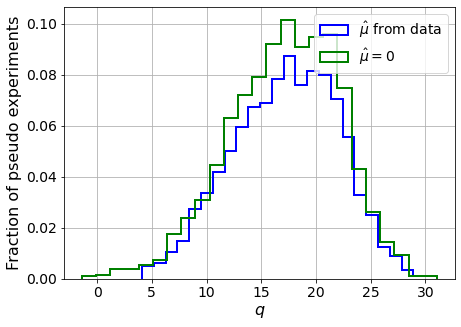

muhat mean:  -0.28604463113396517
Z_bins:  4.192819940684575
std Z_bins:  0.5732167549615136
Z_bins mu=0:  4.192819940684575
std Z_bins mu=0:  0.6024760371537067

--------

B_expected:  643
S_expected:  37



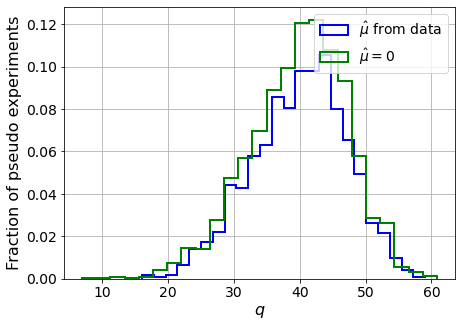

muhat mean:  -0.15505381015587164
Z_bins:  6.359288041475615
std Z_bins:  0.5628273204276603
Z_bins mu=0:  6.359288041475615
std Z_bins mu=0:  0.5829897655259019

--------

B_expected:  643
S_expected:  72



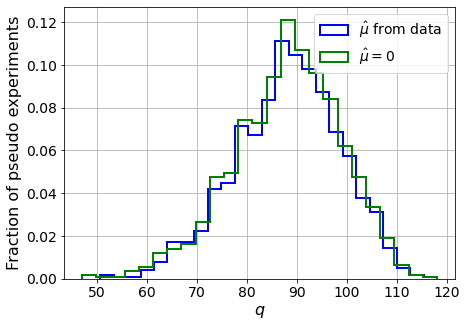

muhat mean:  -0.0660624818459396
Z_bins:  9.410633250106388
std Z_bins:  0.5582768605465291
Z_bins mu=0:  9.410038238305917
std Z_bins mu=0:  0.5742991801727834

--------

B_expected:  643
S_expected:  139



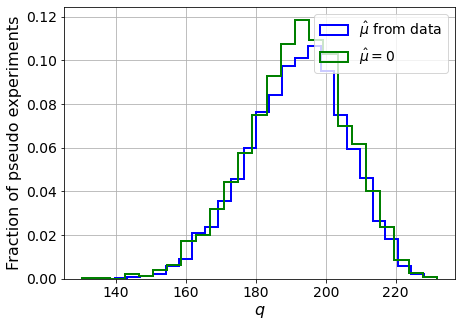

muhat mean:  -0.039175957195744945
Z_bins:  13.876936858373062
std Z_bins:  0.508083888392508
Z_bins mu=0:  13.876936858373062
std Z_bins mu=0:  0.5173539268111977

--------

B_expected:  643
S_expected:  268



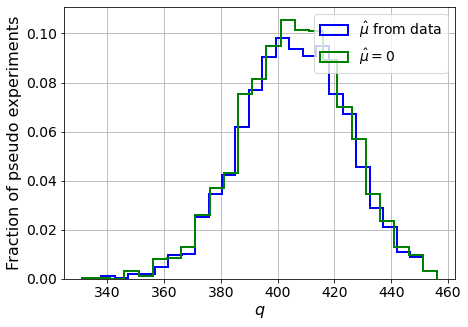

muhat mean:  -0.022634006896395213
Z_bins:  20.155914922150995
std Z_bins:  0.4607549505208784
Z_bins mu=0:  20.155914922150995
std Z_bins mu=0:  0.465621714395908

--------

B_expected:  643
S_expected:  518



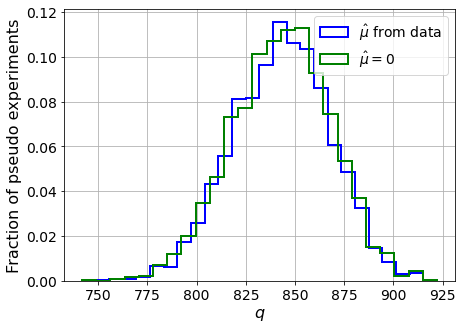

muhat mean:  -0.010815323081741362
Z_bins:  29.042326211837942
std Z_bins:  0.4283627320119727
Z_bins mu=0:  29.042326211837942
std Z_bins mu=0:  0.4317105099933618

--------

B_expected:  643
S_expected:  1001



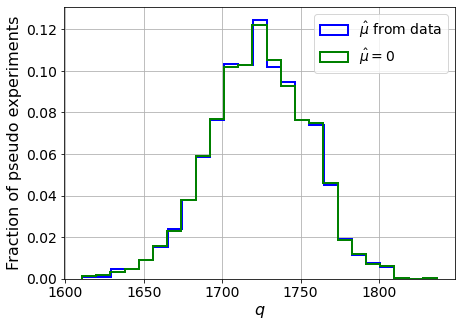

muhat mean:  -0.005282630019338698
Z_bins:  41.520104509207584
std Z_bins:  0.37825805034926346
Z_bins mu=0:  41.519889951597115
std Z_bins mu=0:  0.3803355629411273

--------

B_expected:  643
S_expected:  1932



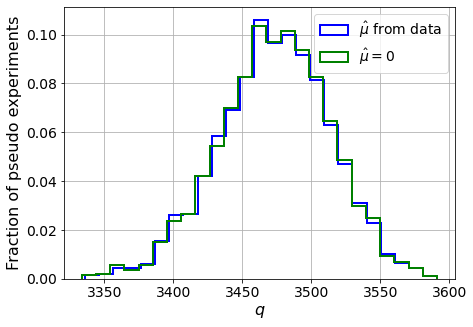

muhat mean:  -0.002693759128006953
Z_bins:  58.944778479450505
std Z_bins:  0.3423706671658739
Z_bins mu=0:  58.9444821697507
std Z_bins mu=0:  0.344127787797799

--------

B_expected:  643
S_expected:  3730



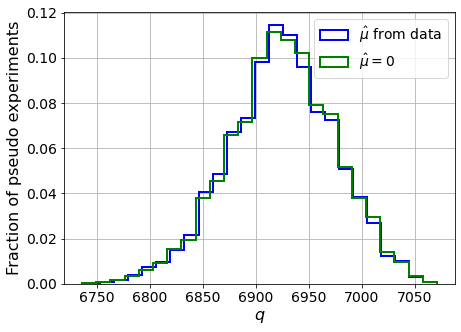

muhat mean:  -0.0013254985687074857
Z_bins:  83.21766809721247
std Z_bins:  0.30170587648900044
Z_bins mu=0:  83.21725497523393
std Z_bins mu=0:  0.30286543700938484

--------

B_expected:  643
S_expected:  7201



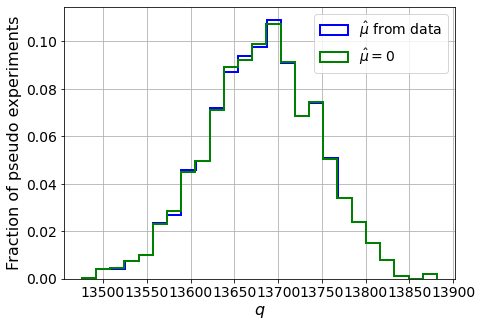

muhat mean:  -0.0007179119756387209
Z_bins:  116.97266406006446
std Z_bins:  0.26937846662028164
Z_bins mu=0:  116.97208917487575
std Z_bins mu=0:  0.27001595430036085

--------

B_expected:  643
S_expected:  13904



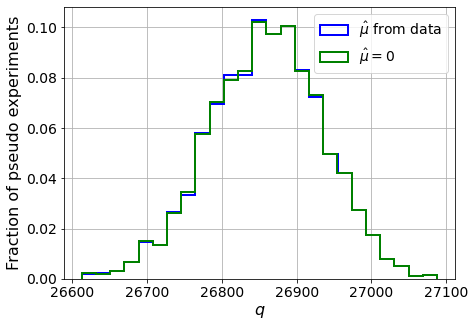

muhat mean:  -0.00036906347553043197
Z_bins:  163.89235938365118
std Z_bins:  0.22898941102890763
Z_bins mu=0:  163.89211758184246
std Z_bins mu=0:  0.2294181460418609

--------


 FINAL RESULT:

[[0.6786270741639031, 0.2877900162762906, -5.279587786168176, 0.6786270741639031, 0.3888481849700284], [1.301745456244848, 0.4377985885355872, -1.7794214096687817, 1.301745456244848, 0.5283544055579845], [1.802993913151334, 0.4990053600079538, -1.087298028820411, 1.802993913151334, 0.5804289901656595], [2.760009647435948, 0.5669759946692726, -0.5599795312308533, 2.760009647435948, 0.6174598796348392], [4.192819940684575, 0.5732167549615136, -0.28604463113396517, 4.192819940684575, 0.6024760371537067], [6.359288041475615, 0.5628273204276603, -0.15505381015587164, 6.359288041475615, 0.5829897655259019], [9.410633250106388, 0.5582768605465291, -0.0660624818459396, 9.410038238305917, 0.5742991801727834], [13.876936858373062, 0.508083888392508, -0.039175957195744945, 13.876936858373062, 0.517353926

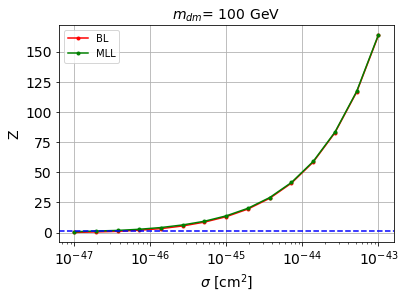


cross_BL_164:  5.9918468195289e-47
cross_BL_164_up:  3.8522788027023874e-47
cross_BL_164_down:  8.114960474084952e-47

cross_MLL_164:  3.3324773708557455e-47
cross_MLL_164_up:  1.7184947371797877e-47
cross_MLL_164_down:  4.779839059475387e-47

#########################


#########################

mDM =  200 GeV


S_cs1.shape:  (34573,)
S_cs2.shape:  (34573,)
 NUM_DAT:  31737 

NUM_DAT_ER:  31333
NUM_DAT_AC:  111
NUM_DAT_CNNS:  1
NUM_DAT_RN:  29
NUM_DAT_WALL:  263

B_cs1cs2.shape:  (31737, 2)

S_cs1cs2.shape:  (31737, 2)


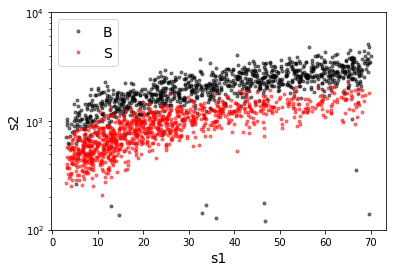

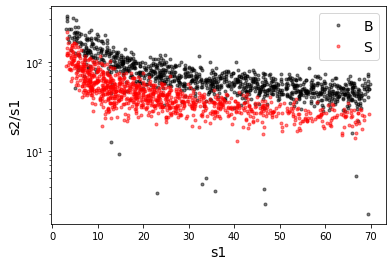

X_mon_B.shape:  (31737, 2)
X_mon_S.shape:  (31737, 2)
X_mon.shape:  (63474, 2)

X_mon_train :  (40464, 2)
y_mon_train :  (40464,)
X_mon_val :  (7141, 2)
y_mon_val :  (7141,)
X_mon_test :  (15869, 2)
y_mon_test :  (15869,)

Classification score:


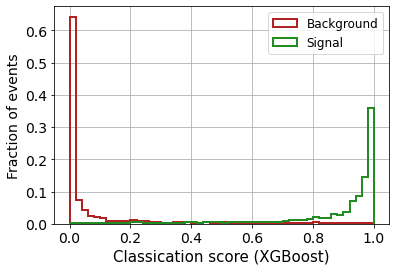


 ROC-AUC =  0.9796967878241009
At least 5 B events per bin, range = [[0, 1]]:
# bins:  15 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
max number of bins allowed:  15
range of our data:  [[0, 1]]
number of bins we are going to use:  10
B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.2735


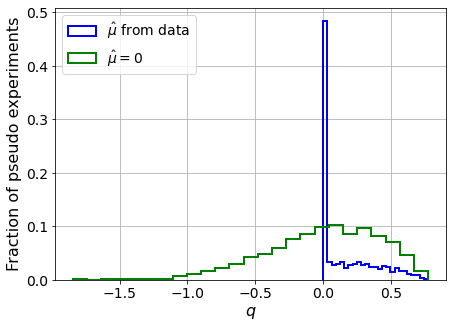

muhat mean:  0.44841324637931507
Z_bins:  0.20689856941091286
std Z_bins:  0.5023958023496983
Z_bins mu=0:  0.2051659568441876
std Z_bins mu=0:  0.9901455467489905

--------

B_expected:  643
S_expected:  2

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.278


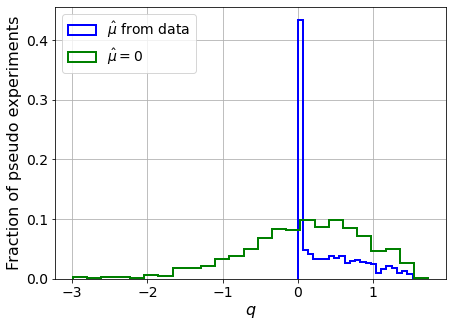

muhat mean:  0.2771367400226531
Z_bins:  0.40322808322881676
std Z_bins:  0.5389615136377981
Z_bins mu=0:  0.40209757784486544
std Z_bins mu=0:  0.9886332487469256

--------

B_expected:  643
S_expected:  3

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.2775


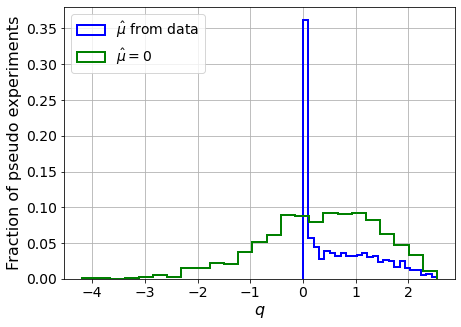

muhat mean:  0.11695544987787936
Z_bins:  0.6476422193996622
std Z_bins:  0.5258174761289329
Z_bins mu=0:  0.6472133011771033
std Z_bins mu=0:  0.8440504749746288

--------

B_expected:  643
S_expected:  6

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.275


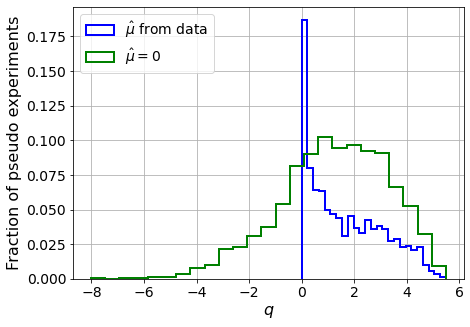

muhat mean:  0.09811602356428702
Z_bins:  1.1672781001178827
std Z_bins:  0.6074226452398783
Z_bins mu=0:  1.1640495902208512
std Z_bins mu=0:  0.8838984252464605

--------

B_expected:  643
S_expected:  11

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.2755


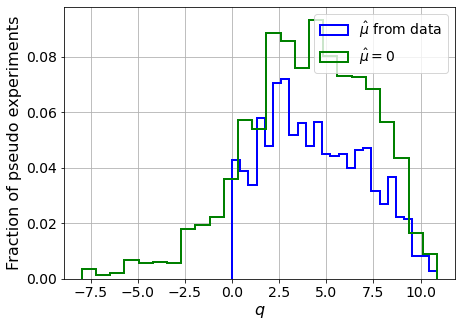

muhat mean:  0.04876124245589902
Z_bins:  2.0519870918369376
std Z_bins:  0.6370469715529882
Z_bins mu=0:  2.051864140148334
std Z_bins mu=0:  0.8110890634651956

--------

B_expected:  643
S_expected:  21

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.2705


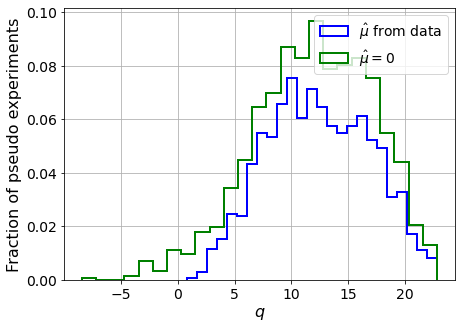

muhat mean:  0.02470833178147716
Z_bins:  3.489534819924867
std Z_bins:  0.6465182450306217
Z_bins mu=0:  3.488824786649244
std Z_bins mu=0:  0.7450002759170633

--------

B_expected:  643
S_expected:  41

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.28


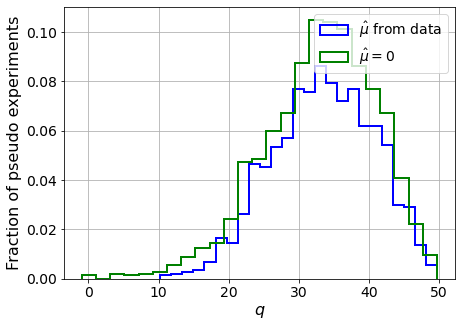

muhat mean:  0.011942949647886109
Z_bins:  5.801634098817317
std Z_bins:  0.6190429646353731
Z_bins mu=0:  5.8015323380184025
std Z_bins mu=0:  0.687440344141346

--------

B_expected:  643
S_expected:  79

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.289


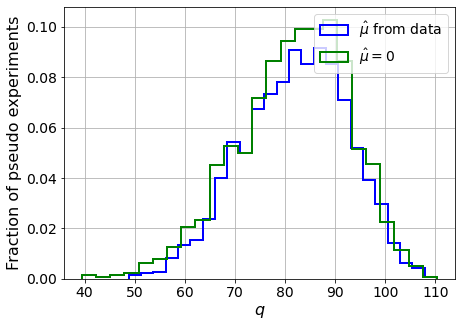

muhat mean:  0.005796289396558782
Z_bins:  9.084815551197808
std Z_bins:  0.5731359041004893
Z_bins mu=0:  9.083440316893787
std Z_bins mu=0:  0.6131472076282584

--------

B_expected:  643
S_expected:  152

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.29


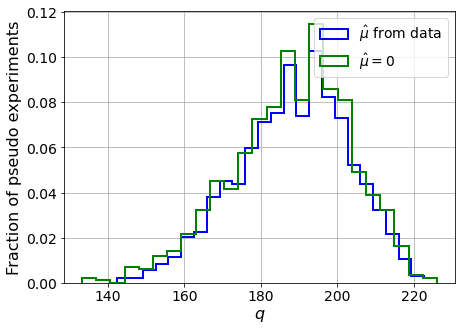

muhat mean:  0.004188580860554685
Z_bins:  13.753159928674293
std Z_bins:  0.5321667108278195
Z_bins mu=0:  13.752901527117428
std Z_bins mu=0:  0.560516451341006

--------

B_expected:  643
S_expected:  294

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.2695


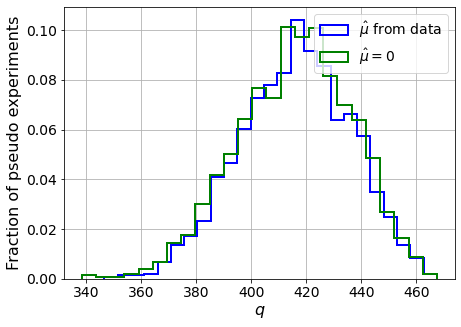

muhat mean:  0.002532764064009043
Z_bins:  20.413539308561695
std Z_bins:  0.48815491040885906
Z_bins mu=0:  20.411286287163215
std Z_bins mu=0:  0.5062901593912642

--------

B_expected:  643
S_expected:  567

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.2915


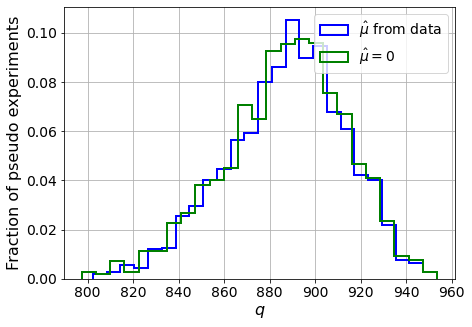

muhat mean:  0.0010902543645178542
Z_bins:  29.82199511302954
std Z_bins:  0.4374988810522741
Z_bins mu=0:  29.820509854622085
std Z_bins mu=0:  0.4505721753391242

--------

B_expected:  643
S_expected:  1094

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.2815


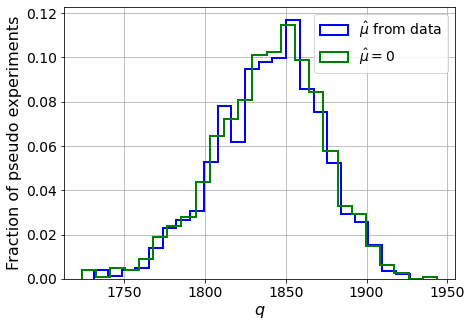

muhat mean:  0.0005874055391401651
Z_bins:  42.918524736341794
std Z_bins:  0.38174864116126356
Z_bins mu=0:  42.91752829745545
std Z_bins mu=0:  0.3896135108740954

--------

B_expected:  643
S_expected:  2113

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.29


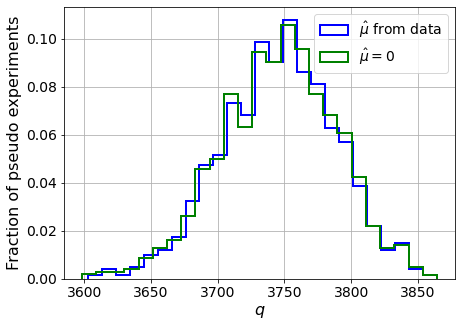

muhat mean:  0.00025950329705964165
Z_bins:  61.220033883178935
std Z_bins:  0.3480965873307352
Z_bins mu=0:  61.217785106563184
std Z_bins mu=0:  0.3530119809715477

--------

B_expected:  643
S_expected:  4079

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.305


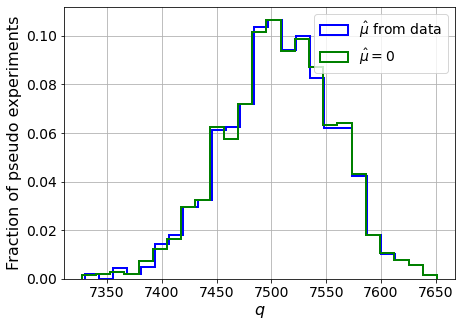

muhat mean:  0.00012785037116872799
Z_bins:  86.64815222163801
std Z_bins:  0.2888729835462413
Z_bins mu=0:  86.64815222163801
std Z_bins mu=0:  0.29207403468510185

--------

B_expected:  643
S_expected:  7876

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.298


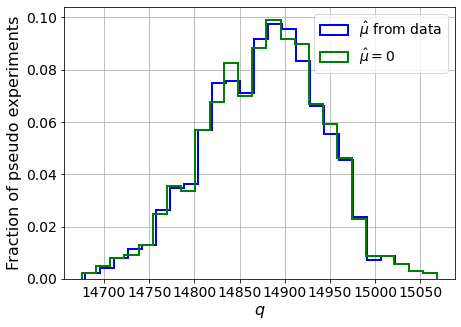

muhat mean:  6.422911812968515e-05
Z_bins:  121.98563293390855
std Z_bins:  0.26712896822126836
Z_bins mu=0:  121.9854087506755
std Z_bins mu=0:  0.26951089162206987

--------


 FINAL RESULT:

[[0.20689856941091286, 0.5023958023496983, 0.44841324637931507, 0.2051659568441876, 0.9901455467489905], [0.40322808322881676, 0.5389615136377981, 0.2771367400226531, 0.40209757784486544, 0.9886332487469256], [0.6476422193996622, 0.5258174761289329, 0.11695544987787936, 0.6472133011771033, 0.8440504749746288], [1.1672781001178827, 0.6074226452398783, 0.09811602356428702, 1.1640495902208512, 0.8838984252464605], [2.0519870918369376, 0.6370469715529882, 0.04876124245589902, 2.051864140148334, 0.8110890634651956], [3.489534819924867, 0.6465182450306217, 0.02470833178147716, 3.488824786649244, 0.7450002759170633], [5.801634098817317, 0.6190429646353731, 0.011942949647886109, 5.8015323380184025, 0.687440344141346], [9.084815551197808, 0.5731359041004893, 0.005796289396558782, 9.083440316893787, 0.613

/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [        -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf 348.82851462 310.47721605 268.58117118 219.36499213
 161.09057408 102.35584765  35.91579392 -30.70805814 -97.16885335]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:990: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [        -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf 201.55404494 171.77836613
 133

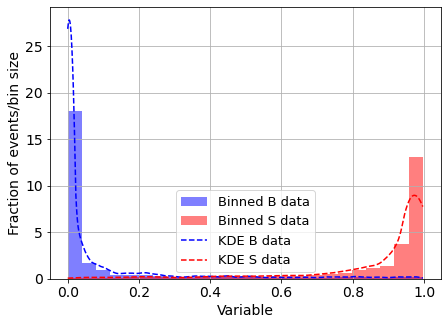

KDE Kernel:  epanechnikov
Background bandwidth:  0.022117541055781564
Signal bandwidth:  0.059027261020128646
This may take a while...
1 done
2 done
B_expected:  643
S_expected:  1



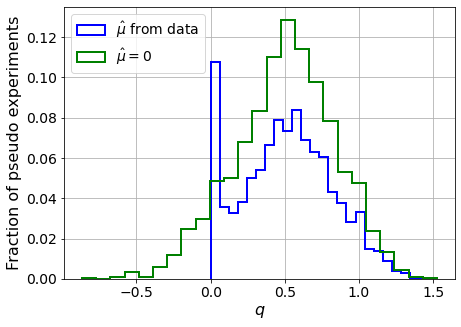

muhat mean:  -6.079622374426545
Z_bins:  0.7178535021483646
std Z_bins:  0.21591469416768386
Z_bins mu=0:  0.7178535021483646
std Z_bins mu=0:  0.23471575972096817

--------

B_expected:  643
S_expected:  2



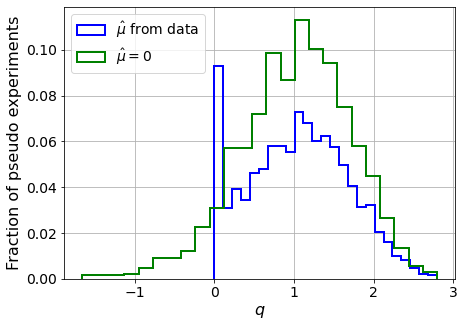

muhat mean:  -2.8784059704885903
Z_bins:  1.0372110121871625
std Z_bins:  0.3006153021835277
Z_bins mu=0:  1.0372110121871625
std Z_bins mu=0:  0.3323359760820064

--------

B_expected:  643
S_expected:  3



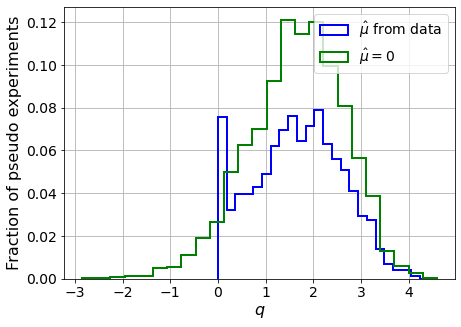

muhat mean:  -1.9141948212840882
Z_bins:  1.3002395667038888
std Z_bins:  0.35722972170207756
Z_bins mu=0:  1.3002395667038888
std Z_bins mu=0:  0.38896713632074503

--------

B_expected:  643
S_expected:  6



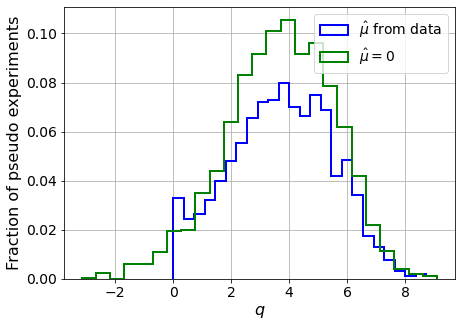

muhat mean:  -1.006465219096629
Z_bins:  1.9448567779192374
std Z_bins:  0.45337443236634556
Z_bins mu=0:  1.9448567779192374
std Z_bins mu=0:  0.47625221407780965

--------

B_expected:  643
S_expected:  11



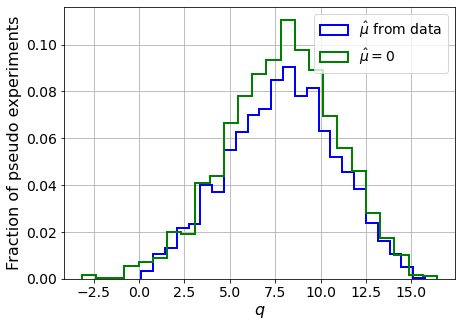

muhat mean:  -0.5745038706169231
Z_bins:  2.8252867019026837
std Z_bins:  0.5251781680184473
Z_bins mu=0:  2.8252867019026837
std Z_bins mu=0:  0.5389814453725392

--------

B_expected:  643
S_expected:  21



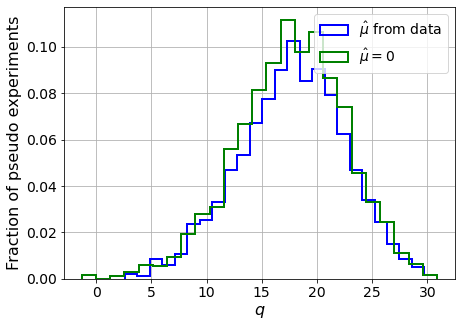

muhat mean:  -0.2986597400007138
Z_bins:  4.22840482512483
std Z_bins:  0.5649102896352256
Z_bins mu=0:  4.22840482512483
std Z_bins mu=0:  0.5762111784548936

--------

B_expected:  643
S_expected:  41



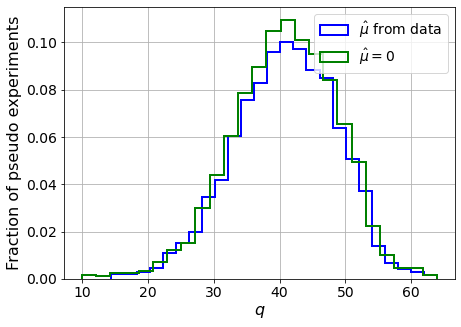

muhat mean:  -0.1440507711882788
Z_bins:  6.413703089922546
std Z_bins:  0.6042623359407915
Z_bins mu=0:  6.413703089922546
std Z_bins mu=0:  0.6148516428657078

--------

B_expected:  643
S_expected:  79



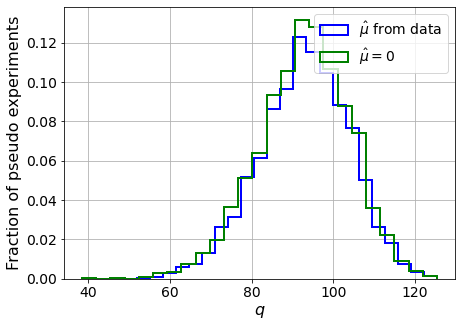

muhat mean:  -0.07698750891710508
Z_bins:  9.65916727164265
std Z_bins:  0.578902759294634
Z_bins mu=0:  9.65916727164265
std Z_bins mu=0:  0.5852421362520427

--------

B_expected:  643
S_expected:  152



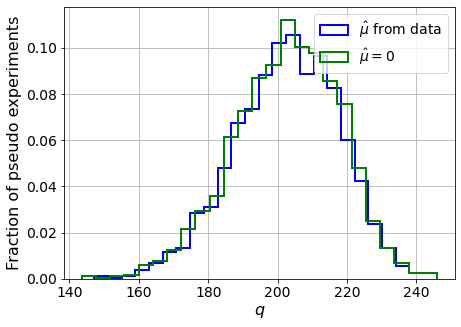

muhat mean:  -0.037329168077559774
Z_bins:  14.258065115512222
std Z_bins:  0.5287545403424748
Z_bins mu=0:  14.258065115512222
std Z_bins mu=0:  0.5323214832191343

--------

B_expected:  643
S_expected:  294



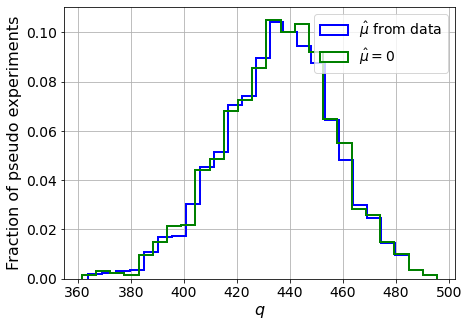

muhat mean:  -0.01869317422700749
Z_bins:  20.89303257107588
std Z_bins:  0.5064456261718288
Z_bins mu=0:  20.89303257107588
std Z_bins mu=0:  0.5086214101881938

--------

B_expected:  643
S_expected:  567



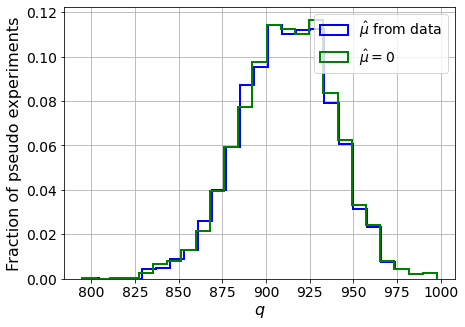

muhat mean:  -0.010674433397548217
Z_bins:  30.21222335250557
std Z_bins:  0.447511692845505
Z_bins mu=0:  30.21222335250557
std Z_bins mu=0:  0.44910663883868435

--------

B_expected:  643
S_expected:  1094



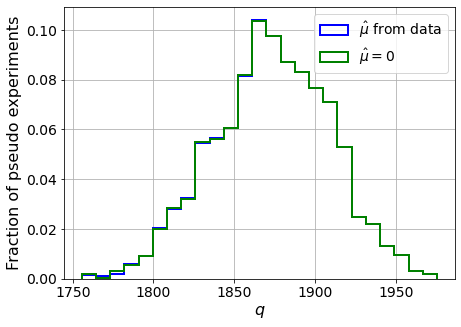

muhat mean:  -0.005535504027331844
Z_bins:  43.28708242685892
std Z_bins:  0.4142517593715545
Z_bins mu=0:  43.28639061135484
std Z_bins mu=0:  0.4150787773860115

--------

B_expected:  643
S_expected:  2113



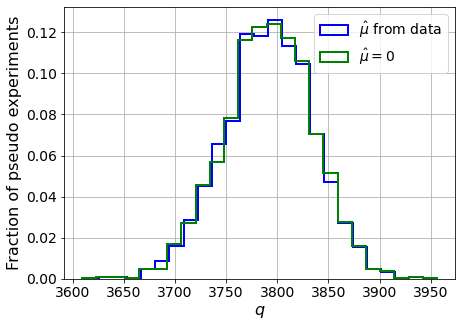

muhat mean:  -0.0029063531487881085
Z_bins:  61.58635492969108
std Z_bins:  0.35699425479578994
Z_bins mu=0:  61.58606266749453
std Z_bins mu=0:  0.35761294103449204

--------

B_expected:  643
S_expected:  4079



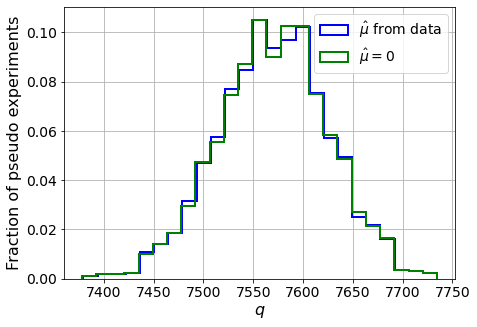

muhat mean:  -0.00147155052401255
Z_bins:  87.01089081486639
std Z_bins:  0.3179789931302407
Z_bins mu=0:  87.01089081486639
std Z_bins mu=0:  0.31856324624318944

--------

B_expected:  643
S_expected:  7876



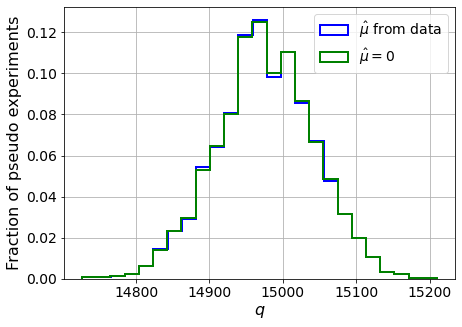

muhat mean:  -0.0007739753630174435
Z_bins:  122.37062733158193
std Z_bins:  0.27316823281060104
Z_bins mu=0:  122.37062733158193
std Z_bins mu=0:  0.2734302246416302

--------


 FINAL RESULT:

[[0.7178535021483646, 0.21591469416768386, -6.079622374426545, 0.7178535021483646, 0.23471575972096817], [1.0372110121871625, 0.3006153021835277, -2.8784059704885903, 1.0372110121871625, 0.3323359760820064], [1.3002395667038888, 0.35722972170207756, -1.9141948212840882, 1.3002395667038888, 0.38896713632074503], [1.9448567779192374, 0.45337443236634556, -1.006465219096629, 1.9448567779192374, 0.47625221407780965], [2.8252867019026837, 0.5251781680184473, -0.5745038706169231, 2.8252867019026837, 0.5389814453725392], [4.22840482512483, 0.5649102896352256, -0.2986597400007138, 4.22840482512483, 0.5762111784548936], [6.413703089922546, 0.6042623359407915, -0.1440507711882788, 6.413703089922546, 0.6148516428657078], [9.65916727164265, 0.578902759294634, -0.07698750891710508, 9.65916727164265, 0.58524

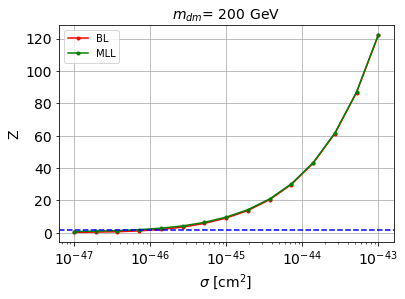


cross_BL_164:  1.0228385029121443e-46
cross_BL_164_up:  6.532073544322104e-47
cross_BL_164_down:  1.5412912753159991e-46

cross_MLL_164:  5.730753345380576e-47
cross_MLL_164_up:  3.6702074293744576e-47
cross_MLL_164_down:  8.121178193222236e-47

#########################


#########################

mDM =  500 GeV


S_cs1.shape:  (35477,)
S_cs2.shape:  (35477,)
 NUM_DAT:  32117 

NUM_DAT_ER:  31709
NUM_DAT_AC:  112
NUM_DAT_CNNS:  1
NUM_DAT_RN:  29
NUM_DAT_WALL:  266

B_cs1cs2.shape:  (32117, 2)

S_cs1cs2.shape:  (32117, 2)


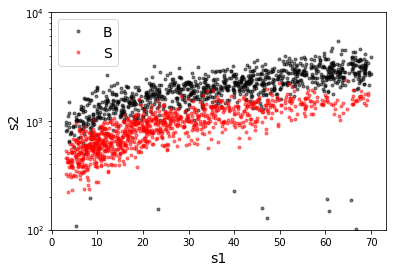

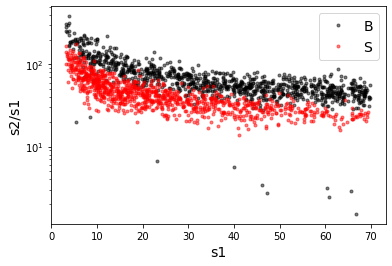

X_mon_B.shape:  (32117, 2)
X_mon_S.shape:  (32117, 2)
X_mon.shape:  (64234, 2)

X_mon_train :  (40948, 2)
y_mon_train :  (40948,)
X_mon_val :  (7227, 2)
y_mon_val :  (7227,)
X_mon_test :  (16059, 2)
y_mon_test :  (16059,)

Classification score:


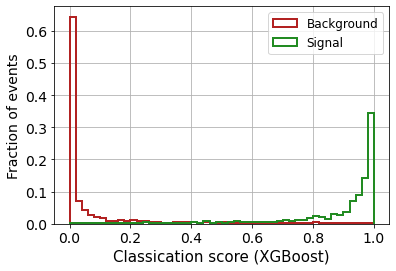


 ROC-AUC =  0.9789053658290833
At least 5 B events per bin, range = [[0, 1]]:
# bins:  14 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
max number of bins allowed:  14
range of our data:  [[0, 1]]
number of bins we are going to use:  10
B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3295


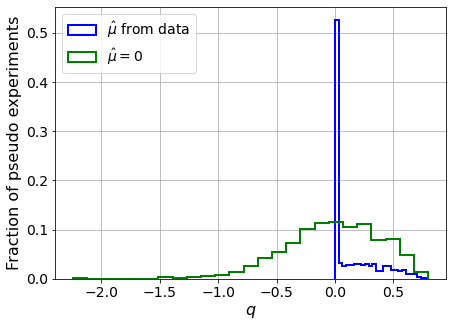

muhat mean:  0.6919523237910553
Z_bins:  0.12745195380994706
std Z_bins:  0.790576986375529
Z_bins mu=0:  0.08421720660676013
std Z_bins mu=0:  2.3892962765281593

--------

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.336


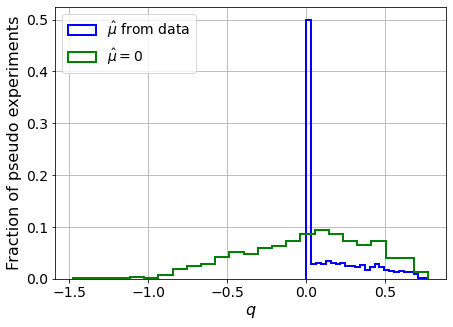

muhat mean:  0.5476370359818445
Z_bins:  0.1763761894054349
std Z_bins:  0.5846585688120467
Z_bins mu=0:  0.1697846543426022
std Z_bins mu=0:  1.1782699275314998

--------

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3325


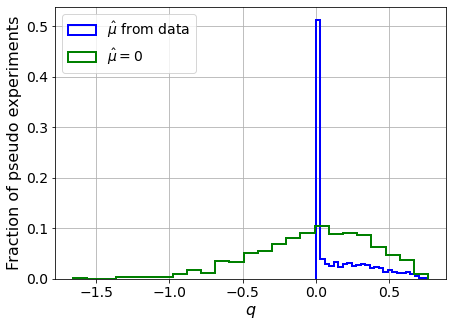

muhat mean:  0.6998540981564682
Z_bins:  0.15392301149599777
std Z_bins:  0.6361036845252798
Z_bins mu=0:  0.13528253080890826
std Z_bins mu=0:  1.4752719870363453

--------

B_expected:  643
S_expected:  2

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3295


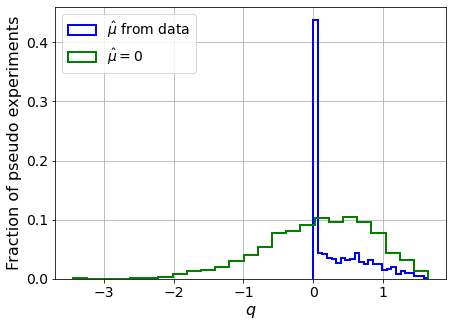

muhat mean:  0.2911720514274109
Z_bins:  0.4029239321263541
std Z_bins:  0.5190537115328817
Z_bins mu=0:  0.4010047753069714
std Z_bins mu=0:  0.944446466239653

--------

B_expected:  643
S_expected:  5

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3245


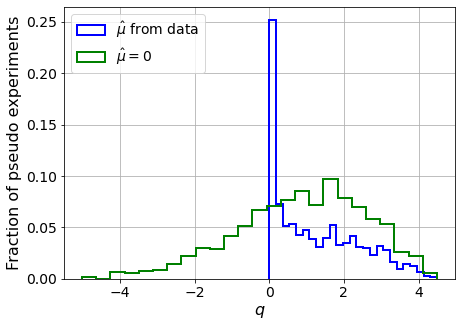

muhat mean:  0.1015753837961927
Z_bins:  1.0146970913888191
std Z_bins:  0.5714342932175249
Z_bins mu=0:  1.0137835270038043
std Z_bins mu=0:  0.8557505353129289

--------

B_expected:  643
S_expected:  9

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.337


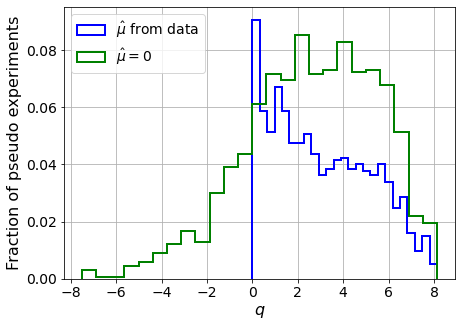

muhat mean:  0.07152426979350099
Z_bins:  1.6769037482510374
std Z_bins:  0.6434719220609217
Z_bins mu=0:  1.6756160830308768
std Z_bins mu=0:  0.858203159017236

--------

B_expected:  643
S_expected:  17

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3485


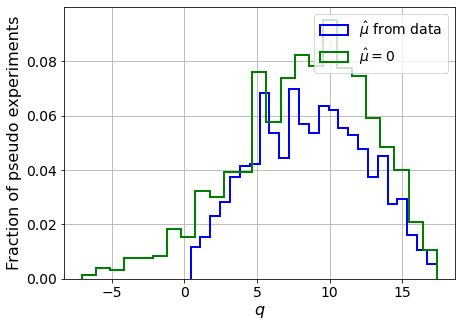

muhat mean:  0.03483670043378151
Z_bins:  2.93865451392797
std Z_bins:  0.6486867810734082
Z_bins mu=0:  2.9383298000702873
std Z_bins mu=0:  0.7788682005910478

--------

B_expected:  643
S_expected:  33

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.323


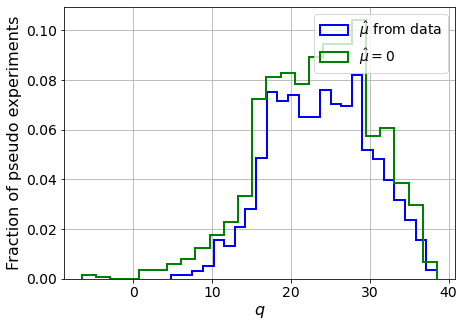

muhat mean:  0.01835605765853805
Z_bins:  4.891887249686896
std Z_bins:  0.6426088127221725
Z_bins mu=0:  4.890344237734629
std Z_bins mu=0:  0.720827195019927

--------

B_expected:  643
S_expected:  64

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.324


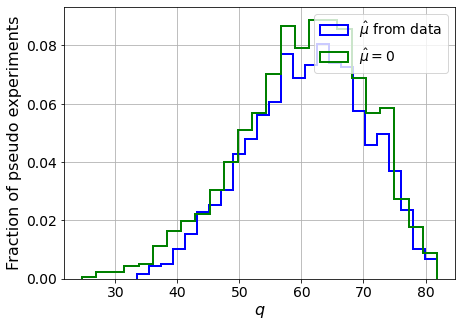

muhat mean:  0.009258947531855174
Z_bins:  7.828371727350913
std Z_bins:  0.6006100368711024
Z_bins mu=0:  7.828155699567912
std Z_bins mu=0:  0.6509024252957358

--------

B_expected:  643
S_expected:  124

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3525


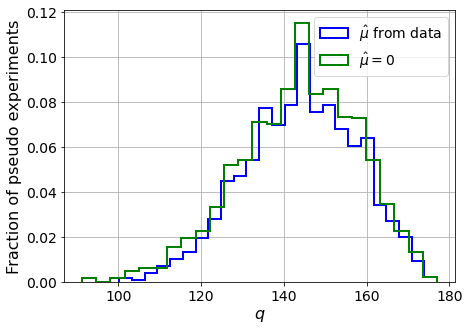

muhat mean:  0.006350880376730849
Z_bins:  12.018505143455986
std Z_bins:  0.5631463113619921
Z_bins mu=0:  12.015302193618053
std Z_bins mu=0:  0.5955034142558261

--------

B_expected:  643
S_expected:  239

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.345


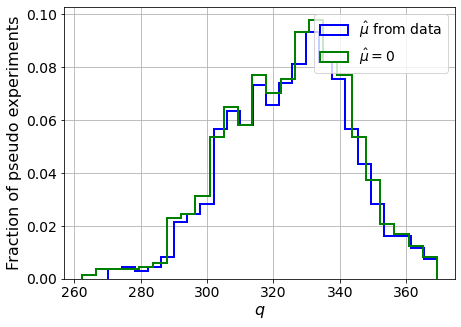

muhat mean:  0.0019048442597291557
Z_bins:  18.06674940797719
std Z_bins:  0.49704003084662113
Z_bins mu=0:  18.06445842444688
std Z_bins mu=0:  0.5144708186686101

--------

B_expected:  643
S_expected:  462

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.341


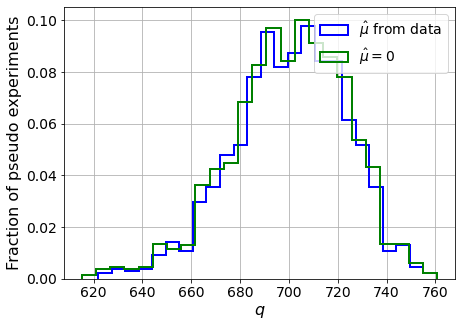

muhat mean:  0.0013159116680414578
Z_bins:  26.487418089240187
std Z_bins:  0.4357809630158084
Z_bins mu=0:  26.485690694883615
std Z_bins mu=0:  0.44900930939265576

--------

B_expected:  643
S_expected:  892

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.348


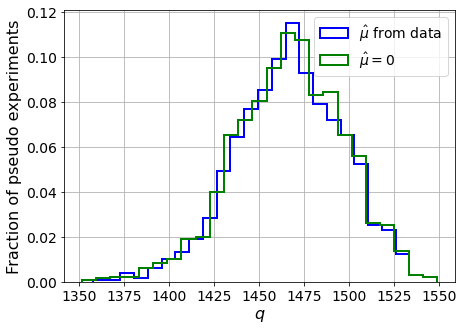

muhat mean:  0.0006947319784652757
Z_bins:  38.31085573506407
std Z_bins:  0.38879403066942736
Z_bins mu=0:  38.309401481079824
std Z_bins mu=0:  0.3973880240545288

--------

B_expected:  643
S_expected:  1723

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3375


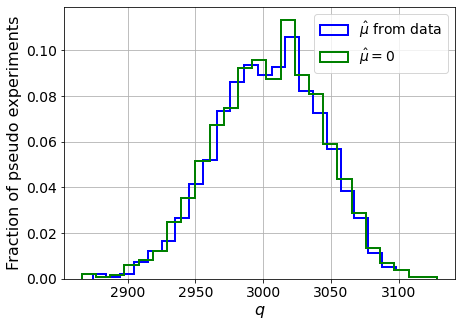

muhat mean:  0.0004073185871613978
Z_bins:  54.825927351536166
std Z_bins:  0.35627476057505586
Z_bins mu=0:  54.824085113736245
std Z_bins mu=0:  0.3619444195739964

--------

B_expected:  643
S_expected:  3326

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.3395


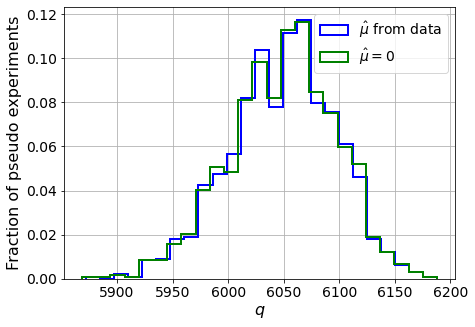

muhat mean:  0.00019682029014917409
Z_bins:  77.80053540366225
std Z_bins:  0.30432030835274215
Z_bins mu=0:  77.79982358579518
std Z_bins mu=0:  0.30808145599133535

--------


 FINAL RESULT:

[[0.12745195380994706, 0.790576986375529, 0.6919523237910553, 0.08421720660676013, 2.3892962765281593], [0.1763761894054349, 0.5846585688120467, 0.5476370359818445, 0.1697846543426022, 1.1782699275314998], [0.15392301149599777, 0.6361036845252798, 0.6998540981564682, 0.13528253080890826, 1.4752719870363453], [0.4029239321263541, 0.5190537115328817, 0.2911720514274109, 0.4010047753069714, 0.944446466239653], [1.0146970913888191, 0.5714342932175249, 0.1015753837961927, 1.0137835270038043, 0.8557505353129289], [1.6769037482510374, 0.6434719220609217, 0.07152426979350099, 1.6756160830308768, 0.858203159017236], [2.93865451392797, 0.6486867810734082, 0.03483670043378151, 2.9383298000702873, 0.7788682005910478], [4.891887249686896, 0.6426088127221725, 0.01835605765853805, 4.890344237734629, 0.72082719

/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [        -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf 319.50349552 274.46735236 223.69050306
 162.81021468 102.28951095  37.72558733 -28.07738454 -96.1483731 ]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:990: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [        -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf 208.06422975 186.85371731 157.22507743
 119

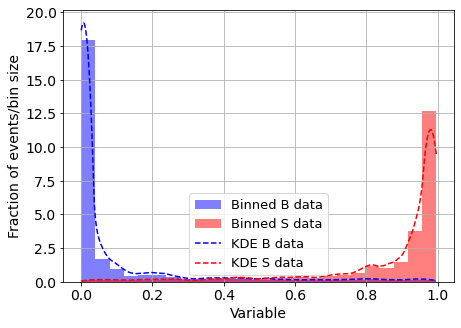

KDE Kernel:  epanechnikov
Background bandwidth:  0.03613222756796251
Signal bandwidth:  0.03613222756796251
This may take a while...
1 done
2 done
B_expected:  643
S_expected:  1



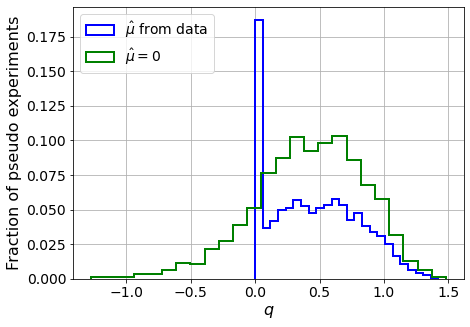

muhat mean:  -4.816145294890245
Z_bins:  0.6660864782007411
std Z_bins:  0.2595323702615941
Z_bins mu=0:  0.6660864782007411
std Z_bins mu=0:  0.31892487216706317

--------

B_expected:  643
S_expected:  1



/home/andres/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


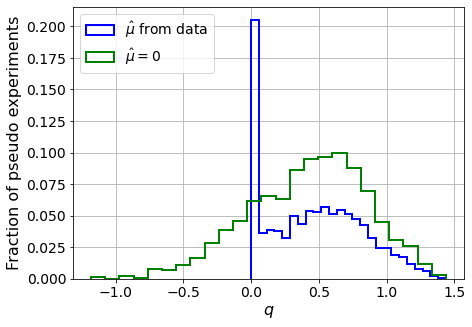

muhat mean:  -4.825327306889042
Z_bins:  0.6806820636151737
std Z_bins:  0.26026009042825415
Z_bins mu=0:  0.6806820636151737
std Z_bins mu=0:  0.3164040958092617

--------

B_expected:  643
S_expected:  1



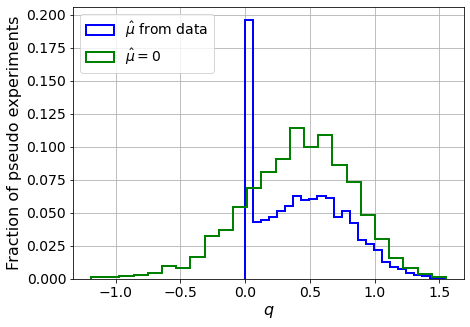

muhat mean:  -4.8520315006073655
Z_bins:  0.6594401691410624
std Z_bins:  0.2552950289821425
Z_bins mu=0:  0.6594401691410624
std Z_bins mu=0:  0.31071284622007805

--------

B_expected:  643
S_expected:  2



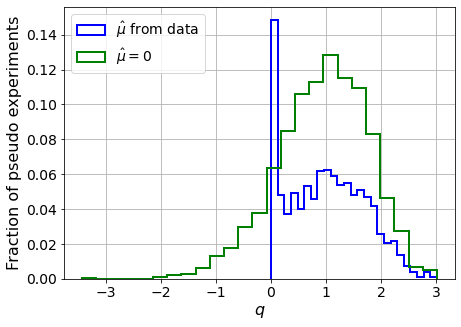

muhat mean:  -2.5830236468249312
Z_bins:  0.9975152919170786
std Z_bins:  0.34893584849652054
Z_bins mu=0:  0.9975152919170786
std Z_bins mu=0:  0.41310230122093833

--------

B_expected:  643
S_expected:  5



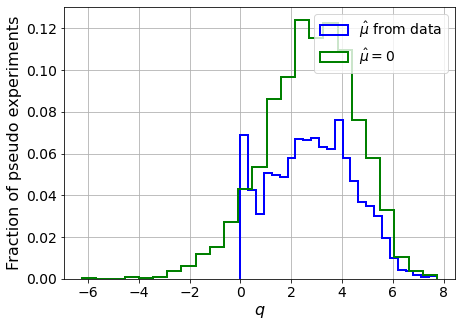

muhat mean:  -0.8561284066475178
Z_bins:  1.6942643246274014
std Z_bins:  0.4764681144683482
Z_bins mu=0:  1.6942643246274014
std Z_bins mu=0:  0.5331274272861883

--------

B_expected:  643
S_expected:  9



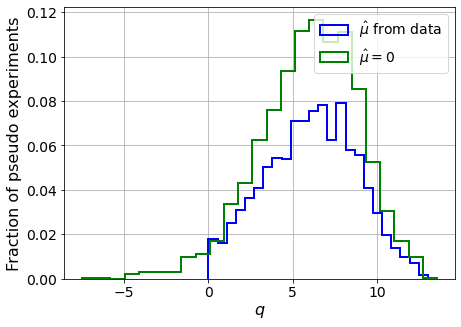

muhat mean:  -0.5454024535791905
Z_bins:  2.4845934776101974
std Z_bins:  0.5435810529882333
Z_bins mu=0:  2.4845934776101974
std Z_bins mu=0:  0.5914020601791591

--------

B_expected:  643
S_expected:  17



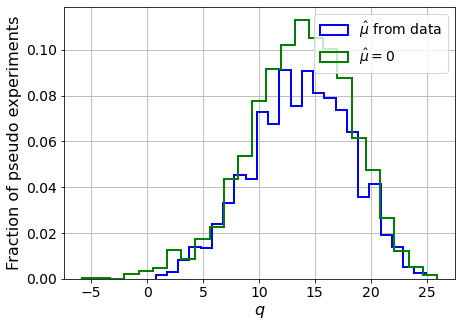

muhat mean:  -0.2916548270998949
Z_bins:  3.7362214792144446
std Z_bins:  0.5874715890693771
Z_bins mu=0:  3.7362214792144446
std Z_bins mu=0:  0.616714569068149

--------

B_expected:  643
S_expected:  33



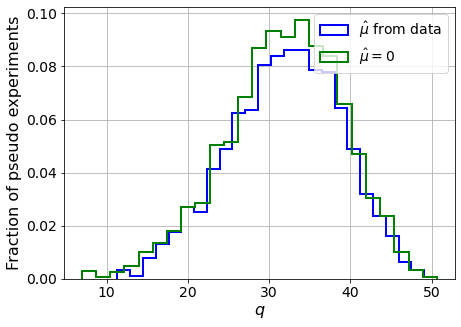

muhat mean:  -0.14071193131803228
Z_bins:  5.679083766031191
std Z_bins:  0.6106088328050605
Z_bins mu=0:  5.679083766031191
std Z_bins mu=0:  0.630031596644555

--------

B_expected:  643
S_expected:  64



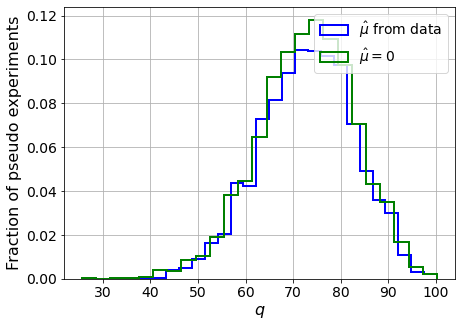

muhat mean:  -0.0705642331896756
Z_bins:  8.561290592890158
std Z_bins:  0.5809347886911461
Z_bins mu=0:  8.561290592890158
std Z_bins mu=0:  0.5933262268457424

--------

B_expected:  643
S_expected:  124



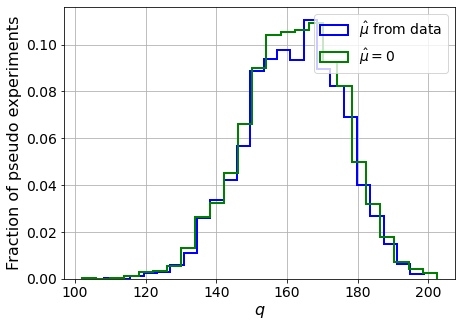

muhat mean:  -0.03748065177875888
Z_bins:  12.748200188019156
std Z_bins:  0.5434017233855469
Z_bins mu=0:  12.748200188019156
std Z_bins mu=0:  0.5516046193551305

--------

B_expected:  643
S_expected:  239



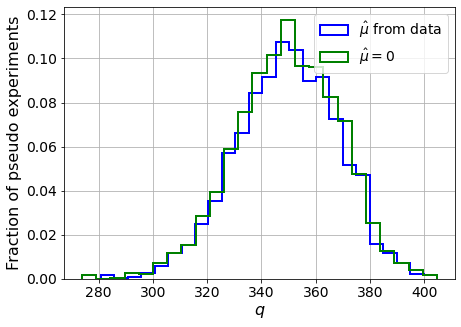

muhat mean:  -0.020409018368572226
Z_bins:  18.709941458327467
std Z_bins:  0.49771989928919097
Z_bins mu=0:  18.709941458327467
std Z_bins mu=0:  0.5024408872939676

--------

B_expected:  643
S_expected:  462



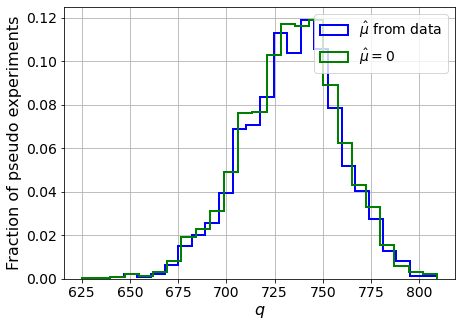

muhat mean:  -0.009950934648348942
Z_bins:  27.1072681952503
std Z_bins:  0.4679535586802943
Z_bins mu=0:  27.107013765995795
std Z_bins mu=0:  0.47195821356451406

--------

B_expected:  643
S_expected:  892



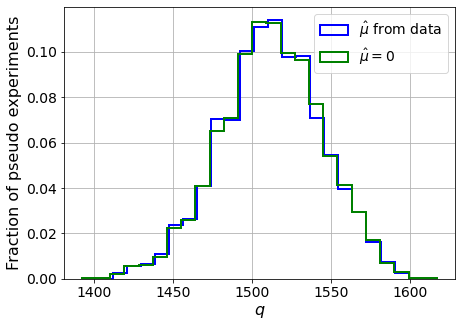

muhat mean:  -0.0057464609665306395
Z_bins:  38.89481164254619
std Z_bins:  0.41400342128702694
Z_bins mu=0:  38.89378871518064
std Z_bins mu=0:  0.41599088251693267

--------

B_expected:  643
S_expected:  1723



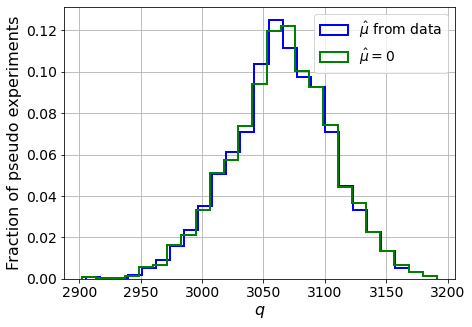

muhat mean:  -0.00281265667289646
Z_bins:  55.36555306725824
std Z_bins:  0.37530724565616247
Z_bins mu=0:  55.365534012617694
std Z_bins mu=0:  0.37664453090395283

--------

B_expected:  643
S_expected:  3326



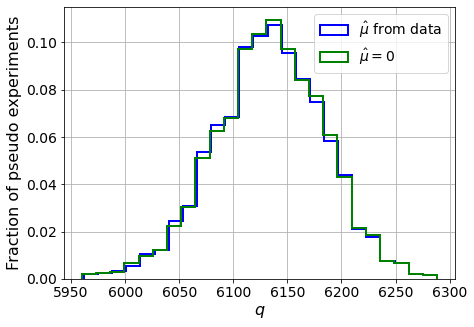

muhat mean:  -0.001524063603369727
Z_bins:  78.31895818443374
std Z_bins:  0.32231752280982906
Z_bins mu=0:  78.31895818443374
std Z_bins mu=0:  0.3232419220649226

--------


 FINAL RESULT:

[[0.6660864782007411, 0.2595323702615941, -4.816145294890245, 0.6660864782007411, 0.31892487216706317], [0.6806820636151737, 0.26026009042825415, -4.825327306889042, 0.6806820636151737, 0.3164040958092617], [0.6594401691410624, 0.2552950289821425, -4.8520315006073655, 0.6594401691410624, 0.31071284622007805], [0.9975152919170786, 0.34893584849652054, -2.5830236468249312, 0.9975152919170786, 0.41310230122093833], [1.6942643246274014, 0.4764681144683482, -0.8561284066475178, 1.6942643246274014, 0.5331274272861883], [2.4845934776101974, 0.5435810529882333, -0.5454024535791905, 2.4845934776101974, 0.5914020601791591], [3.7362214792144446, 0.5874715890693771, -0.2916548270998949, 3.7362214792144446, 0.616714569068149], [5.679083766031191, 0.6106088328050605, -0.14071193131803228, 5.679083766031191, 0.6

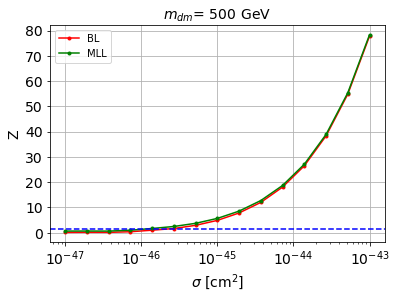


cross_BL_164:  2.6315694931653976e-46
cross_BL_164_up:  1.4582059845187146e-46
cross_BL_164_down:  3.685483075242213e-46

cross_MLL_164:  1.3281278464515268e-46
cross_MLL_164_up:  9.09690040949491e-47
cross_MLL_164_down:  2.040108460817219e-46

#########################



In [216]:
store_cross_BL_164 = []
store_cross_BL_164_up = []
store_cross_BL_164_down = []

store_cross_MLL_164 = []
store_cross_MLL_164_up = []
store_cross_MLL_164_down = []


for m_it2 in range(len(mDM_mDM)):

    # set the parameters
    mDM = mDM_mDM[m_it2]
    S_cross1045 = S_cross1045_mDM[m_it2]
    S_expected = S_expected_mDM[m_it2]

    print('\n#########################\n')
    print('mDM = ', mDM, 'GeV\n')


    ##########
    # SIGNAL #
    ##########

    S_cs1 = np.loadtxt(filefolder + 'WIMP_' + str(mDM) + 'GeV_cs1.txt')
    S_cs2 = np.loadtxt(filefolder + 'WIMP_' + str(mDM) + 'GeV_cs2.txt')

    print('\nS_cs1.shape: ', S_cs1.shape)
    print('S_cs2.shape: ', S_cs2.shape)

    S_cs1_aux = [S_cs1[x] for x in range(len(S_cs1)) if (3 < S_cs1[x] < 70 and 50 < S_cs2[x] < 8000)]
    S_cs2 = [S_cs2[x] for x in range(len(S_cs1)) if (3 < S_cs1[x] < 70 and 50 < S_cs2[x] < 8000)]
    S_cs1 = S_cs1_aux


    # set events per classs
    NUM_DAT = min(len(B_cs1_ER), len(S_cs1))
    print(' NUM_DAT: ', NUM_DAT, '\n')

    NUM_DAT_AC = int(NUM_DAT*f_AC)
    NUM_DAT_CNNS = max(1, int(NUM_DAT*f_CNNS))
    NUM_DAT_RN = int(NUM_DAT*f_RN)
    NUM_DAT_WALL = int(NUM_DAT*f_WALL)

    NUM_DAT_ER = NUM_DAT - ( NUM_DAT_AC + NUM_DAT_CNNS + NUM_DAT_RN + NUM_DAT_WALL )

    print('NUM_DAT_ER: ', NUM_DAT_ER)
    print('NUM_DAT_AC: ', NUM_DAT_AC)
    print('NUM_DAT_CNNS: ', NUM_DAT_CNNS)
    print('NUM_DAT_RN: ', NUM_DAT_RN)
    print('NUM_DAT_WALL: ', NUM_DAT_WALL)



    # CONCATENATE THE BACKGROUNDS
    B_cs1cs2 = np.concatenate([np.stack([B_cs1_ER,B_cs2_ER],axis=1)[:NUM_DAT_ER], np.stack([B_cs1_AC,B_cs2_AC],axis=1)[:NUM_DAT_AC], np.stack([B_cs1_CNNS,B_cs2_CNNS],axis=1)[:NUM_DAT_CNNS], np.stack([B_cs1_RN,B_cs2_RN],axis=1)[:NUM_DAT_RN], np.stack([B_cs1_WALL,B_cs2_WALL],axis=1)[:NUM_DAT_WALL]])

    print('\nB_cs1cs2.shape: ', B_cs1cs2.shape)


    S_cs1cs2 = np.stack([S_cs1,S_cs2],axis=1)[:NUM_DAT]

    print('\nS_cs1cs2.shape: ', S_cs1cs2.shape)


    rnd = 100

    B_cs1cs2_plot = shuffle(B_cs1cs2, random_state=rnd)
    S_cs1cs2_plot = shuffle(S_cs1cs2, random_state=rnd)

    plt.plot(B_cs1cs2_plot[:,0][:1000], B_cs1cs2_plot[:,1][:1000], '.', color='black', alpha=0.5, label='B')
    plt.plot(S_cs1cs2_plot[:,0][:1000], S_cs1cs2_plot[:,1][:1000], '.', color='red', alpha=0.5, label='S')
    plt.yscale('log')
    # plt.xlim([0,100])
    plt.ylim([100,10000])
    plt.xlabel('s1',fontsize=14)
    plt.ylabel('s2',fontsize=14)
    plt.legend(fontsize=14)
    plt.show()



    plt.plot(B_cs1cs2_plot[:,0][:1000], (B_cs1cs2_plot[:,1] / B_cs1cs2_plot[:,0])[:1000], '.', color='black', alpha=0.5, label='B')
    plt.plot(S_cs1cs2_plot[:,0][:1000], (S_cs1cs2_plot[:,1] / S_cs1cs2_plot[:,0])[:1000], '.', color='red', alpha=0.5, label='S')
    plt.yscale('log')
    # plt.xlim([0,100])
    # plt.ylim([100,10000])
    plt.xlabel('s1',fontsize=14)
    plt.ylabel('s2/s1',fontsize=14)
    plt.legend(fontsize=14)
    plt.show()


    ############
    # DATASETS #
    ############

    # concatenate the data
    X_mon_B = B_cs1cs2
    X_mon_S = S_cs1cs2

    # X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))
    # X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))
    print('X_mon_B.shape: ', X_mon_B.shape)
    print('X_mon_S.shape: ', X_mon_S.shape)

    # del B_ppeakS1
    # del B_ppeakS2
    # del B_pbot
    # del B_ptop

    # del S_ppeakS1
    # del S_ppeakS2
    # del S_pbot
    # del S_ptop

    X_mon = np.concatenate([X_mon_B, X_mon_S])

    # X_mon = np.concatenate([np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(S_pbot,(len(S_pbot),1))])

    print('X_mon.shape: ', X_mon.shape)
    # del X_mon_B
    # del X_mon_S


    # labels
    y_mon = np.concatenate([np.zeros(NUM_DAT),np.ones(NUM_DAT)])


    # divide into train-val and test data samples
    test_ratio = 0.25
    val_ratio = 0.15


    X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                    y_mon,
                                                                    test_size=test_ratio,
                                                                    random_state=42,
                                                                    #stratify = y_mon,
                                                                    shuffle=True)

    del X_mon
    del y_mon

    X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                      y_mon_aux,
                                                                      test_size=val_ratio,
                                                                      random_state=42,
                                                                      #stratify = y_mon_aux,
                                                                      shuffle=True)

    del X_mon_aux
    del y_mon_aux

    print('')
    print('X_mon_train : ', X_mon_train.shape)
    print('y_mon_train : ', y_mon_train.shape)
    print('X_mon_val : ', X_mon_val.shape)
    print('y_mon_val : ', y_mon_val.shape)
    print('X_mon_test : ', X_mon_test.shape)
    print('y_mon_test : ', y_mon_test.shape)
    print('')



    # PREDICTIONS
    y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


    # ROC
    fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
    roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)



    # XGBoost with the kinematic variables of the leptons

    ########################
    # CLASSIFICATION SCORE #
    ########################

    # Outputs for validation data set

    pred_XG_SM = []
    pred_XG_NP = []

    for i in range(len(y_mon_test)):
        if y_mon_test[i] == 0:
            pred_XG_SM.append(y_pred_xg[i])
        else:
            pred_XG_NP.append(y_pred_xg[i])


    print('Classification score:')

    weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
    nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

    weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
    nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Classication score (XGBoost)",fontsize=15)
    plt.ylabel("Fraction of events",fontsize=14)
    plt.grid()
    plt.legend(fontsize=12)

    plt.show()




    print('\n ROC-AUC = ', roc_auc_xg)



    #######################
    # BIN LIKELIHOOD TEST #
    #######################

    MIN_EVS = 5 # min number of background events that we allow per bin
    range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)

    bins_to_test=range(1,500) # number of bins we are testing to see if condition holds

    # FIND THE NUMBER OF BINS:
    num_binsX = max_num_bins(pred_XG_SM, B_expected, range_dat, MIN_EVS, bins_to_test)

    print('\n FOR BIN LIKELIHOOD WE ARE SETTING:')
    print('min number of Background events allowed per bin: ', MIN_EVS)
    print('max number of bins allowed: ', num_binsX)
    print('range of our data: ', range_dat)




    num_bins = min(10, num_binsX)
    print('number of bins we are going to use: ', num_bins)


    # OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
    store_Z_BL = []


    for s_it in range(len(S_expected)):

        print('B_expected: ', B_expected)
        print('S_expected: ', S_expected[s_it])
        print('')

        Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, S_expected[s_it], num_pseudo, num_bins, range_dat, MIN_EVS, linear_bins=True) 

        store_Z_BL.append( list(Z_BL) )

        print('muhat mean: ', Z_BL[2])
        print('Z_bins: ', Z_BL[0])
        print('std Z_bins: ', Z_BL[1])
        print('Z_bins mu=0: ', Z_BL[3])
        print('std Z_bins mu=0: ', Z_BL[4])
        print('')
        print('--------\n')



    print('\n FINAL RESULT:\n')
    print(store_Z_BL)




    #######
    # MLL #
    #######

    # USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs

    # outputs:
    # 1st -> background PDF
    # 2nd -> signal PDF
    # 3rd -> (normalization factor of the background PDF)**-1
    # 4th -> (normalization factor of the signal PDF)**-1
    # 5th -> background bandwidth
    # 6th -> signal bandwidth
    kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                            1000, 
                                                                                            np.logspace(-4.0, 0.05, 20), 
                                                                                            set_kernel='epanechnikov')




    # FOR EXCLUSION:
    # we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

    print('This may take a while...')

    pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    print('1 done')
    pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
    print('2 done')

    # Normalize
    pB_B_data = pB_B_data / norm_factor_SM
    pS_B_data = pS_B_data / norm_factor_NP


    if D_or_E == "discovery":

        # FOR DISCOVERY:
        # we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

        pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
        print('3 done')
        pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
        print('4 done')

        # Normalize
        pB_S_data = pB_S_data / norm_factor_SM
        pS_S_data = pS_S_data / norm_factor_NP

    else:
        # dummies
        pB_S_data = 1
        pS_S_data = 1





    # OPTION 2 (mu_hat with more precision) (slower)
    store_Z_MLL = []


    for s_it in range(len(S_expected)):

        print('B_expected: ', B_expected)
        print('S_expected: ', S_expected[s_it])
        print('')

        Z_MLL = MLL_test_fsolve(D_or_E, pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, S_expected[s_it], num_pseudo)

        store_Z_MLL.append( list(Z_MLL) )

        print('muhat mean: ', Z_MLL[2])
        print('Z_bins: ', Z_MLL[0])
        print('std Z_bins: ', Z_MLL[1])
        print('Z_bins mu=0: ', Z_MLL[3])
        print('std Z_bins mu=0: ', Z_MLL[4])
        print('')
        print('--------\n')


    print('\n FINAL RESULT:\n')
    print(store_Z_MLL)


    store_Z_MLL = np.array(store_Z_MLL)

    for hd in range(len(store_Z_MLL[:,0])):
        if store_Z_MLL[:,0][hd] == 0:
            store_Z_MLL[:,0][hd] = store_Z_MLL[:,3][hd]
            store_Z_MLL[:,1][hd] = store_Z_MLL[:,4][hd]




    # plot
    plt.plot(cross_factor*1e-45, np.array(store_Z_BL)[:,0], '.-', c='red', label='BL')
    plt.plot(cross_factor*1e-45, np.array(store_Z_MLL)[:,0], '.-', c='green', label = "MLL")

    plt.axhline(y=1.64, c='blue', linestyle='--')
    plt.title('$m_{dm}$= %0.2d GeV' % mDM, fontsize=14)
    plt.xscale('log')
    plt.xlabel(r'$\sigma$ [cm$^2$]', fontsize=14)
    plt.ylabel(r'Z', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


    # interpolate
    f_Z = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0], kind='linear')
    f_Z_up = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0] + np.array(store_Z_BL)[:,1], kind='linear')
    f_Z_down = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0] - np.array(store_Z_BL)[:,1], kind='linear')

    # compute the cross section with Z=1.64
    cross_BL_164 = 10**solvecross(f_Z, 1.64)
    cross_BL_164_up = 10**solvecross(f_Z_up, 1.64)
    cross_BL_164_down = 10**solvecross(f_Z_down, 1.64)

    store_cross_BL_164.append(cross_BL_164)
    store_cross_BL_164_up.append(cross_BL_164_up)
    store_cross_BL_164_down.append(cross_BL_164_down)


    # interpolate
    f_Z_MLL = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_MLL)[:,0], kind='linear')
    f_Z_MLL_up = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_MLL)[:,0] + np.array(store_Z_MLL)[:,1], kind='linear')
    f_Z_MLL_down = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_MLL)[:,0] - np.array(store_Z_MLL)[:,1], kind='linear')

    # compute the cross section with Z=1.64
    cross_MLL_164 = 10**solvecross(f_Z_MLL, 1.64)
    cross_MLL_164_up = 10**solvecross(f_Z_MLL_up, 1.64)
    cross_MLL_164_down = 10**solvecross(f_Z_MLL_down, 1.64)

    store_cross_MLL_164.append(cross_MLL_164)
    store_cross_MLL_164_up.append(cross_MLL_164_up)
    store_cross_MLL_164_down.append(cross_MLL_164_down)


    print('\ncross_BL_164: ', cross_BL_164)
    print('cross_BL_164_up: ', cross_BL_164_up)
    print('cross_BL_164_down: ', cross_BL_164_down)

    print('\ncross_MLL_164: ', cross_MLL_164)
    print('cross_MLL_164_up: ', cross_MLL_164_up)
    print('cross_MLL_164_down: ', cross_MLL_164_down)
    print('\n#########################\n')


In [217]:
cross_cs1cs2 = store_cross_BL_164
cross_cs1cs2_up = store_cross_BL_164_up
cross_cs1cs2_down = store_cross_BL_164_down

print(cross_cs1cs2)
print(cross_cs1cs2_up)
print(cross_cs1cs2_down)


cross_cs1cs2_MLL = store_cross_MLL_164
cross_cs1cs2_MLL_up = store_cross_MLL_164_up
cross_cs1cs2_MLL_down = store_cross_MLL_164_down

print(cross_cs1cs2_MLL)
print(cross_cs1cs2_MLL_up)
print(cross_cs1cs2_MLL_down)

[1.1176409942332989e-45, 8.030353418633125e-47, 4.100695577859679e-47, 4.1046817887235696e-47, 5.9918468195289e-47, 1.0228385029121443e-46, 2.6315694931653976e-46]
[7.763952084315532e-46, 4.99214987683996e-47, 2.7467616097410144e-47, 2.351594183827524e-47, 3.8522788027023874e-47, 6.532073544322104e-47, 1.4582059845187146e-46]
[1.665947990567396e-45, 1.1342286643969094e-46, 6.128548166976857e-47, 5.982280588355771e-47, 8.114960474084952e-47, 1.5412912753159991e-46, 3.685483075242213e-46]
[1e-45, 4.636506814143082e-47, 2.471361178718406e-47, 2.270814845976436e-47, 3.3324773708557455e-47, 5.730753345380576e-47, 1.3281278464515268e-46]
[6.70805808467225e-46, 2.5664757620599847e-47, 1.8459359951248977e-47, 1.4792353862159966e-47, 1.7184947371797877e-47, 3.6702074293744576e-47, 9.09690040949491e-47]
[1.371620855888689e-45, 7.30604645624313e-47, 3.677891104702873e-47, 3.787751119928501e-47, 4.779839059475387e-47, 8.121178193222236e-47, 2.040108460817219e-46]


In [218]:
np.savetxt('results/general/cs1cs2_mDM_ALL.txt', [cross_cs1cs2, cross_cs1cs2_up, cross_cs1cs2_down])
np.savetxt('results/general/cs1cs2_mDM_ALL_MLL.txt', [cross_cs1cs2_MLL, cross_cs1cs2_MLL_up, cross_cs1cs2_MLL_down])

In [219]:
cross_cs1cs2_general_mALL = np.loadtxt('results/general/cs1cs2_mDM_ALL.txt')[0]
cross_cs1cs2_general_mALL_up = np.loadtxt('results/general/cs1cs2_mDM_ALL.txt')[1]
cross_cs1cs2_general_mALL_down =np.loadtxt('results/general/cs1cs2_mDM_ALL.txt')[2]

cross_cs1cs2_general_mALL_MLL = np.loadtxt('results/general/cs1cs2_mDM_ALL_MLL.txt')[0]
cross_cs1cs2_general_mALL_MLL_up = np.loadtxt('results/general/cs1cs2_mDM_ALL_MLL.txt')[1]
cross_cs1cs2_general_mALL_MLL_down = np.loadtxt('results/general/cs1cs2_mDM_ALL_MLL.txt')[2]

In [ ]:
# LOAD THE RESULTS TRAINING WITH A FIXED MASS AND APPLYING IT TO ALL THE MASSES

cross_cs1cs2_general_m0 = np.loadtxt('results/general/cs1cs2_mDM0.txt')[0]
cross_cs1cs2_general_m0_up = np.loadtxt('results/general/cs1cs2_mDM0.txt')[1]
cross_cs1cs2_general_m0_down =np.loadtxt('results/general/cs1cs2_mDM0.txt')[2]

cross_cs1cs2_general_m0_MLL = np.loadtxt('results/general/cs1cs2_mDM0_MLL.txt')[0]
cross_cs1cs2_general_m0_MLL_up = np.loadtxt('results/general/cs1cs2_mDM0_MLL.txt')[1]
cross_cs1cs2_general_m0_MLL_down = np.loadtxt('results/general/cs1cs2_mDM0_MLL.txt')[2]


cross_cs1cs2_general_m1 = np.loadtxt('results/general/cs1cs2_mDM1.txt')[0]
cross_cs1cs2_general_m1_up = np.loadtxt('results/general/cs1cs2_mDM1.txt')[1]
cross_cs1cs2_general_m1_down =np.loadtxt('results/general/cs1cs2_mDM1.txt')[2]

cross_cs1cs2_general_m1_MLL = np.loadtxt('results/general/cs1cs2_mDM1_MLL.txt')[0]
cross_cs1cs2_general_m1_MLL_up = np.loadtxt('results/general/cs1cs2_mDM1_MLL.txt')[1]
cross_cs1cs2_general_m1_MLL_down = np.loadtxt('results/general/cs1cs2_mDM1_MLL.txt')[2]


cross_cs1cs2_general_m2 = np.loadtxt('results/general/cs1cs2_mDM2.txt')[0]
cross_cs1cs2_general_m2_up = np.loadtxt('results/general/cs1cs2_mDM2.txt')[1]
cross_cs1cs2_general_m2_down =np.loadtxt('results/general/cs1cs2_mDM2.txt')[2]

cross_cs1cs2_general_m2_MLL = np.loadtxt('results/general/cs1cs2_mDM2_MLL.txt')[0]
cross_cs1cs2_general_m2_MLL_up = np.loadtxt('results/general/cs1cs2_mDM2_MLL.txt')[1]
cross_cs1cs2_general_m2_MLL_down = np.loadtxt('results/general/cs1cs2_mDM2_MLL.txt')[2]


cross_cs1cs2_general_m3 = np.loadtxt('results/general/cs1cs2_mDM3.txt')[0]
cross_cs1cs2_general_m3_up = np.loadtxt('results/general/cs1cs2_mDM3.txt')[1]
cross_cs1cs2_general_m3_down =np.loadtxt('results/general/cs1cs2_mDM3.txt')[2]

cross_cs1cs2_general_m3_MLL = np.loadtxt('results/general/cs1cs2_mDM3_MLL.txt')[0]
cross_cs1cs2_general_m3_MLL_up = np.loadtxt('results/general/cs1cs2_mDM3_MLL.txt')[1]
cross_cs1cs2_general_m3_MLL_down = np.loadtxt('results/general/cs1cs2_mDM3_MLL.txt')[2]


cross_cs1cs2_general_m4 = np.loadtxt('results/general/cs1cs2_mDM4.txt')[0]
cross_cs1cs2_general_m4_up = np.loadtxt('results/general/cs1cs2_mDM4.txt')[1]
cross_cs1cs2_general_m4_down =np.loadtxt('results/general/cs1cs2_mDM4.txt')[2]

cross_cs1cs2_general_m4_MLL = np.loadtxt('results/general/cs1cs2_mDM4_MLL.txt')[0]
cross_cs1cs2_general_m4_MLL_up = np.loadtxt('results/general/cs1cs2_mDM4_MLL.txt')[1]
cross_cs1cs2_general_m4_MLL_down = np.loadtxt('results/general/cs1cs2_mDM4_MLL.txt')[2]


cross_cs1cs2_general_m5 = np.loadtxt('results/general/cs1cs2_mDM5.txt')[0]
cross_cs1cs2_general_m5_up = np.loadtxt('results/general/cs1cs2_mDM5.txt')[1]
cross_cs1cs2_general_m5_down =np.loadtxt('results/general/cs1cs2_mDM5.txt')[2]

cross_cs1cs2_general_m5_MLL = np.loadtxt('results/general/cs1cs2_mDM5_MLL.txt')[0]
cross_cs1cs2_general_m5_MLL_up = np.loadtxt('results/general/cs1cs2_mDM5_MLL.txt')[1]
cross_cs1cs2_general_m5_MLL_down = np.loadtxt('results/general/cs1cs2_mDM5_MLL.txt')[2]


cross_cs1cs2_general_m6 = np.loadtxt('results/general/cs1cs2_mDM6.txt')[0]
cross_cs1cs2_general_m6_up = np.loadtxt('results/general/cs1cs2_mDM6.txt')[1]
cross_cs1cs2_general_m6_down =np.loadtxt('results/general/cs1cs2_mDM6.txt')[2]

cross_cs1cs2_general_m6_MLL = np.loadtxt('results/general/cs1cs2_mDM6_MLL.txt')[0]
cross_cs1cs2_general_m6_MLL_up = np.loadtxt('results/general/cs1cs2_mDM6_MLL.txt')[1]
cross_cs1cs2_general_m6_MLL_down = np.loadtxt('results/general/cs1cs2_mDM6_MLL.txt')[2]

In [119]:
x_XENON1T_1tonyr_down = [6.055606916561549, 6.823778108538652, 7.726215280067716, 8.582423845905856, 9.904912022713336, 11.596190805697788, 14.105146244789573, 17.91067828986308, 22.419318490487267, 28.741287837312296, 37.55681861498598, 46.12118051468561, 57.18227249733948, 70.55823652254493, 95.79168238706818, 141.05146244789574, 199.9078624971397, 281.97296360054435, 435.5160347143599, 663.0965425825532, 1004.7885762566482]
y_XENON1T_1tonyr_down = [2.122997019253291e-44, 6.830827595149092e-45, 2.5565879564232304e-45, 1.0450855592138182e-45, 3.814128748283239e-46, 1.6397373222443297e-46, 7.13879927716957e-47, 3.4375712618817914e-47, 2.296937143881235e-47, 1.807931378879487e-47, 1.5939048066202329e-47, 1.57394815950498e-47, 1.6141144911444228e-47, 1.7629420229546865e-47, 2.1840435093891482e-47, 2.99267938153686e-47, 4.3126768942716094e-47, 5.984360998261109e-47, 9.301141506038491e-47, 1.4275218465524083e-46, 2.218713527075558e-46]

x_XENON1T_1tonyr_up = [5.998025375267653, 6.694623244123534, 7.837740338641554, 9.176046414544945, 10.340054351159923, 12.047941859795849, 14.240556819126223, 17.57167968977445, 22.419318490487267, 28.604313898938127, 36.495613101538225, 45.03259469748133, 54.77586085235927, 70.22197324875098, 93.0849924905222, 139.0444078719906, 196.1241707554598, 274.00553519070826, 411.25186818001043, 650.5459961419798, 995.2342449249492]
y_XENON1T_1tonyr_up = [8.70579590515474e-44, 3.137473218474891e-44, 8.046532229280133e-45, 2.7573536821266015e-45, 1.2156689420722025e-45, 5.6367138959821105e-46, 2.7486819276573736e-46, 1.4639514554724662e-46, 8.956129880675696e-47, 6.702940894624926e-47, 5.909433198208975e-47, 5.909433198208975e-47, 6.293693784124586e-47, 6.873996431179536e-47, 8.409314634569101e-47, 1.1236099983376527e-46, 1.5013107289081836e-46, 2.057166738834862e-46, 3.0401858742608336e-46, 4.785094961345878e-46, 7.252122247218222e-46]

x_XENON1T_1tonyr_dat = [5.940991365202825, 6.5679129168455805, 7.616277137894846, 8.874272903135752, 10.340054351159923, 11.990524319733609, 14.308748811391741, 17.156940060795215, 20.76956429087212, 25.142875087521656, 30.147625520495286, 36.14858369857204, 45.901378264580416, 60.267473771664314, 83.39918867052648, 123.98267316495033, 183.43638249062232, 276.63601106438455, 407.34135734995056, 638.2329961306843, 990.4912022713337]
y_XENON1T_1tonyr_dat = [2.4080691095438086e-44, 9.84373819664703e-45, 2.936650461687786e-45, 1.0320004592606233e-45, 4.492941663683521e-46, 2.362985258610077e-46, 1.2744862586397517e-46, 7.699400454191772e-47, 5.479161357412966e-47, 4.422734147010833e-47, 4.1007103760403667e-47, 4.2586795849318555e-47, 4.830527157087775e-47, 5.984360998261109e-47, 7.797023884122048e-47, 1.1095417251641934e-46, 1.5989333808583735e-46, 2.3333992615362496e-46, 3.448416377736618e-46, 5.427628610945291e-46, 8.542806062673913e-46]

In [122]:
f_XE_up = interp1d(x_XENON1T_1tonyr_up, y_XENON1T_1tonyr_up)
f_XE_down = interp1d(x_XENON1T_1tonyr_down, y_XENON1T_1tonyr_down)

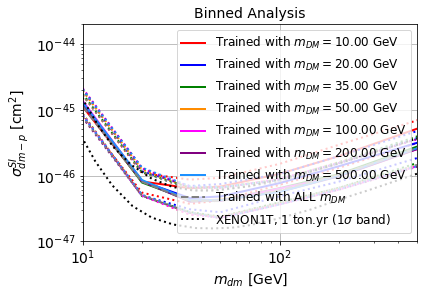

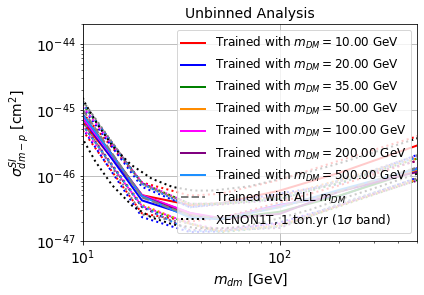

In [221]:
# plot
plt.figure()
lw = 2


plt.plot(mDM_mDM, cross_cs1cs2_general_m0, '-', color='red', lw=lw, label=r'Trained with $m_{DM}=%0.2f$ GeV' % mDM_mDM[0])
plt.plot(mDM_mDM, cross_cs1cs2_general_m0_up, ':', color='red', lw=lw) 
plt.plot(mDM_mDM, cross_cs1cs2_general_m0_down, ':', color='red', lw=lw)

plt.plot(mDM_mDM, cross_cs1cs2_general_m1, '-', color='blue', lw=lw, label=r'Trained with $m_{DM}=%0.2f$ GeV' % mDM_mDM[1])
plt.plot(mDM_mDM, cross_cs1cs2_general_m1_up, ':', color='blue', lw=lw) 
plt.plot(mDM_mDM, cross_cs1cs2_general_m1_down, ':', color='blue', lw=lw)

plt.plot(mDM_mDM, cross_cs1cs2_general_m2, '-', color='green', lw=lw, label=r'Trained with $m_{DM}=%0.2f$ GeV' % mDM_mDM[2])
plt.plot(mDM_mDM, cross_cs1cs2_general_m2_up, ':', color='green', lw=lw) 
plt.plot(mDM_mDM, cross_cs1cs2_general_m2_down, ':', color='green', lw=lw)

plt.plot(mDM_mDM, cross_cs1cs2_general_m3, '-', color='darkorange', lw=lw, label=r'Trained with $m_{DM}=%0.2f$ GeV' % mDM_mDM[3])
plt.plot(mDM_mDM, cross_cs1cs2_general_m3_up, ':', color='darkorange', lw=lw) 
plt.plot(mDM_mDM, cross_cs1cs2_general_m3_down, ':', color='darkorange', lw=lw)

plt.plot(mDM_mDM, cross_cs1cs2_general_m4, '-', color='magenta', lw=lw, label=r'Trained with $m_{DM}=%0.2f$ GeV' % mDM_mDM[4])
plt.plot(mDM_mDM, cross_cs1cs2_general_m4_up, ':', color='magenta', lw=lw) 
plt.plot(mDM_mDM, cross_cs1cs2_general_m4_down, ':', color='magenta', lw=lw)

plt.plot(mDM_mDM, cross_cs1cs2_general_m5, '-', color='purple', lw=lw, label=r'Trained with $m_{DM}=%0.2f$ GeV' % mDM_mDM[5])
plt.plot(mDM_mDM, cross_cs1cs2_general_m5_up, ':', color='purple', lw=lw) 
plt.plot(mDM_mDM, cross_cs1cs2_general_m5_down, ':', color='purple', lw=lw)

plt.plot(mDM_mDM, cross_cs1cs2_general_m6, '-', color='dodgerblue', lw=lw, label=r'Trained with $m_{DM}=%0.2f$ GeV' % mDM_mDM[6])
plt.plot(mDM_mDM, cross_cs1cs2_general_m6_up, ':', color='dodgerblue', lw=lw) 
plt.plot(mDM_mDM, cross_cs1cs2_general_m6_down, ':', color='dodgerblue', lw=lw)
    
plt.plot(mDM_mDM, cross_cs1cs2_general_mALL, '--', color='gray', lw=lw, label=r'Trained with ALL $m_{DM}$')
plt.plot(mDM_mDM, cross_cs1cs2_general_mALL_up, ':', color='gray', lw=lw) 
plt.plot(mDM_mDM, cross_cs1cs2_general_mALL_down, ':', color='gray', lw=lw)

#plt.plot(x_XENON1T_1tonyr_dat, y_XENON1T_1tonyr_dat, '--', color='green', lw=lw, label='XENON1T')
plt.plot(x_XENON1T_1tonyr_up, y_XENON1T_1tonyr_up, ':', color='black', lw=lw, label='XENON1T, 1 ton.yr (1$\sigma$ band)')
plt.plot(x_XENON1T_1tonyr_down, y_XENON1T_1tonyr_down, ':', color='black', lw=lw)

plt.title('Binned Analysis', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10,500)
plt.ylim(1e-47, 2e-44)
plt.xlabel(r'$m_{dm}$ [GeV]', fontsize=14)
plt.ylabel(r'$\sigma^{SI}_{dm-p}$ [cm$^2$]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend(loc="upper right", fontsize=12)
# plt.savefig('limits3.pdf',bbox_inches='tight')
plt.show()




# plot
plt.figure()
lw = 2

plt.plot(mDM_mDM, cross_cs1cs2_general_m0_MLL, '-', color='red', lw=lw, label=r'Trained with $m_{DM}=%0.2f$ GeV' % mDM_mDM[0])
plt.plot(mDM_mDM, cross_cs1cs2_general_m0_MLL_up, ':', color='red', lw=lw) 
plt.plot(mDM_mDM, cross_cs1cs2_general_m0_MLL_down, ':', color='red', lw=lw)

plt.plot(mDM_mDM, cross_cs1cs2_general_m1_MLL, '-', color='blue', lw=lw, label=r'Trained with $m_{DM}=%0.2f$ GeV' % mDM_mDM[1])
plt.plot(mDM_mDM, cross_cs1cs2_general_m1_MLL_up, ':', color='blue', lw=lw) 
plt.plot(mDM_mDM, cross_cs1cs2_general_m1_MLL_down, ':', color='blue', lw=lw)

plt.plot(mDM_mDM, cross_cs1cs2_general_m2_MLL, '-', color='green', lw=lw, label=r'Trained with $m_{DM}=%0.2f$ GeV' % mDM_mDM[2])
plt.plot(mDM_mDM, cross_cs1cs2_general_m2_MLL_up, ':', color='green', lw=lw) 
plt.plot(mDM_mDM, cross_cs1cs2_general_m2_MLL_down, ':', color='green', lw=lw)

plt.plot(mDM_mDM, cross_cs1cs2_general_m3_MLL, '-', color='darkorange', lw=lw, label=r'Trained with $m_{DM}=%0.2f$ GeV' % mDM_mDM[3])
plt.plot(mDM_mDM, cross_cs1cs2_general_m3_MLL_up, ':', color='darkorange', lw=lw) 
plt.plot(mDM_mDM, cross_cs1cs2_general_m3_MLL_down, ':', color='darkorange', lw=lw)

plt.plot(mDM_mDM, cross_cs1cs2_general_m4_MLL, '-', color='magenta', lw=lw, label=r'Trained with $m_{DM}=%0.2f$ GeV' % mDM_mDM[4])
plt.plot(mDM_mDM, cross_cs1cs2_general_m4_MLL_up, ':', color='magenta', lw=lw) 
plt.plot(mDM_mDM, cross_cs1cs2_general_m4_MLL_down, ':', color='magenta', lw=lw)

plt.plot(mDM_mDM, cross_cs1cs2_general_m5_MLL, '-', color='purple', lw=lw, label=r'Trained with $m_{DM}=%0.2f$ GeV' % mDM_mDM[5])
plt.plot(mDM_mDM, cross_cs1cs2_general_m5_MLL_up, ':', color='purple', lw=lw) 
plt.plot(mDM_mDM, cross_cs1cs2_general_m5_MLL_down, ':', color='purple', lw=lw)

plt.plot(mDM_mDM, cross_cs1cs2_general_m6_MLL, '-', color='dodgerblue', lw=lw, label=r'Trained with $m_{DM}=%0.2f$ GeV' % mDM_mDM[6])
plt.plot(mDM_mDM, cross_cs1cs2_general_m6_MLL_up, ':', color='dodgerblue', lw=lw) 
plt.plot(mDM_mDM, cross_cs1cs2_general_m6_MLL_down, ':', color='dodgerblue', lw=lw)
    
plt.plot(mDM_mDM, cross_cs1cs2_general_mALL_MLL, '--', color='gray', lw=lw, label=r'Trained with ALL $m_{DM}$')
plt.plot(mDM_mDM, cross_cs1cs2_general_mALL_MLL_up, ':', color='gray', lw=lw) 
plt.plot(mDM_mDM, cross_cs1cs2_general_mALL_MLL_down, ':', color='gray', lw=lw)


#plt.plot(x_XENON1T_1tonyr_dat, y_XENON1T_1tonyr_dat, '--', color='green', lw=lw, label='XENON1T')
plt.plot(x_XENON1T_1tonyr_up, y_XENON1T_1tonyr_up, ':', color='black', lw=lw, label='XENON1T, 1 ton.yr (1$\sigma$ band)')
plt.plot(x_XENON1T_1tonyr_down, y_XENON1T_1tonyr_down, ':', color='black', lw=lw)

plt.title('Unbinned Analysis', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10,500)
plt.ylim(1e-47, 2e-44)
plt.xlabel(r'$m_{dm}$ [GeV]', fontsize=14)
plt.ylabel(r'$\sigma^{SI}_{dm-p}$ [cm$^2$]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend(loc="upper right", fontsize=12)
# plt.savefig('limits3.pdf',bbox_inches='tight')
plt.show()

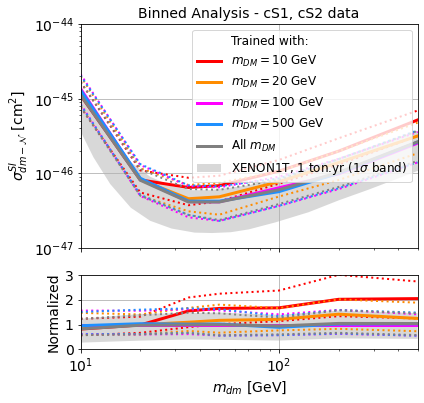

In [222]:
fig, axs = plt.subplots(2,1,figsize=(6,5.7), gridspec_kw={'height_ratios': [3, 1]})

lw = 2

# things to plots
p_aux1 = cross_cs1cs2_general_m0
p_aux1_up = cross_cs1cs2_general_m0_up
p_aux1_down = cross_cs1cs2_general_m0_down
c1 = 'red'
l1 = r'$m_{DM}=%0.0f$ GeV' % mDM_mDM[0]

p_aux2 = cross_cs1cs2_general_m1
p_aux2_up = cross_cs1cs2_general_m1_up
p_aux2_down = cross_cs1cs2_general_m1_down
c2 = 'darkorange'
l2 = r'$m_{DM}=%0.0f$ GeV' % mDM_mDM[1]

p_aux3 = cross_cs1cs2_general_m2
p_aux3_up = cross_cs1cs2_general_m2_up
p_aux3_down = cross_cs1cs2_general_m2_down
c3 = 'blue'
l3 = r'$m_{DM}=%0.0f$ GeV' % mDM_mDM[2]

p_aux4 = cross_cs1cs2_general_m3
p_aux4_up = cross_cs1cs2_general_m3_up
p_aux4_down = cross_cs1cs2_general_m3_down
c4 = 'green'
l4 = r'$m_{DM}=%0.0f$ GeV' % mDM_mDM[3]

p_aux5 = cross_cs1cs2_general_m4
p_aux5_up = cross_cs1cs2_general_m4_up
p_aux5_down = cross_cs1cs2_general_m4_down
c5 = 'magenta'
l5 = r'$m_{DM}=%0.0f$ GeV' % mDM_mDM[4]

p_aux6 = cross_cs1cs2_general_m5
p_aux6_up = cross_cs1cs2_general_m5_up
p_aux6_down = cross_cs1cs2_general_m5_down
c6 = 'purple'
l6 = r'$m_{DM}=%0.0f$ GeV' % mDM_mDM[5]

p_aux7 = cross_cs1cs2_general_m6
p_aux7_up = cross_cs1cs2_general_m6_up
p_aux7_down = cross_cs1cs2_general_m6_down
c7 = 'dodgerblue'
l7 = r'$m_{DM}=%0.0f$ GeV' % mDM_mDM[6]

p_aux8 = cross_cs1cs2_general_mALL
p_aux8_up = cross_cs1cs2_general_mALL_up
p_aux8_down = cross_cs1cs2_general_mALL_down
c8 = 'gray'
l8 = r'All $m_{DM}$'


axs[0].plot(mDM_mDM, mDM_mDM, '-', color=None, alpha=0., lw=3, label='Trained with:')

axs[0].plot(mDM_mDM, p_aux1, '-', color=c1, lw=3, label=l1)
axs[0].plot(mDM_mDM, p_aux1_up, ':', color=c1, lw=lw)
axs[0].plot(mDM_mDM, p_aux1_down, ':', color=c1, lw=lw)

axs[0].plot(mDM_mDM, p_aux2, '-', color=c2, lw=3, label=l2)
axs[0].plot(mDM_mDM, p_aux2_up, ':', color=c2, lw=lw)
axs[0].plot(mDM_mDM, p_aux2_down, ':', color=c2, lw=lw)

# axs[0].plot(mDM_mDM, p_aux3, '-', color=c3, lw=3, label=l3)
# axs[0].plot(mDM_mDM, p_aux3_up, ':', color=c3, lw=lw)
# axs[0].plot(mDM_mDM, p_aux3_down, ':', color=c3, lw=lw)

# axs[0].plot(mDM_mDM, p_aux4, '-', color=c4, lw=3, label=l4)
# axs[0].plot(mDM_mDM, p_aux4_up, ':', color=c4, lw=lw)
# axs[0].plot(mDM_mDM, p_aux4_down, ':', color=c4, lw=lw)

axs[0].plot(mDM_mDM, p_aux5, '-', color=c5, lw=3, label=l5)
axs[0].plot(mDM_mDM, p_aux5_up, ':', color=c5, lw=lw)
axs[0].plot(mDM_mDM, p_aux5_down, ':', color=c5, lw=lw)

# axs[0].plot(mDM_mDM, p_aux6, '-', color=c6, lw=3, label=l6)
# axs[0].plot(mDM_mDM, p_aux6_up, ':', color=c6, lw=lw)
# axs[0].plot(mDM_mDM, p_aux6_down, ':', color=c6, lw=lw)

axs[0].plot(mDM_mDM, p_aux7, '-', color=c7, lw=3, label=l7)
axs[0].plot(mDM_mDM, p_aux7_up, ':', color=c7, lw=lw)
axs[0].plot(mDM_mDM, p_aux7_down, ':', color=c7, lw=lw)

axs[0].plot(mDM_mDM, p_aux8, '-', color=c8, lw=3, label=l8)
axs[0].plot(mDM_mDM, p_aux8_up, ':', color=c8, lw=lw)
axs[0].plot(mDM_mDM, p_aux8_down, ':', color=c8, lw=lw)

axs[0].fill(
    np.append(x_XENON1T_1tonyr_up, x_XENON1T_1tonyr_down[::-1]),
    np.append(y_XENON1T_1tonyr_up, y_XENON1T_1tonyr_down[::-1]), color = 'gray', edgecolor=None, alpha=0.3,
    label='XENON1T, 1 ton.yr (1$\sigma$ band)'
)


# Normalize
norm = p_aux5

Np_aux1 = [ a/b for a, b in zip(p_aux1,norm)]
Np_aux1_up = [ a/b for a, b in zip(p_aux1_up,norm)]
Np_aux1_down = [ a/b for a, b in zip(p_aux1_down,norm)]

Np_aux2 = [ a/b for a, b in zip(p_aux2,norm)]
Np_aux2_up = [ a/b for a, b in zip(p_aux2_up,norm)]
Np_aux2_down = [ a/b for a, b in zip(p_aux2_down,norm)]

Np_aux3 = [ a/b for a, b in zip(p_aux3,norm)]
Np_aux3_up = [ a/b for a, b in zip(p_aux3_up,norm)]
Np_aux3_down = [ a/b for a, b in zip(p_aux3_down,norm)]

Np_aux4 = [ a/b for a, b in zip(p_aux4,norm)]
Np_aux4_up = [ a/b for a, b in zip(p_aux4_up,norm)]
Np_aux4_down = [ a/b for a, b in zip(p_aux4_down,norm)]

Np_aux5 = [ a/b for a, b in zip(p_aux5,norm)]
Np_aux5_up = [ a/b for a, b in zip(p_aux5_up,norm)]
Np_aux5_down = [ a/b for a, b in zip(p_aux5_down,norm)]

Np_aux6 = [ a/b for a, b in zip(p_aux6,norm)]
Np_aux6_up = [ a/b for a, b in zip(p_aux6_up,norm)]
Np_aux6_down = [ a/b for a, b in zip(p_aux6_down,norm)]

Np_aux7 = [ a/b for a, b in zip(p_aux7,norm)]
Np_aux7_up = [ a/b for a, b in zip(p_aux7_up,norm)]
Np_aux7_down = [ a/b for a, b in zip(p_aux7_down,norm)]

Np_aux8 = [ a/b for a, b in zip(p_aux8,norm)]
Np_aux8_up = [ a/b for a, b in zip(p_aux8_up,norm)]
Np_aux8_down = [ a/b for a, b in zip(p_aux8_down,norm)]

Np_XE_up = [ a/b for a, b in zip(f_XE_up(mDM_mDM),norm)]
Np_XE_down = [ a/b for a, b in zip(f_XE_down(mDM_mDM),norm)]





axs[1].plot(mDM_mDM, Np_aux1, '-', color=c1, lw=3, label=l1)
axs[1].plot(mDM_mDM, Np_aux1_up, ':', color=c1, lw=lw)
axs[1].plot(mDM_mDM, Np_aux1_down, ':', color=c1, lw=lw)

axs[1].plot(mDM_mDM, Np_aux2, '-', color=c2, lw=3, label=l2)
axs[1].plot(mDM_mDM, Np_aux2_up, ':', color=c2, lw=lw)
axs[1].plot(mDM_mDM, Np_aux2_down, ':', color=c2, lw=lw)

# axs[1].plot(mDM_mDM, Np_aux3, '-', color=c3, lw=3, label=l3)
# axs[1].plot(mDM_mDM, Np_aux3_up, ':', color=c3, lw=lw)
# axs[1].plot(mDM_mDM, Np_aux3_down, ':', color=c3, lw=lw)

# axs[1].plot(mDM_mDM, Np_aux4, '-', color=c4, lw=3, label=l4)
# axs[1].plot(mDM_mDM, Np_aux4_up, ':', color=c4, lw=lw)
# axs[1].plot(mDM_mDM, Np_aux4_down, ':', color=c4, lw=lw)

axs[1].plot(mDM_mDM, Np_aux5, '-', color=c5, lw=3, label=l5)
axs[1].plot(mDM_mDM, Np_aux5_up, ':', color=c5, lw=lw)
axs[1].plot(mDM_mDM, Np_aux5_down, ':', color=c5, lw=lw)

# axs[1].plot(mDM_mDM, Np_aux6, '-', color=c6, lw=3, label=l6)
# axs[1].plot(mDM_mDM, Np_aux6_up, ':', color=c6, lw=lw)
# axs[1].plot(mDM_mDM, Np_aux6_down, ':', color=c6, lw=lw)

axs[1].plot(mDM_mDM, Np_aux7, '-', color=c7, lw=3, label=l7)
axs[1].plot(mDM_mDM, Np_aux7_up, ':', color=c7, lw=lw)
axs[1].plot(mDM_mDM, Np_aux7_down, ':', color=c7, lw=lw)

axs[1].plot(mDM_mDM, Np_aux8, '-', color=c8, lw=3, label=l8)
axs[1].plot(mDM_mDM, Np_aux8_up, ':', color=c8, lw=lw)
axs[1].plot(mDM_mDM, Np_aux8_down, ':', color=c8, lw=lw)


axs[1].fill(
    np.append(mDM_mDM, mDM_mDM[::-1]),
    np.append(Np_XE_up, Np_XE_down[::-1]), color = 'gray', edgecolor=None, alpha=0.3,
    label='XENON1T, 1 ton.yr (1$\sigma$ band)'
)


axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')
# axs[1].set_yscale('log')

axs[0].set_xlim([10, 500])
axs[0].set_ylim([1e-47, 1e-44])
axs[1].set_xlim([10, 500])
axs[1].set_ylim([0.,3])
axs[0].set_ylabel(r'$\sigma^{SI}_{dm-\mathcal{N}}$ [cm$^2$]', fontsize=14)
axs[1].set_xlabel(r'$m_{dm}$ [GeV]', fontsize=14)
axs[1].set_ylabel(r'Normalized', fontsize=14)

axs[0].yaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_ticklabels([])
axs[1].yaxis.set_ticks([0, 1, 2, 3])
axs[1].xaxis.set_tick_params(labelsize=14)
axs[1].yaxis.set_tick_params(labelsize=14)

axs[0].grid()
axs[1].grid()

axs[0].set_title('Binned Analysis - cS1, cS2 data', fontsize=14)
axs[0].legend(loc="upper right", fontsize=12)
plt.tight_layout()
# plt.savefig('limits3A.pdf', format="pdf", bbox_inches="tight")
plt.show()

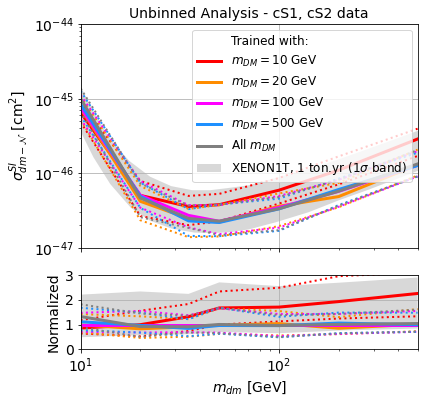

In [223]:
fig, axs = plt.subplots(2,1,figsize=(6,5.7), gridspec_kw={'height_ratios': [3, 1]})

lw = 2

# things to plots
p_aux1 = cross_cs1cs2_general_m0_MLL
p_aux1_up = cross_cs1cs2_general_m0_MLL_up
p_aux1_down = cross_cs1cs2_general_m0_MLL_down
c1 = 'red'
l1 = r'$m_{DM}=%0.0f$ GeV' % mDM_mDM[0]

p_aux2 = cross_cs1cs2_general_m1_MLL
p_aux2_up = cross_cs1cs2_general_m1_MLL_up
p_aux2_down = cross_cs1cs2_general_m1_MLL_down
c2 = 'darkorange'
l2 = r'$m_{DM}=%0.0f$ GeV' % mDM_mDM[1]

p_aux3 = cross_cs1cs2_general_m2_MLL
p_aux3_up = cross_cs1cs2_general_m2_MLL_up
p_aux3_down = cross_cs1cs2_general_m2_MLL_down
c3 = 'blue'
l3 = r'$m_{DM}=%0.0f$ GeV' % mDM_mDM[2]

p_aux4 = cross_cs1cs2_general_m3_MLL
p_aux4_up = cross_cs1cs2_general_m3_MLL_up
p_aux4_down = cross_cs1cs2_general_m3_MLL_down
c4 = 'green'
l4 = r'$m_{DM}=%0.0f$ GeV' % mDM_mDM[3]

p_aux5 = cross_cs1cs2_general_m4_MLL
p_aux5_up = cross_cs1cs2_general_m4_MLL_up
p_aux5_down = cross_cs1cs2_general_m4_MLL_down
c5 = 'magenta'
l5 = r'$m_{DM}=%0.0f$ GeV' % mDM_mDM[4]

p_aux6 = cross_cs1cs2_general_m5_MLL
p_aux6_up = cross_cs1cs2_general_m5_MLL_up
p_aux6_down = cross_cs1cs2_general_m5_MLL_down
c6 = 'purple'
l6 = r'$m_{DM}=%0.0f$ GeV' % mDM_mDM[5]

p_aux7 = cross_cs1cs2_general_m6_MLL
p_aux7_up = cross_cs1cs2_general_m6_MLL_up
p_aux7_down = cross_cs1cs2_general_m6_MLL_down
c7 = 'dodgerblue'
l7 = r'$m_{DM}=%0.0f$ GeV' % mDM_mDM[6]

p_aux8 = cross_cs1cs2_general_mALL_MLL
p_aux8_up = cross_cs1cs2_general_mALL_MLL_up
p_aux8_down = cross_cs1cs2_general_mALL_MLL_down
c8 = 'gray'
l8 = r'All $m_{DM}$ '


axs[0].plot(mDM_mDM, mDM_mDM, '-', color=None, alpha=0., lw=3, label='Trained with:')

axs[0].plot(mDM_mDM, p_aux1, '-', color=c1, lw=3, label=l1)
axs[0].plot(mDM_mDM, p_aux1_up, ':', color=c1, lw=lw)
axs[0].plot(mDM_mDM, p_aux1_down, ':', color=c1, lw=lw)

axs[0].plot(mDM_mDM, p_aux2, '-', color=c2, lw=3, label=l2)
axs[0].plot(mDM_mDM, p_aux2_up, ':', color=c2, lw=lw)
axs[0].plot(mDM_mDM, p_aux2_down, ':', color=c2, lw=lw)

# axs[0].plot(mDM_mDM, p_aux3, '-', color=c3, lw=3, label=l3)
# axs[0].plot(mDM_mDM, p_aux3_up, ':', color=c3, lw=lw)
# axs[0].plot(mDM_mDM, p_aux3_down, ':', color=c3, lw=lw)

# axs[0].plot(mDM_mDM, p_aux4, '-', color=c4, lw=3, label=l4)
# axs[0].plot(mDM_mDM, p_aux4_up, ':', color=c4, lw=lw)
# axs[0].plot(mDM_mDM, p_aux4_down, ':', color=c4, lw=lw)

axs[0].plot(mDM_mDM, p_aux5, '-', color=c5, lw=3, label=l5)
axs[0].plot(mDM_mDM, p_aux5_up, ':', color=c5, lw=lw)
axs[0].plot(mDM_mDM, p_aux5_down, ':', color=c5, lw=lw)

# axs[0].plot(mDM_mDM, p_aux6, '-', color=c6, lw=3, label=l6)
# axs[0].plot(mDM_mDM, p_aux6_up, ':', color=c6, lw=lw)
# axs[0].plot(mDM_mDM, p_aux6_down, ':', color=c6, lw=lw)

axs[0].plot(mDM_mDM, p_aux7, '-', color=c7, lw=3, label=l7)
axs[0].plot(mDM_mDM, p_aux7_up, ':', color=c7, lw=lw)
axs[0].plot(mDM_mDM, p_aux7_down, ':', color=c7, lw=lw)

axs[0].plot(mDM_mDM, p_aux8, '-', color=c8, lw=3, label=l8)
axs[0].plot(mDM_mDM, p_aux8_up, ':', color=c8, lw=lw)
axs[0].plot(mDM_mDM, p_aux8_down, ':', color=c8, lw=lw)

axs[0].fill(
    np.append(x_XENON1T_1tonyr_up, x_XENON1T_1tonyr_down[::-1]),
    np.append(y_XENON1T_1tonyr_up, y_XENON1T_1tonyr_down[::-1]), color = 'gray', edgecolor=None, alpha=0.3,
    label='XENON1T, 1 ton.yr (1$\sigma$ band)'
)


# Normalize
norm = p_aux5

Np_aux1 = [ a/b for a, b in zip(p_aux1,norm)]
Np_aux1_up = [ a/b for a, b in zip(p_aux1_up,norm)]
Np_aux1_down = [ a/b for a, b in zip(p_aux1_down,norm)]

Np_aux2 = [ a/b for a, b in zip(p_aux2,norm)]
Np_aux2_up = [ a/b for a, b in zip(p_aux2_up,norm)]
Np_aux2_down = [ a/b for a, b in zip(p_aux2_down,norm)]

Np_aux3 = [ a/b for a, b in zip(p_aux3,norm)]
Np_aux3_up = [ a/b for a, b in zip(p_aux3_up,norm)]
Np_aux3_down = [ a/b for a, b in zip(p_aux3_down,norm)]

Np_aux4 = [ a/b for a, b in zip(p_aux4,norm)]
Np_aux4_up = [ a/b for a, b in zip(p_aux4_up,norm)]
Np_aux4_down = [ a/b for a, b in zip(p_aux4_down,norm)]

Np_aux5 = [ a/b for a, b in zip(p_aux5,norm)]
Np_aux5_up = [ a/b for a, b in zip(p_aux5_up,norm)]
Np_aux5_down = [ a/b for a, b in zip(p_aux5_down,norm)]

Np_aux6 = [ a/b for a, b in zip(p_aux6,norm)]
Np_aux6_up = [ a/b for a, b in zip(p_aux6_up,norm)]
Np_aux6_down = [ a/b for a, b in zip(p_aux6_down,norm)]

Np_aux7 = [ a/b for a, b in zip(p_aux7,norm)]
Np_aux7_up = [ a/b for a, b in zip(p_aux7_up,norm)]
Np_aux7_down = [ a/b for a, b in zip(p_aux7_down,norm)]

Np_aux8 = [ a/b for a, b in zip(p_aux8,norm)]
Np_aux8_up = [ a/b for a, b in zip(p_aux8_up,norm)]
Np_aux8_down = [ a/b for a, b in zip(p_aux8_down,norm)]

Np_XE_up = [ a/b for a, b in zip(f_XE_up(mDM_mDM),norm)]
Np_XE_down = [ a/b for a, b in zip(f_XE_down(mDM_mDM),norm)]





axs[1].plot(mDM_mDM, Np_aux1, '-', color=c1, lw=3, label=l1)
axs[1].plot(mDM_mDM, Np_aux1_up, ':', color=c1, lw=lw)
axs[1].plot(mDM_mDM, Np_aux1_down, ':', color=c1, lw=lw)

axs[1].plot(mDM_mDM, Np_aux2, '-', color=c2, lw=3, label=l2)
axs[1].plot(mDM_mDM, Np_aux2_up, ':', color=c2, lw=lw)
axs[1].plot(mDM_mDM, Np_aux2_down, ':', color=c2, lw=lw)

# axs[1].plot(mDM_mDM, Np_aux3, '-', color=c3, lw=3, label=l3)
# axs[1].plot(mDM_mDM, Np_aux3_up, ':', color=c3, lw=lw)
# axs[1].plot(mDM_mDM, Np_aux3_down, ':', color=c3, lw=lw)

# axs[1].plot(mDM_mDM, Np_aux4, '-', color=c4, lw=3, label=l4)
# axs[1].plot(mDM_mDM, Np_aux4_up, ':', color=c4, lw=lw)
# axs[1].plot(mDM_mDM, Np_aux4_down, ':', color=c4, lw=lw)

axs[1].plot(mDM_mDM, Np_aux5, '-', color=c5, lw=3, label=l5)
axs[1].plot(mDM_mDM, Np_aux5_up, ':', color=c5, lw=lw)
axs[1].plot(mDM_mDM, Np_aux5_down, ':', color=c5, lw=lw)

# axs[1].plot(mDM_mDM, Np_aux6, '-', color=c6, lw=3, label=l6)
# axs[1].plot(mDM_mDM, Np_aux6_up, ':', color=c6, lw=lw)
# axs[1].plot(mDM_mDM, Np_aux6_down, ':', color=c6, lw=lw)

axs[1].plot(mDM_mDM, Np_aux7, '-', color=c7, lw=3, label=l7)
axs[1].plot(mDM_mDM, Np_aux7_up, ':', color=c7, lw=lw)
axs[1].plot(mDM_mDM, Np_aux7_down, ':', color=c7, lw=lw)

axs[1].plot(mDM_mDM, Np_aux8, '-', color=c8, lw=3, label=l8)
axs[1].plot(mDM_mDM, Np_aux8_up, ':', color=c8, lw=lw)
axs[1].plot(mDM_mDM, Np_aux8_down, ':', color=c8, lw=lw)


axs[1].fill(
    np.append(mDM_mDM, mDM_mDM[::-1]),
    np.append(Np_XE_up, Np_XE_down[::-1]), color = 'gray', edgecolor=None, alpha=0.3,
    label='XENON1T, 1 ton.yr (1$\sigma$ band)'
)


axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')
# axs[1].set_yscale('log')

axs[0].set_xlim([10, 500])
axs[0].set_ylim([1e-47, 1e-44])
axs[1].set_xlim([10, 500])
axs[1].set_ylim([0.,3])
axs[0].set_ylabel(r'$\sigma^{SI}_{dm-\mathcal{N}}$ [cm$^2$]', fontsize=14)
axs[1].set_xlabel(r'$m_{dm}$ [GeV]', fontsize=14)
axs[1].set_ylabel(r'Normalized', fontsize=14)

axs[0].yaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_ticklabels([])
axs[1].yaxis.set_ticks([0, 1, 2, 3])
axs[1].xaxis.set_tick_params(labelsize=14)
axs[1].yaxis.set_tick_params(labelsize=14)

axs[0].grid()
axs[1].grid()

axs[0].set_title('Unbinned Analysis - cS1, cS2 data', fontsize=14)
axs[0].legend(loc="upper right", fontsize=12)
plt.tight_layout()
# plt.savefig('limits3B.pdf', format="pdf", bbox_inches="tight")
plt.show()